In [250]:
!hostname
!pwd
!which python

hemingway
/media/ebeyerle/seagate/af2-dynamics/notebooks
/home/ebeyerle/micromamba/envs/bioemu-env/bin/python


/media/ebeyerle/seagate/af2-dynamics/notebooks
/home/ebeyerle/micromamba/envs/bioemu-env/bin/python


In [251]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import LE4PD3N
import dtaidistance
import subprocess

In [252]:
def traj_from_xtc(XTC, TOP, chunk_size = 10000):
	lst = []
	for chunk in md.iterload(XTC, chunk = chunk_size, top = TOP):
		print(chunk)
		lst.append(chunk)

	for i, dummy in enumerate(lst):
		print(dummy)
		NFRS = dummy.n_frames
		NATOMS = dummy.n_atoms
		if i == 0:
			traj =  np.reshape(dummy.xyz, (NFRS, 3*NATOMS))
		else:
			traj = np.vstack([traj, np.reshape(dummy.xyz, (NFRS, 3*NATOMS))])

	return traj #, md.join(lst)

def xyz_from_xtc(XTC, TOP, chunk_size = 10000):
	lst = []
	for chunk in md.iterload(XTC, chunk = chunk_size, top = TOP):
		print(chunk)
		lst.append(chunk)

	for i, dummy in enumerate(lst):
		print(dummy)
		NFRS = dummy.n_frames
		NATOMS = dummy.n_atoms
		if i == 0:
			traj =  dummy.xyz
		else:
			traj = np.vstack([traj, dummy.xyz])

	return traj #, md.join(lst)

def traj_from_dcd(DCD, TOP, chunk_size = 10000):
	lst = []
	for chunk in md.iterload(DCD, chunk = chunk_size, top = TOP):
		print(chunk)
		lst.append(chunk)

	for i, dummy in enumerate(lst):
		print(dummy)
		NFRS = dummy.n_frames
		NATOMS = dummy.n_atoms
		if i == 0:
			traj =  np.reshape(dummy.xyz, (NFRS, 3*NATOMS))
		else:
			traj = np.vstack([traj, np.reshape(dummy.xyz, (NFRS, 3*NATOMS))])

	return traj


def traj_from_pdb(PDB, TOP, chunk_size = 10000):
	lst = []
	for chunk in md.iterload(PDB, chunk = chunk_size, top = TOP):
		print(chunk)
		lst.append(chunk)

	for i, dummy in enumerate(lst):
		print(dummy)
		NFRS = dummy.n_frames
		NATOMS = dummy.n_atoms
		if i == 0:
			traj =  np.reshape(dummy.xyz, (NFRS, 3*NATOMS))
		else:
			traj = np.vstack([traj, np.reshape(dummy.xyz, (NFRS, 3*NATOMS))])

	return traj

def ca_traj_from_xtc(XTC, TOP, chunk_size = 10000):
	lst = []
	for chunk in md.iterload(XTC, chunk = chunk_size, top = TOP):
		print(chunk)
		lst.append(chunk)

	for i, dummy in enumerate(lst):
		print(dummy)
		NFRS = dummy.n_frames
		NATOMS = dummy.n_atoms
		if i == 0:
			traj =  np.reshape(dummy.xyz, (NFRS, 3*NATOMS))
		else:
			traj = np.vstack([traj, np.reshape(dummy.xyz, (NFRS, 3*NATOMS))])

	return traj #, md.join(lst)


def tau_convert(eigvals, avfr, T = 300, bar = None, HA = False):
    #kT in J
    avfr = avfr*1e-9
    kT = 1.38e-23*T
    #Convert to kg *nm^2 / ps^2
    sigma = (kT / avfr)
    #print(sigma)
    tau = 1e-6*eigvals*avfr /(kT)
    if bar == None:
        bar = np.zeros(len(eigvals))
    tau_scaled = tau*np.exp(bar)
    return tau

def integ(y,x):
    integ_v=np.trapz(y,x)
    # f=interp1d(x,y,kind='cubic')
    # xval=np.linspace(x[0]+0.01, x[-1]-0.01,num=129,endpoint=True)
    # integ_v=simps(f(xval),xval)
    #print('Integration value : '+str(integ_v)+'\n')
    return integ_v

In [311]:
params = {'legend.fontsize': 25,
          'figure.figsize': (8, 6),
         'axes.labelsize': 30,
         'axes.titlesize':25,
         'xtick.labelsize':25,'ytick.labelsize':25,
         'axes.linewidth':4,
         'xtick.major.width':3,'ytick.major.width':3,
         'xtick.minor.width':1,'ytick.minor.width':1,
         'xtick.major.size':5,'ytick.major.size':5,
         'xtick.minor.size':3,'ytick.minor.size':3,
         'xtick.direction':'in','ytick.direction':'in'
         }
plt.rcParams.update(params)

In [312]:
# use values from universality paper

# scaling laws within error
a = 2.
gamma = 1.

# energy per unit length in kT / A
eps = (6.5 / 10.) / (1.38 * 0.3 * 6.022 *(1 / 4.184))

In [327]:
t_sim = np.linspace(0, 250000, 250001)
t_sim_10ns = np.linspace(0, 2500, 2501)
t_sim_100ns = np.linspace(0, 25000, 25001)
t_theo = np.linspace(0, 250000, 25001)

In [328]:
suffix = ['_0eafb', '_5d034', '_87f3d']

In [329]:
big_corr_list = []
big_scaled_corr_list = []
big_HA_corr_list  = []
big_HA_scaled_corr_list = []


df_big_corr_list = []
df_big_scaled_corr_list = []
df_big_HA_corr_list  = []
df_big_HA_scaled_corr_list = []

MD_HA_scaled_corr_list = []

In [330]:
# 10 ps step for the theory
t = np.linspace(0, 250000, 25001)

In [331]:
# distance matrices from rMSA = 8, bioemu, af2-cluster, and DiG

rmsf_list = []
seq_list = ['3ttp', '2pc0', '1q9p', '1ebw', '4z4x', '6p9a']
for j, seq in enumerate(seq_list):
    #tau_list = []
    tau_scaled_list = []
    corr_func_list = []
    corr_func_scaled_list = []
    cdf_list = []
    cdf_scaled_list = []
    covar_list = []
    PLDDT_list = []
    dtraj_list = []
    for i in [8]: #, 64, 'full', 'af2-cluster', 'DiG', 'bioemu']:
        print(i)
        #traj = traj_from_xtc('../3ttp_%smsa/cat.xtc' % i, '../3ttp_CA.pdb')
        # hardcode at NFRS := 320 for the af2-generated ensembles
        if (i == 8) or (i == 64) or (i == 'full'):
            NFRS = 320
            traj = traj_from_xtc(f'../{seq}_%smsa/mode0_2_LE4PD_no_deepfakes.xtc' % i, f'../{seq}_CA.pdb')
            dtraj = traj - traj.mean(0)[None,:]
            QINV = np.load(f'../{seq}_%smsa/mode0_2_LE4PD_no_deepfakes/QINVmatrix.npy' % i)
            Q = np.load(f'../{seq}_%smsa/mode0_2_LE4PD_no_deepfakes/Qmatrix.npy' % i)
            eigvecs = np.copy(Q)
            eigvals = np.loadtxt(f'../{seq}_%smsa/mode0_2_LE4PD_no_deepfakes/lambda_eig' % i)
            mu_eig = np.loadtxt(f'../{seq}_%smsa/mode0_2_LE4PD_no_deepfakes/mu_eig' % i)
        elif i == 'af2-cluster':
            NFRS = 320
            traj = traj_from_xtc(f'../AF_Cluster-main/{seq}%s/LE4PD_no_deepfakes.xtc' % suffix[j], f'../{seq}_CA.pdb')
            dtraj = traj - traj.mean(0)[None,:]
            QINV = np.load(f'../AF_Cluster-main/{seq}%s/LE4PD_no_deepfakes/QINVmatrix.npy' % suffix[j])
            Q = np.load(f'../AF_Cluster-main/{seq}%s/LE4PD_no_deepfakes/Qmatrix.npy' % suffix[j])
            eigvals = np.loadtxt(f'../AF_Cluster-main/{seq}%s/LE4PD_no_deepfakes/lambda_eig' % suffix[j])
            mu_eig = np.loadtxt(f'../AF_Cluster-main/{seq}%s/LE4PD_no_deepfakes/mu_eig' % suffix[j])
            eigvecs = np.copy(Q)
        elif i == 'DiG':
            traj = traj_from_xtc(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD_no_deepfakes.xtc', f'../{seq}_CA.pdb')
            dtraj = traj - traj.mean(0)[None,:]
            QINV = np.load(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD_no_deepfakes/QINVmatrix.npy')
            Q = np.load(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD_no_deepfakes/Qmatrix.npy')
            eigvals = np.loadtxt(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD_no_deepfakes/lambda_eig')
            mu_eig = np.loadtxt(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD_no_deepfakes/mu_eig')
            eigvecs = np.copy(Q)
        elif i == 'bioemu':
            traj = traj_from_xtc(f'../bioemu/{seq}/LE4PD_no_deepfakes.xtc', f'../{seq}_CA.pdb')
            dtraj = traj - traj.mean(0)[None,:]
            QINV = np.load(f'../bioemu/{seq}/LE4PD_no_deepfakes/QINVmatrix.npy')
            Q = np.load(f'../bioemu/{seq}/LE4PD_no_deepfakes/Qmatrix.npy')
            eigvals = np.loadtxt(f'../bioemu/{seq}/LE4PD_no_deepfakes/lambda_eig')
            mu_eig = np.loadtxt(f'../bioemu/{seq}/LE4PD_no_deepfakes/mu_eig')
            eigvecs = np.copy(Q)

        rmsf = np.sqrt((mu_eig * (Q[::3,:]**2 + Q[1::3,:]**2 + Q[2::3,:]**2)).sum(1))
        rmsf_list.append(rmsf)
        
        
        fratio, sigma, fric, avfr = LE4PD3N.fric_calc(f'../{seq}_ref.pdb', f'{seq}', dtraj.shape[1] // 3, dtraj.shape[0], eigvals, 300, path_to_resarea=f'../{seq}_8msa/')
        tau = tau_convert(eigvals, avfr)
        tau_scaled = tau * np.exp((eps * np.sqrt(abs(mu_eig))))
        #tau_list.append(tau)
        #tau_scaled_list.append(tau_scaled)
        weights = np.zeros((eigvecs.shape[0] // 3, eigvecs.shape[1]))
        for n, _ in enumerate(range(0, eigvecs.shape[0], 3)):
            for a in range(eigvecs.shape[1]):
                #print(a, counter)
                weights[n,a] = (eigvecs[_:_+3,a]**2).sum(0) * mu_eig[a]
        #t = np.linspace(0, 100000, 100000)
        #corr_func = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau[None,:-6]))).T).T 
        corr_func_scaled = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau_scaled[None,:-6]))).T).T
        #corr_func = corr_func / corr_func[0,:]
        corr_func_scaled = corr_func_scaled / corr_func_scaled[0,:]
        #corr_func_list.append(corr_func)
        corr_func_scaled_list.append(corr_func_scaled)
        #cdf_list.append(1. - corr_func)
        cdf_scaled_list.append(1. - corr_func_scaled)

    '''
    # integrate these tcfs to get the approximate timescale of the dynamics in the MD simulations
    NFRS = 320
    traj = traj_from_xtc(f'../{seq}_MD/aligned.xtc', f'../{seq}_CA.pdb')
    dtraj = traj - traj.mean(0)[None,:]
    QINV = np.load(f'../{seq}_MD/QINVmatrix.npy')
    Q = np.load(f'../{seq}_MD/Qmatrix.npy')
    eigvecs = np.copy(Q)
    eigvals = np.loadtxt(f'../{seq}_MD/lambda_eig')
    mu_eig = np.loadtxt(f'../{seq}_MD/mu_eig')
    #rmsf = np.sqrt((mu_eig * (Q[::3,:]**2 + Q[1::3,:]**2 + Q[2::3,:]**2)).sum(1))
    #rmsf_list.append(rmsf)
    
    
    fratio, sigma, fric, avfr = LE4PD3N.fric_calc(f'../{seq}_ref.pdb', '{seq}', dtraj.shape[1] // 3, dtraj.shape[0], eigvals, 300, path_to_resarea=f'../{seq}_8msa/')
    tau = tau_convert(eigvals, avfr)
    tau_scaled = tau * np.exp((eps * np.sqrt(eigvals)))
    #tau_list.append(tau)
    tau_scaled_list.append(tau_scaled)
    weights = np.zeros((eigvecs.shape[0] // 3, eigvecs.shape[1]))
    for n, _ in enumerate(range(0, eigvecs.shape[0], 3)):
        for a in range(eigvecs.shape[1]):
            #print(a, counter)
            weights[n,a] = (eigvecs[_:_+3,a]**2).sum(0) * mu_eig[a]
    #t = np.linspace(0, 100000, 100000)
    #corr_func = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau[None,:-6]))).T).T 
    corr_func_scaled = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau_scaled[None,:-6]))).T).T
    #corr_func = corr_func / corr_func[0,:]
    corr_func_scaled = corr_func_scaled / corr_func_scaled[0,:]

    MD_HA_scaled_corr_list.append(corr_func_scaled)
    '''

    
    #df_big_HA_corr_list.append(np.array(corr_func_list))
    big_HA_scaled_corr_list.append(np.array(corr_func_scaled_list))

8
<mdtraj.Trajectory with 274 frames, 99 atoms, 99 residues, without unitcells>
<mdtraj.Trajectory with 274 frames, 99 atoms, 99 residues, without unitcells>
3ttp 99 274
fratio:  0.20351838934321723
Temperature (K):  300
Internal viscosity factor:  2.71828
Viscosity (Pa s):  0.001
fd20 0.0
8
<mdtraj.Trajectory with 303 frames, 99 atoms, 99 residues, without unitcells>
<mdtraj.Trajectory with 303 frames, 99 atoms, 99 residues, without unitcells>
2pc0 99 303
fratio:  0.20662293181107913
Temperature (K):  300
Internal viscosity factor:  2.71828
Viscosity (Pa s):  0.001
fd20 0.0
8
<mdtraj.Trajectory with 290 frames, 95 atoms, 95 residues, without unitcells>
<mdtraj.Trajectory with 290 frames, 95 atoms, 95 residues, without unitcells>
1q9p 95 290
fratio:  0.21000896509931355
Temperature (K):  300
Internal viscosity factor:  2.71828
Viscosity (Pa s):  0.001
fd20 0.0
8
<mdtraj.Trajectory with 236 frames, 99 atoms, 99 residues, without unitcells>
<mdtraj.Trajectory with 236 frames, 99 atoms, 9

In [332]:
# for Akash's proteins, I need to extract the simulated time correlation functions from his precious 
# pickle files...I'll do that tomorrow.

In [333]:
big_sims_tcf_list = [np.load('3ttp_sim_tcfs.npy')[:,::10], np.load('2pc0_sim_tcfs.npy')[:,::10], 
                     np.load('1q9p_sim_tcfs.npy')[:,::10], np.load('../1ebw_sim_tcfs.npy')[::2,1:].T,
                     np.load('../4z4x_sim_tcfs.npy')[::2,1:].T, np.load('../6p9a_sim_tcfs.npy')[::2,1:].T]

In [334]:
msa_list = [8] #, 64, 'full', 'af2-cluster', 'DiG', 'bioemu']

In [335]:
nbins = 50

In [336]:
# redo this calculation for DTW
# calculate distances

big_cut_list = []

# split CDFs into 100 bins and measure the distance from the empirical distributions using those bins

for k in range(len(big_HA_scaled_corr_list)):
    print(k)
    dist_list = []
    scaled_dist_list = []
    nbins_list = []
    scaled_distances = np.zeros((big_HA_scaled_corr_list[k].shape[0], big_HA_scaled_corr_list[k].shape[2]))
    #scaled_distances = np.zeros((len(corr_func_list), corr_func_list[0].shape[1]))
    sim_tcfs = big_sims_tcf_list[k]
    sim_cdfs = 1. - sim_tcfs
    cdf_scaled_list = 1. - big_HA_scaled_corr_list[k]
    ks_cut_list = []
    
    for n in range(cdf_scaled_list.shape[0]):
        print(n)
        dummy0 = np.zeros(sim_cdfs.shape[0])
        dummy1 = np.zeros(sim_cdfs.shape[0])
    
        for i in range(sim_cdfs.shape[0]):
            m = np.gradient(sim_tcfs[i,:])
            if np.where(m >= 0) == []:
                cut = -1
            else:
                cut = np.where(m >= 0)[0][0]
            ks_cut_list.append(cut)

        
    nbins_list = np.array(nbins_list)
    KS_lim = 1.36 * np.sqrt((nbins_list + nbins_list) / (nbins_list * nbins_list))     
    
    big_cut_list.append(np.array(ks_cut_list))

0
0
1
0
2
0
3
0
4
0
5
0


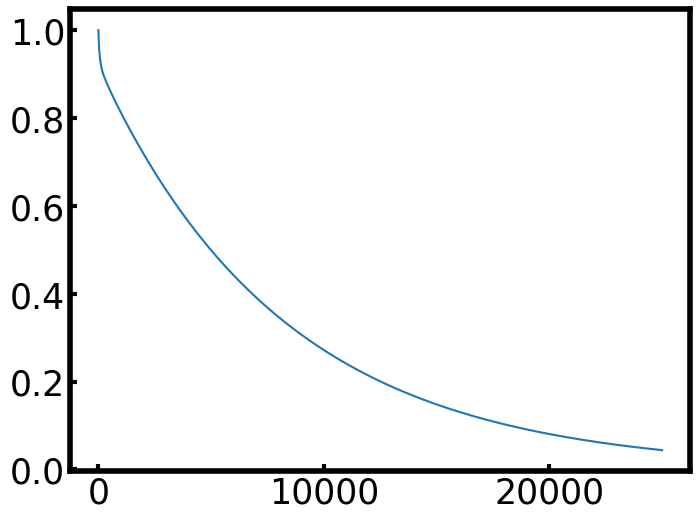

In [337]:
plt.plot(big_HA_scaled_corr_list[-1][0,:,0])

In [338]:
'''
ttp_cut_list = ks_ttp_cut_list #.reshape((6, len(ks_ttp_cut_list) //6))[0,:]
pc0_cut_list = ks_pc0_cut_list #.reshape((6, len(ks_pc0_cut_list) //6))[0,:]
q9p_cut_list = ks_q9p_cut_list #.reshape((6, len(ks_q9p_cut_list) //6))[0,:]

sim_ttp_tau_list = np.zeros(ttp_cut_list.__len__())
sim_pc0_tau_list = np.zeros(pc0_cut_list.__len__())
sim_q9p_tau_list = np.zeros(q9p_cut_list.__len__())
'''

big_tau_list = []
big_msa8_tau_list = []

for k in range(len(big_cut_list)):
    cut_list = big_cut_list[k]
    sim_tau_list = np.zeros(cut_list.__len__())
    _ = []

    for i in range(len(sim_tau_list)):
        _.append(integ(big_sims_tcf_list[k][i,:cut_list[i]], t[:cut_list[i]]))

    big_tau_list.append(np.array(_))
    
    
    msa8_tau_list = np.zeros(cut_list.__len__())
    
    tmp_tcfs = big_HA_scaled_corr_list[k][0,:,:].T
    for i in range(len(msa8_tau_list)):
        msa8_tau_list[i] = integ(tmp_tcfs[i,:], t)

    big_msa8_tau_list.append(msa8_tau_list)

/tmp/ipykernel_2483287/4247706870.py:102: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_v=np.trapz(y,x)


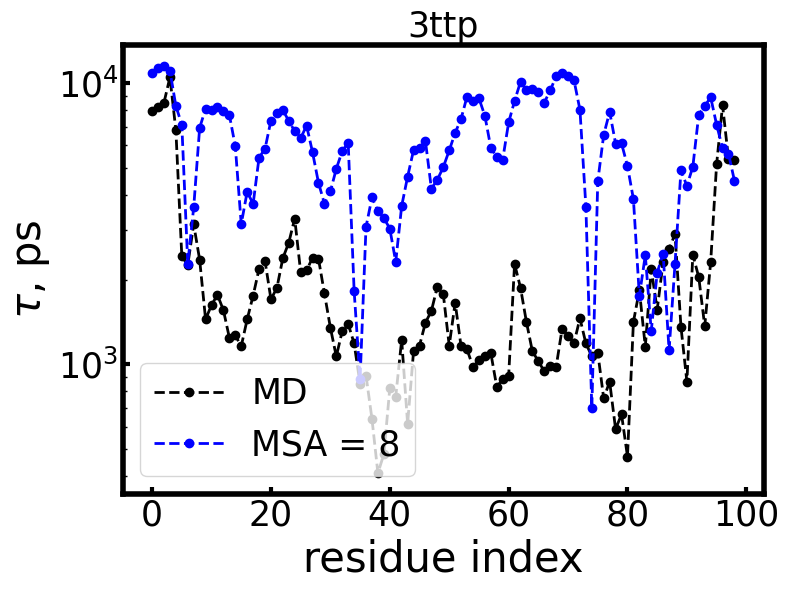

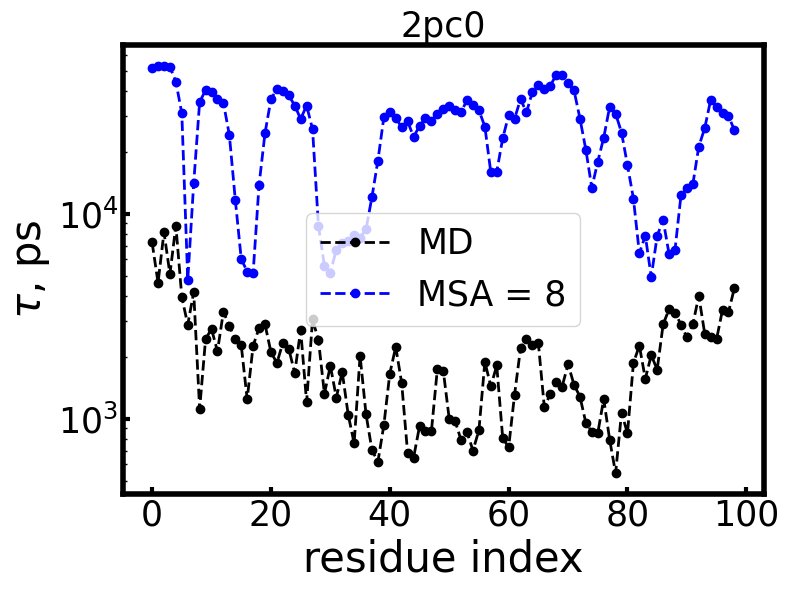

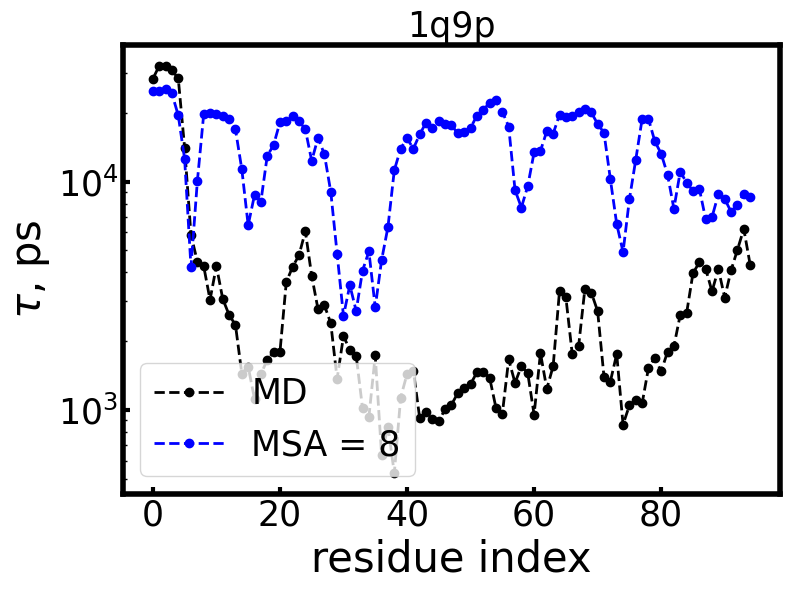

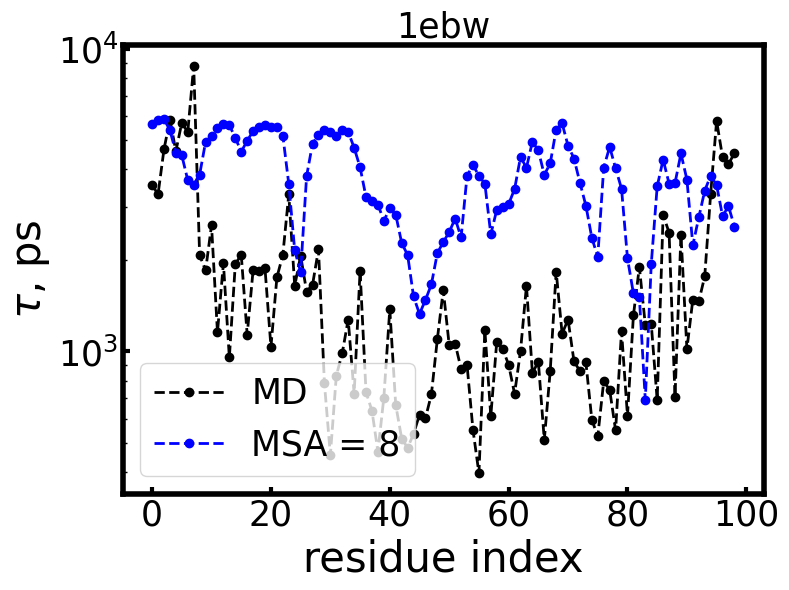

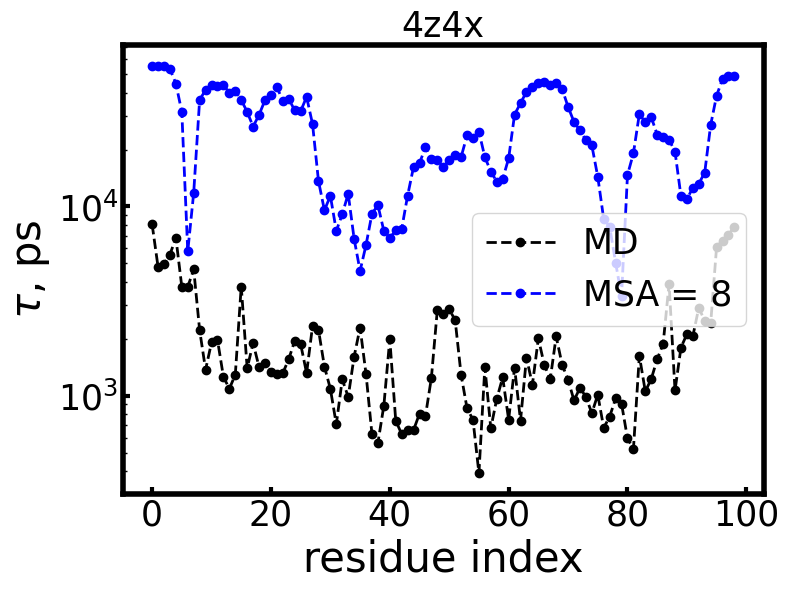

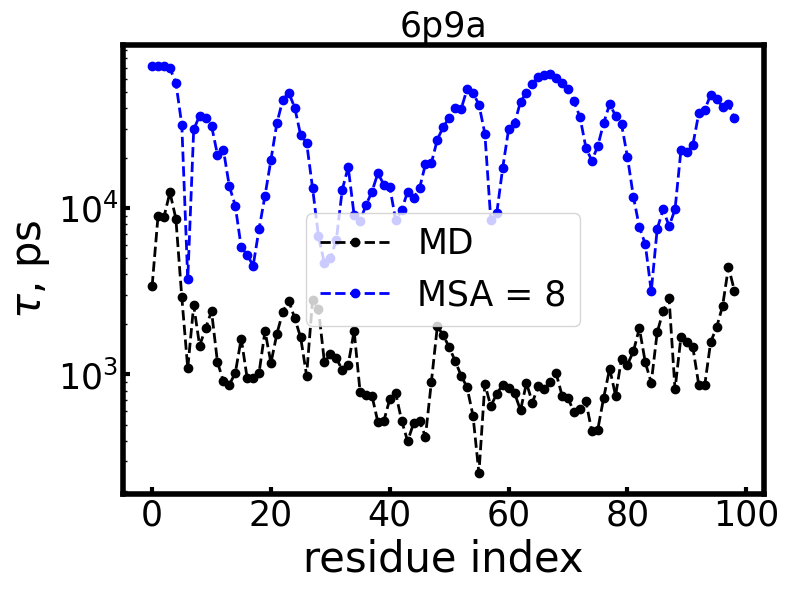

In [339]:
for k in range(len(big_tau_list)):
    plt.title(seq_list[k])
    plt.plot(big_tau_list[k], marker = 'o', lw = 2, ls = '--', c = 'k', label = 'MD')
    plt.plot(big_msa8_tau_list[k], marker = 'o', lw = 2, ls = '--', c = 'b', label = 'MSA = 8')
    #plt.plot(bioemu_ttp_tau_list, marker = 'o', lw = 2, ls = '--', c = 'r', label = 'BioEmu')
    plt.yscale('log')
    plt.ylabel(r'$\tau$, ps')
    plt.xlabel('residue index')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [342]:
# deepfakes

df_rmsf_list = []
seq_list = ['3ttp', '2pc0', '1q9p', '1ebw', '4z4x', '6p9a']
for j, seq in enumerate(seq_list):
    #tau_list = []
    tau_scaled_list = []
    corr_func_list = []
    corr_func_scaled_list = []
    cdf_list = []
    cdf_scaled_list = []
    covar_list = []
    PLDDT_list = []
    dtraj_list = []
    for i in [8]: #, 64, 'full', 'af2-cluster', 'DiG', 'bioemu']:
        print(i)
        #traj = traj_from_xtc('../3ttp_%smsa/cat.xtc' % i, '../3ttp_CA.pdb')
        # hardcode at NFRS := 320 for the af2-generated ensembles
        if (i == 8) or (i == 64) or (i == 'full'):
            NFRS = 320
            traj = traj_from_xtc(f'../{seq}_%smsa/aligned.xtc' % i, f'../{seq}_CA.pdb')
            dtraj = traj - traj.mean(0)[None,:]
            QINV = np.load(f'../{seq}_%smsa/QINVmatrix.npy' % i)
            Q = np.load(f'../{seq}_%smsa/Qmatrix.npy' % i)
            eigvecs = np.copy(Q)
            eigvals = np.loadtxt(f'../{seq}_%smsa/lambda_eig' % i)
            mu_eig = np.loadtxt(f'../{seq}_%smsa/mu_eig' % i)
        elif i == 'af2-cluster':
            NFRS = 320
            traj = traj_from_xtc(f'../AF_Cluster-main/{seq}%s/aligned.xtc' % suffix[j], f'../{seq}_CA.pdb')
            dtraj = traj - traj.mean(0)[None,:]
            QINV = np.load(f'../AF_Cluster-main/{seq}%s/LE4PD/QINVmatrix.npy' % suffix[j])
            Q = np.load(f'../AF_Cluster-main/{seq}%s/LE4PD/Qmatrix.npy' % suffix[j])
            eigvals = np.loadtxt(f'../AF_Cluster-main/{seq}%s/LE4PD/lambda_eig' % suffix[j])
            mu_eig = np.loadtxt(f'../AF_Cluster-main/{seq}%s/LE4PD/mu_eig' % suffix[j])
            eigvecs = np.copy(Q)
        elif i == 'DiG':
            traj = traj_from_xtc(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/aligned.xtc', f'../{seq}_CA.pdb')
            dtraj = traj - traj.mean(0)[None,:]
            QINV = np.load(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD/QINVmatrix.npy')
            Q = np.load(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD/Qmatrix.npy')
            eigvals = np.loadtxt(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD/lambda_eig')
            mu_eig = np.loadtxt(f'../microsoft-Graphormer-5e62370/distributional_graphormer/protein/{seq}_output/LE4PD/mu_eig')
            eigvecs = np.copy(Q)
        elif i == 'bioemu':
            traj = traj_from_xtc(f'../bioemu/{seq}/aligned.xtc', f'../{seq}_CA.pdb')
            dtraj = traj - traj.mean(0)[None,:]
            QINV = np.load(f'../bioemu/{seq}/LE4PD/QINVmatrix.npy')
            Q = np.load(f'../bioemu/{seq}/LE4PD/Qmatrix.npy')
            eigvals = np.loadtxt(f'../bioemu/{seq}/LE4PD/lambda_eig')
            mu_eig = np.loadtxt(f'../bioemu/{seq}/LE4PD/mu_eig')
            eigvecs = np.copy(Q)

        rmsf = np.sqrt((mu_eig * (Q[::3,:]**2 + Q[1::3,:]**2 + Q[2::3,:]**2)).sum(1))
        df_rmsf_list.append(rmsf)
        
        
        fratio, sigma, fric, avfr = LE4PD3N.fric_calc(f'../{seq}_ref.pdb', f'{seq}', dtraj.shape[1] // 3, dtraj.shape[0], eigvals, 300, path_to_resarea=f'../{seq}_8msa/')
        tau = tau_convert(eigvals, avfr)
        tau_scaled = tau * np.exp((eps * np.sqrt(abs(mu_eig))))
        #tau_list.append(tau)
        #tau_scaled_list.append(tau_scaled)
        weights = np.zeros((eigvecs.shape[0] // 3, eigvecs.shape[1]))
        for n, _ in enumerate(range(0, eigvecs.shape[0], 3)):
            for a in range(eigvecs.shape[1]):
                #print(a, counter)
                weights[n,a] = (eigvecs[_:_+3,a]**2).sum(0) * mu_eig[a]
        #t = np.linspace(0, 100000, 100000)
        #corr_func = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau[None,:-6]))).T).T 
        corr_func_scaled = np.matmul(weights[:,:-6], ((np.exp(-t[:,None] / tau_scaled[None,:-6]))).T).T
        #corr_func = corr_func / corr_func[0,:]
        corr_func_scaled = corr_func_scaled / corr_func_scaled[0,:]
        #corr_func_list.append(corr_func)
        corr_func_scaled_list.append(corr_func_scaled)
        #cdf_list.append(1. - corr_func)
        cdf_scaled_list.append(1. - corr_func_scaled)

    
    #df_big_HA_corr_list.append(np.array(corr_func_list))
    df_big_HA_scaled_corr_list.append(np.array(corr_func_scaled_list))

8
<mdtraj.Trajectory with 320 frames, 99 atoms, 99 residues, without unitcells>
<mdtraj.Trajectory with 320 frames, 99 atoms, 99 residues, without unitcells>
3ttp 99 320
fratio:  0.20351838934321723
Temperature (K):  300
Internal viscosity factor:  2.71828
Viscosity (Pa s):  0.001
fd20 0.0
8
<mdtraj.Trajectory with 320 frames, 99 atoms, 99 residues, without unitcells>
<mdtraj.Trajectory with 320 frames, 99 atoms, 99 residues, without unitcells>
2pc0 99 320
fratio:  0.20662293181107913
Temperature (K):  300
Internal viscosity factor:  2.71828
Viscosity (Pa s):  0.001
fd20 0.0
8
<mdtraj.Trajectory with 320 frames, 95 atoms, 95 residues, without unitcells>
<mdtraj.Trajectory with 320 frames, 95 atoms, 95 residues, without unitcells>
1q9p 95 320
fratio:  0.21000896509931355
Temperature (K):  300
Internal viscosity factor:  2.71828
Viscosity (Pa s):  0.001
fd20 0.0
8
<mdtraj.Trajectory with 320 frames, 99 atoms, 99 residues, without unitcells>
<mdtraj.Trajectory with 320 frames, 99 atoms, 9

In [343]:
'''
ttp_cut_list = ks_ttp_cut_list #.reshape((6, len(ks_ttp_cut_list) //6))[0,:]
pc0_cut_list = ks_pc0_cut_list #.reshape((6, len(ks_pc0_cut_list) //6))[0,:]
q9p_cut_list = ks_q9p_cut_list #.reshape((6, len(ks_q9p_cut_list) //6))[0,:]

sim_ttp_tau_list = np.zeros(ttp_cut_list.__len__())
sim_pc0_tau_list = np.zeros(pc0_cut_list.__len__())
sim_q9p_tau_list = np.zeros(q9p_cut_list.__len__())
'''

df_big_msa8_tau_list = []

for k in range(len(big_cut_list)):
    cut_list = big_cut_list[k]

    
    msa8_tau_list = np.zeros(cut_list.__len__())
    
    tmp_tcfs = df_big_HA_scaled_corr_list[k][0,:,:].T
    for i in range(len(msa8_tau_list)):
        msa8_tau_list[i] = integ(tmp_tcfs[i,:], t)

    df_big_msa8_tau_list.append(msa8_tau_list)

/tmp/ipykernel_2483287/4247706870.py:102: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_v=np.trapz(y,x)


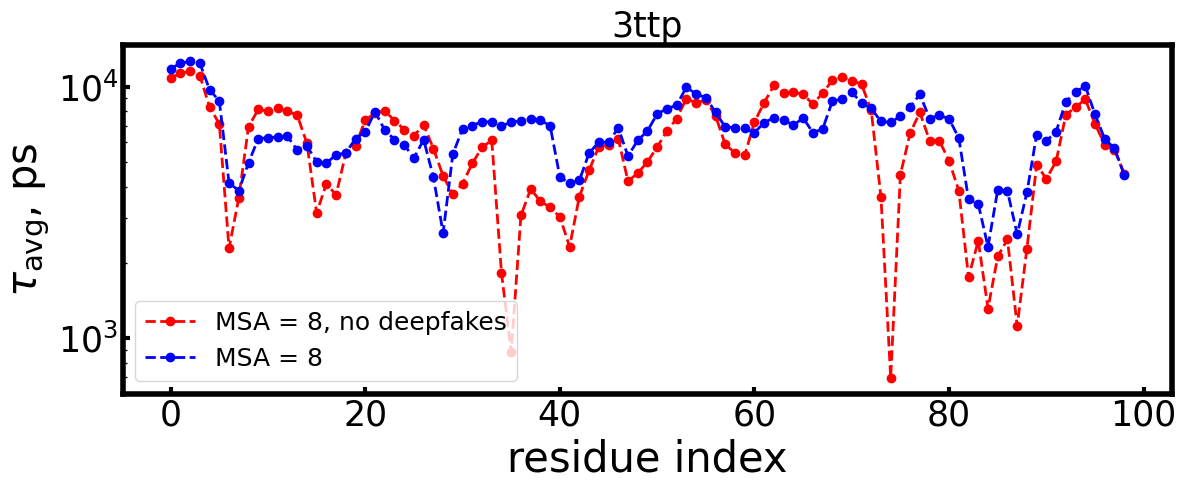

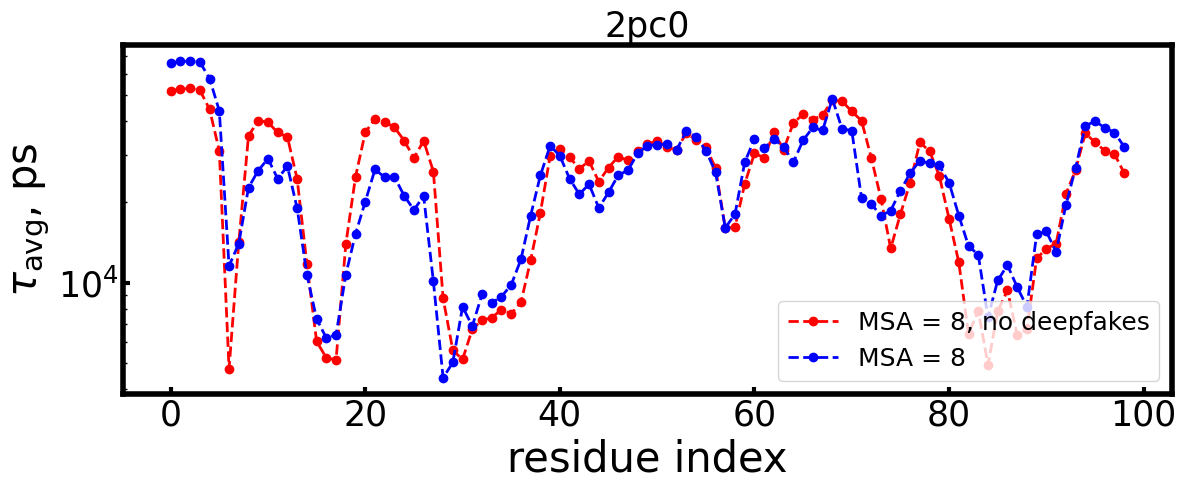

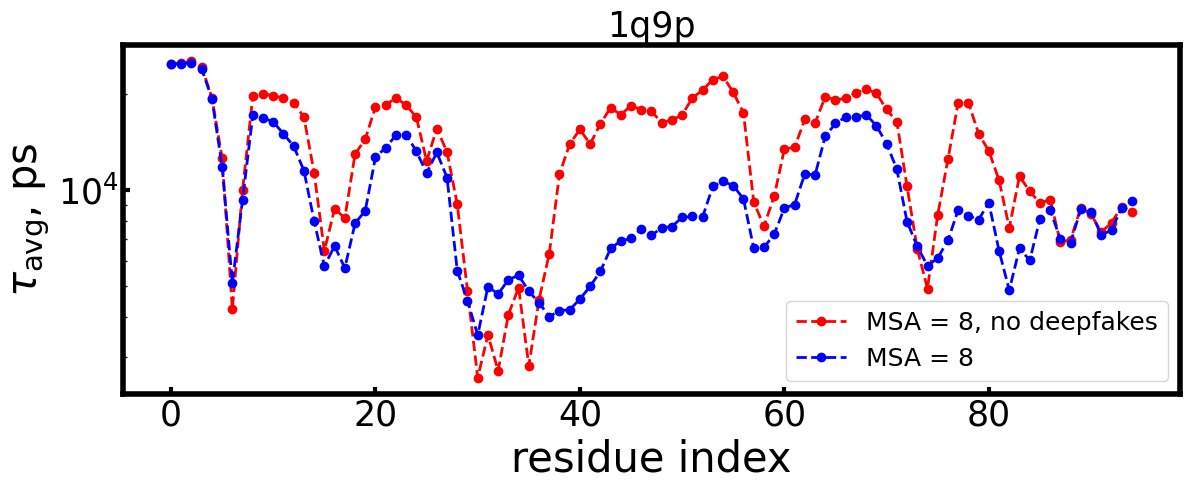

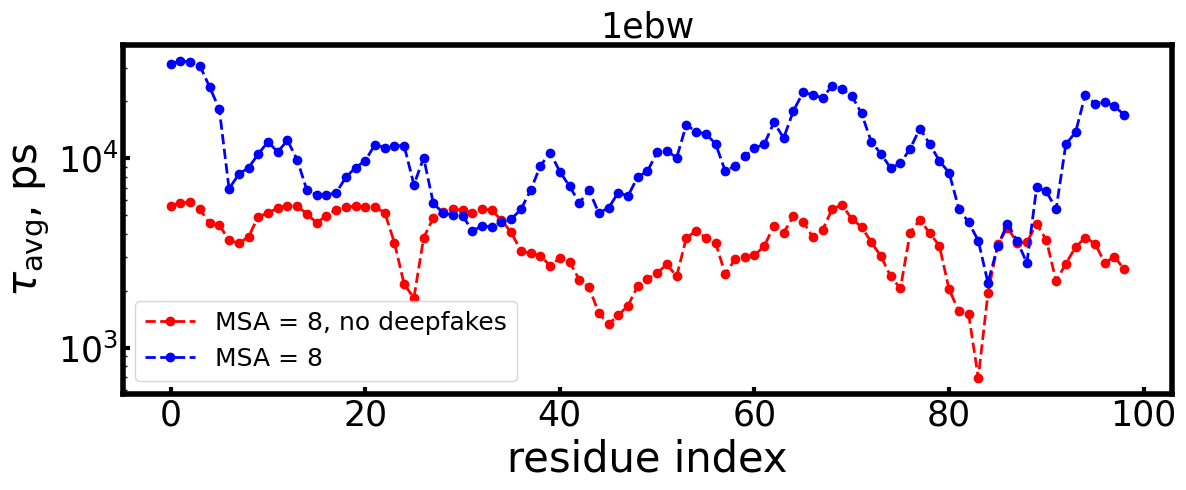

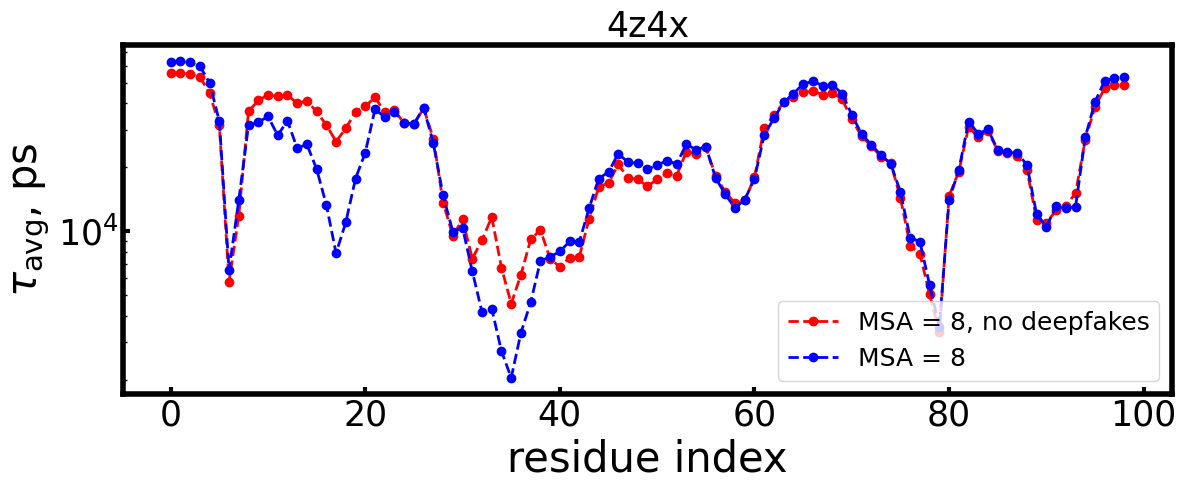

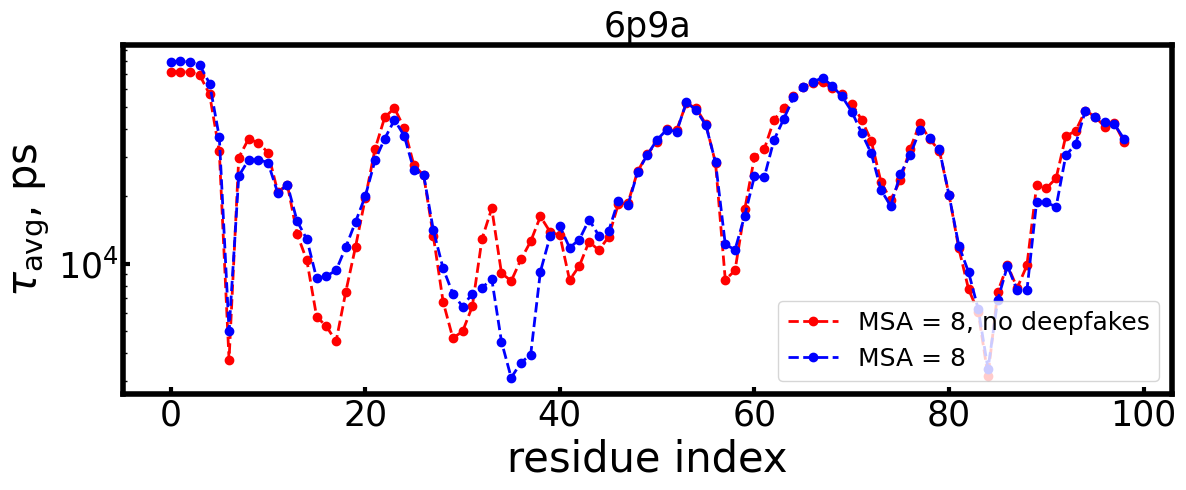

In [344]:
for k in range(len(big_msa8_tau_list)):

    plt.figure(figsize = (12,5))
    plt.title(seq_list[k])
    #plt.plot(df_sim_ttp_tau_list, marker = 'o', lw = 2, ls = '--', c = 'k', label = 'MD')
    plt.plot(big_msa8_tau_list[k], marker = 'o', lw = 2, ls = '--', c = 'r', label = 'MSA = 8, no deepfakes')
    plt.plot(df_big_msa8_tau_list[k], marker = 'o', lw = 2, ls = '--', c = 'b', label = 'MSA = 8')
    #plt.plot(bioemu_q9p_tau_list, marker = 'o', lw = 2, ls = '--', c = 'r', label = 'BioEmu')
    plt.yscale('log')
    plt.ylabel(r'$\tau_{\text{avg}}$, ps')
    plt.xlabel('residue index')
    plt.legend(fontsize = 18)
    plt.tight_layout()
    plt.savefig(f'{seq_list[k]}_8msa_timescales_deepfake_comp.pdf', dpi = 300)
    plt.show()
    plt.close()

3ttp
0 0
2pc0
0 1
1q9p
1 0
1ebw
1 1
4z4x
2 0
6p9a
2 1


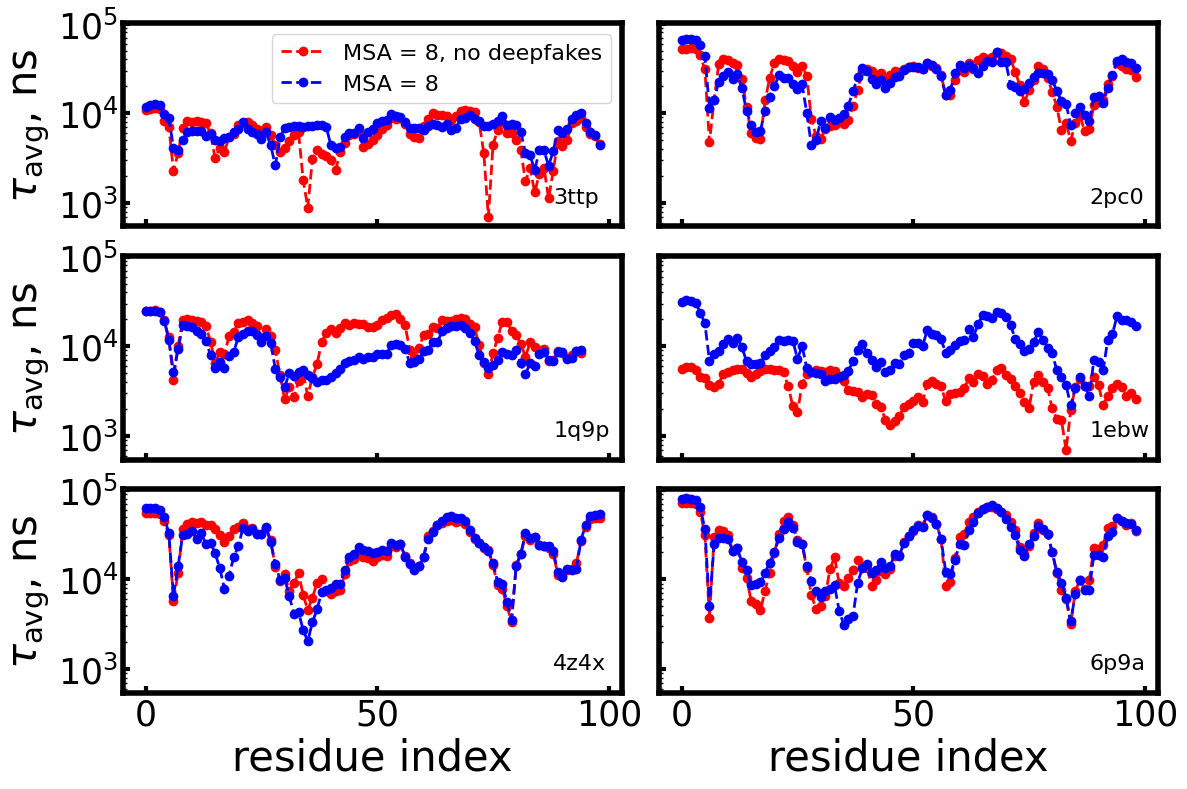

In [345]:
# tile the output in a single plot

# now look at the autocorrelation functions

import os
os.makedirs('tmp_figures', exist_ok = True)
fig, ax = plt.subplots(3, 2, figsize = (12, 8), sharex = True, sharey = True)
for k in range(len(big_HA_scaled_corr_list)):
    seq = seq_list[k]
    print(seq)
    # row 
    i = k // 2
    # column
    j = k % 2

        
    print(i,j)
    ax[i,j].plot(big_msa8_tau_list[k] , marker = 'o', lw = 2, ls = '--', c = 'r', label = 'MSA = 8, no deepfakes')
    ax[i,j].plot(df_big_msa8_tau_list[k] , marker = 'o', lw = 2, ls = '--', c = 'b', label = 'MSA = 8')
    #ax[i,j].plot(t[:len(big_sims_tcf_list[k][n,:])], big_sims_tcf_list[k][n,:], c = 'k', lw = 3, label = 'MD')
    #ax[i,j].plot(t[:len(big_HA_scaled_corr_list[k][0][:,n])], big_HA_scaled_corr_list[k][0][:,n], c = 'r', ls = '--', lw = 3, label = 'msa:8, no deepfakes')
    #ax[i,j].plot(t[:len(df_big_HA_scaled_corr_list[k][0][:,n])], df_big_HA_scaled_corr_list[k][0][:,n], c = 'b', ls = '--', lw = 3, label = 'msa:8')
    #ax[i,j].set_xscale('log')
    ax[i,j].set_yscale('log')
    if i == 2:
        ax[i,j].set_xlabel('residue index')
    if j == 0:
        ax[i,j].set_ylabel(r'$\tau_{\text{avg}}$, ns')
    ax[i,j].text(88, 1e3, seq, fontsize = 16)
    #if i == -2:
    #    plt.title('residue %s' % ((big_HA_scaled_corr_list[k][0]).shape[1] - 1))
    #else:
    #    plt.title('residue %s' % (i + 1))
ax[0,0].legend(fontsize = 16)
plt.tight_layout()
plt.savefig(f'all_tau_deepfake_comp.pdf', dpi = 300)
plt.show()
plt.close()

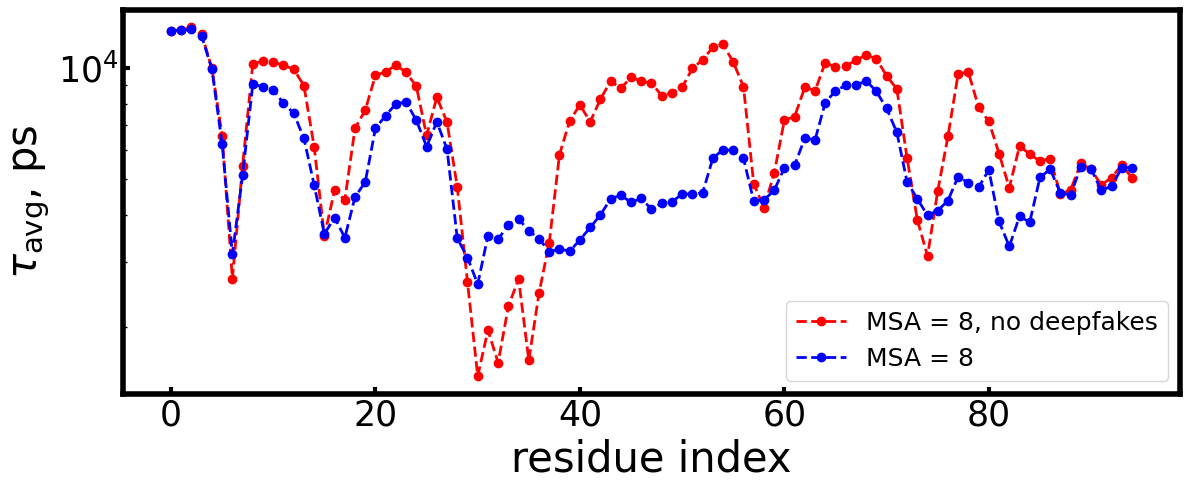

In [249]:
for k in range(len(big_msa8_tau_list)):
    if seq_list[k] == '1q9p':

        plt.figure(figsize = (12,5))
        #plt.title(seq_list[k])
        #plt.plot(df_sim_ttp_tau_list, marker = 'o', lw = 2, ls = '--', c = 'k', label = 'MD')
        plt.plot(big_msa8_tau_list[k], marker = 'o', lw = 2, ls = '--', c = 'r', label = 'MSA = 8, no deepfakes')
        plt.plot(df_big_msa8_tau_list[k], marker = 'o', lw = 2, ls = '--', c = 'b', label = 'MSA = 8')
        #plt.plot(bioemu_q9p_tau_list, marker = 'o', lw = 2, ls = '--', c = 'r', label = 'BioEmu')
        plt.yscale('log')
        plt.ylabel(r'$\tau_{\text{avg}}$, ps')
        plt.xlabel('residue index')
        plt.legend(fontsize = 18)
        plt.tight_layout()
        plt.savefig(f'unlabeled_{seq_list[k]}_8msa_timescales_deepfake_comp.pdf', dpi = 300)
        plt.show()
        plt.close()

/tmp/ipykernel_2483287/3762655086.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 1e6));


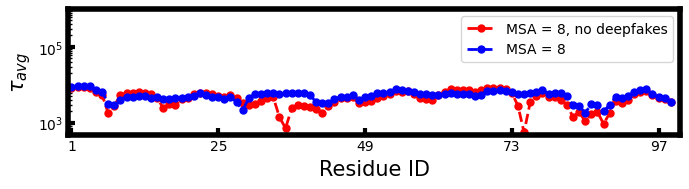

/tmp/ipykernel_2483287/3762655086.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 1e6));


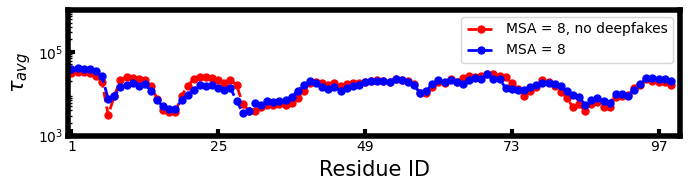

/tmp/ipykernel_2483287/3762655086.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 1e6));


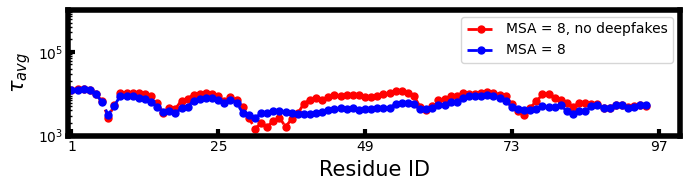

/tmp/ipykernel_2483287/3762655086.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 1e6));


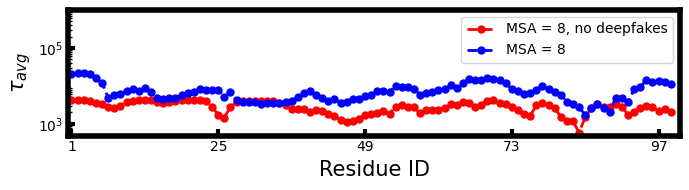

/tmp/ipykernel_2483287/3762655086.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 1e6));


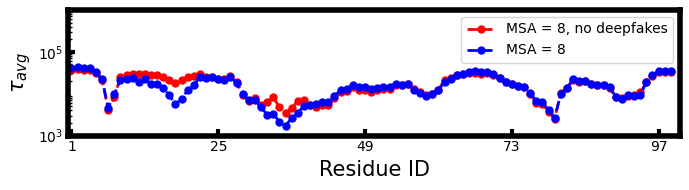

/tmp/ipykernel_2483287/3762655086.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 1e6));


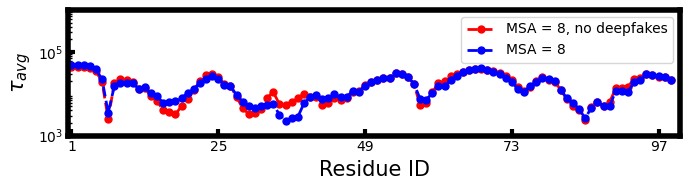

In [159]:
# use Akash's plotting preferences
for k in range(len(big_msa8_tau_list)):

    plt.figure(figsize=(7,2))
    #plt.title(seq_list[k])
    #plt.plot(df_sim_ttp_tau_list, marker = 'o', lw = 2, ls = '--', c = 'k', label = 'MD')
    plt.plot(big_msa8_tau_list[k], marker = 'o', lw = 2, markersize = 5,ls = '--', c = 'r', label = 'MSA = 8, no deepfakes')
    plt.plot(df_big_msa8_tau_list[k], marker = 'o', lw = 2, markersize = 5, ls = '--', c = 'b', label = 'MSA = 8')
    #plt.plot(bioemu_q9p_tau_list, marker = 'o', lw = 2, ls = '--', c = 'r', label = 'BioEmu')
    plt.yscale('log');
    plt.xlim(-0.5,99.5);
    plt.xticks(np.arange(0,99,24),labels=[str(r) for r in range(1,100,24)],fontsize=10);
    plt.xlabel('Residue ID',fontsize=15);
    plt.ylabel(r'$\tau_{avg}$',fontsize=15);
    plt.legend(fontsize=10,loc='upper right');
    plt.ylim((0, 1e6));
    plt.yticks([1e3,1e5],fontsize=10);
    plt.tight_layout();
    #plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/all_mutants_column.pdf',dpi=600);
    #plt.savefig('all_mutants_column.pdf',dpi=600);
    plt.show()

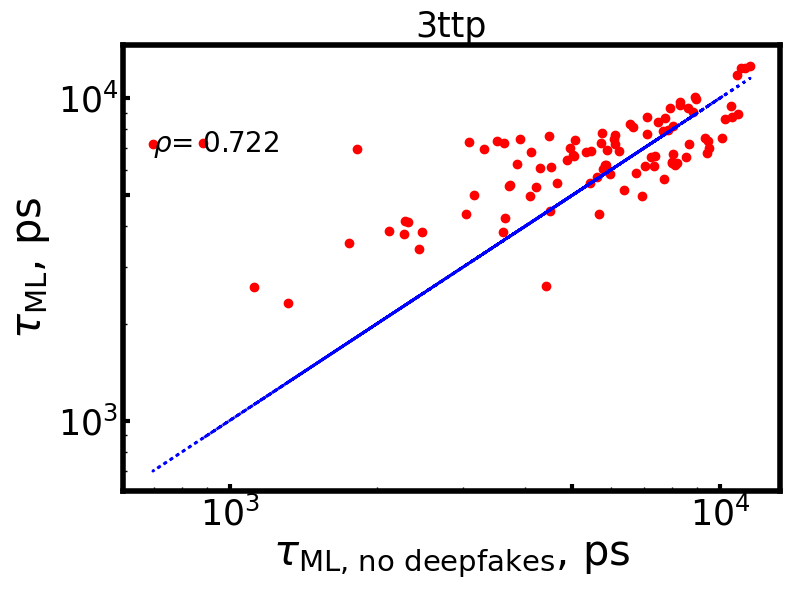

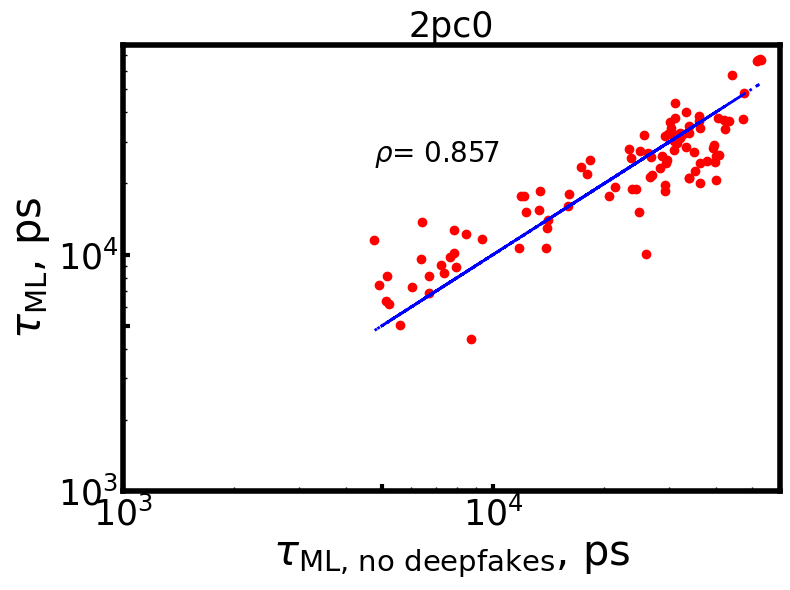

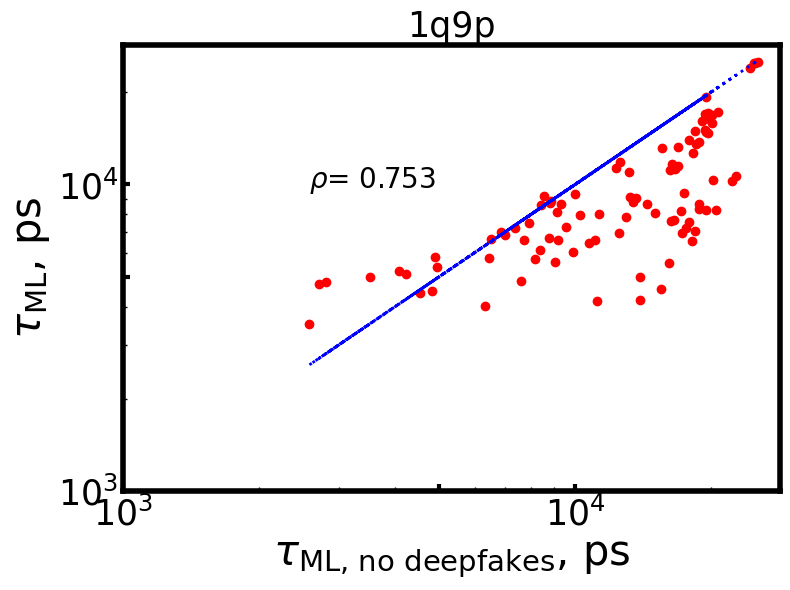

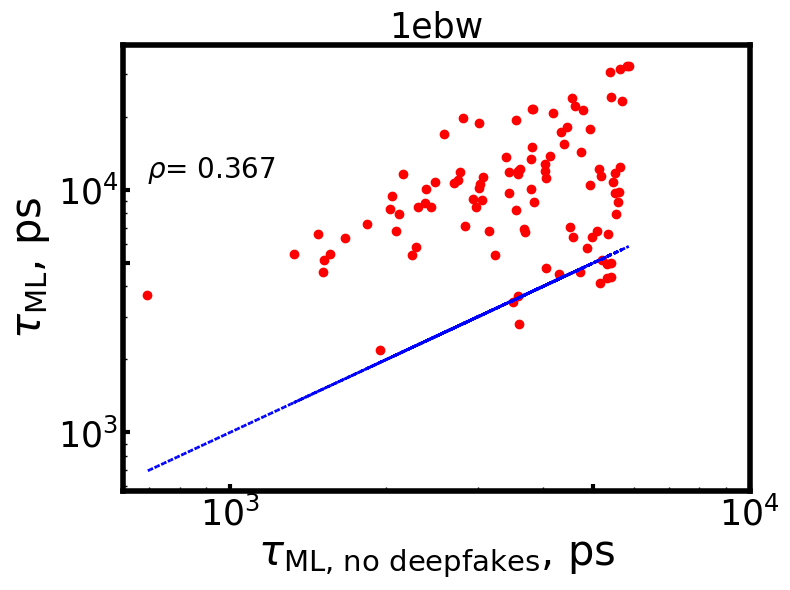

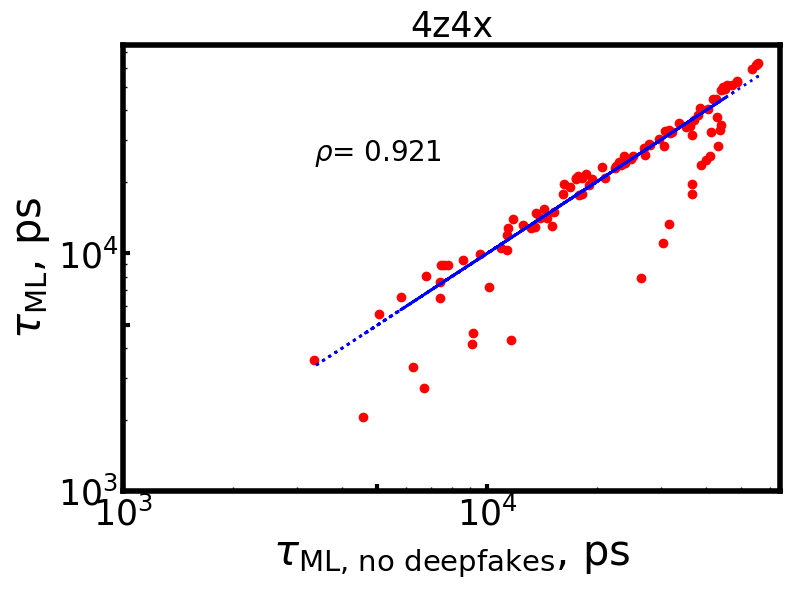

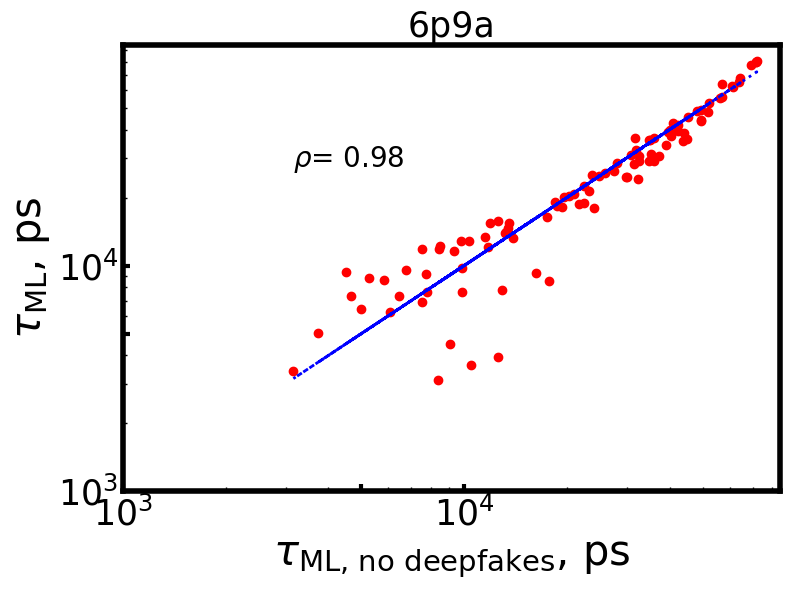

In [346]:
for k, seq in enumerate(seq_list):
    #plt.scatter(sim_ttp_tau_list, msa8_ttp_tau_list, marker = 'o', color = 'k', 
    #            label = rf'3ttp ($\rho={np.round(np.corrcoef(sim_ttp_tau_list, msa8_ttp_tau_list)[1,0], 2)}$)')
    #plt.scatter(sim_pc0_tau_list, msa8_pc0_tau_list, marker = 'o', color = 'b', 
    #            label = rf'2pc0 ($\rho={np.round(np.corrcoef(sim_pc0_tau_list, msa8_pc0_tau_list)[1,0], 2)}$)')
    plt.scatter(big_msa8_tau_list[k], df_big_msa8_tau_list[k], marker = 'o', color = 'r',
                ) #label = rf'($\rho={np.round(np.corrcoef(msa8_q9p_tau_list, df_msa8_q9p_tau_list)[1,0], 2)}$)')
    #plt.plot(sim_ttp_tau_list, sim_ttp_tau_list, lw = 2, ls = ':', color = 'k')
    #plt.plot(sim_pc0_tau_list, sim_pc0_tau_list, lw = 2, ls = ':', color = 'r')
    plt.plot(big_msa8_tau_list[k], big_msa8_tau_list[k], lw = 2, ls = ':', color = 'b')
    plt.yscale('log')
    plt.xscale('log')
    plt.text(np.min(big_msa8_tau_list[k]),np.mean(df_big_msa8_tau_list[k]), 
             r"$\rho$= " + str(np.round(np.corrcoef(big_msa8_tau_list[k], df_big_msa8_tau_list[k])[0,1], 3)),
            fontsize = 20)
    plt.title(seq)
    plt.ylabel(r'$\tau_{\text{ML}}$, ps')
    plt.xlabel(r'$\tau_{\text{ML, no deepfakes}}$, ps')
    plt.xticks([1e3, 5e3, 1e4])
    plt.yticks([1e3, 5e3, 1e4])
    #plt.legend()
    plt.tight_layout()
    plt.savefig(f'{seq}_deepfake_tau_correlation.pdf', dpi = 300)
    plt.show()
    plt.close()

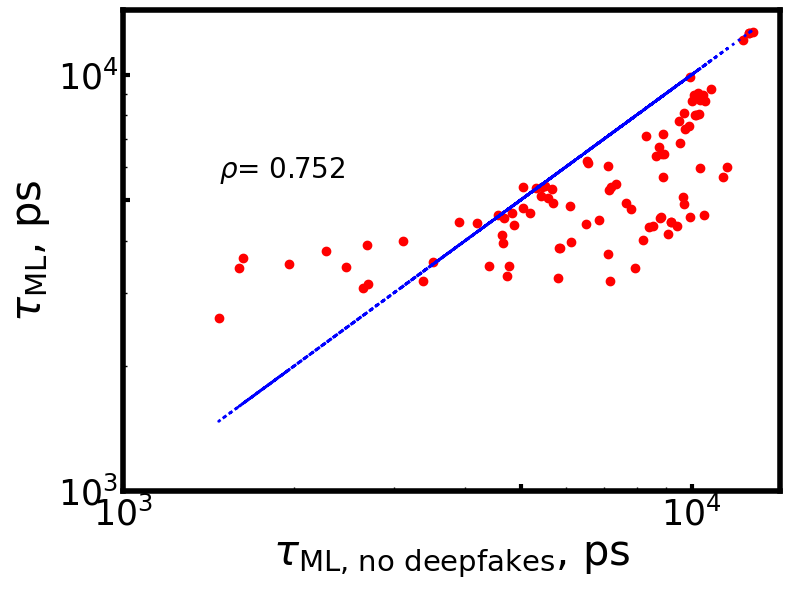

In [247]:
for k, seq in enumerate(seq_list):
    if seq == '1q9p':

        plt.scatter(big_msa8_tau_list[k], df_big_msa8_tau_list[k], marker = 'o', color = 'r',
                    ) #label = rf'($\rho={np.round(np.corrcoef(msa8_q9p_tau_list, df_msa8_q9p_tau_list)[1,0], 2)}$)')

        plt.plot(big_msa8_tau_list[k], big_msa8_tau_list[k], lw = 2, ls = ':', color = 'b')
        plt.yscale('log')
        plt.xscale('log')
        plt.text(np.min(big_msa8_tau_list[k]),np.mean(df_big_msa8_tau_list[k]), 
                 r"$\rho$= " + str(np.round(np.corrcoef(big_msa8_tau_list[k], df_big_msa8_tau_list[k])[0,1], 3)),
                fontsize = 20)
        #plt.title(seq)
        plt.ylabel(r'$\tau_{\text{ML}}$, ps')
        plt.xlabel(r'$\tau_{\text{ML, no deepfakes}}$, ps')
        plt.xticks([1e3, 5e3, 1e4])
        plt.yticks([1e3, 5e3, 1e4])
        #plt.legend()
        plt.tight_layout()
        plt.savefig(f'unlabeled_{seq}_deepfake_tau_correlation.pdf', dpi = 300)
        plt.show()
        plt.close()

In [348]:
big_tau_array = np.array([big_msa8_tau_list[0][:95],
                         big_msa8_tau_list[1][:95],
                         big_msa8_tau_list[2][:95],
                         big_msa8_tau_list[3][:95],
                         big_msa8_tau_list[4][:95],
                         big_msa8_tau_list[5][:95]])

In [349]:
mean95 = big_tau_array.mean(0)
std95 = big_tau_array.std(0)
print(mean95, std95)

[36690.72145296 37046.88754422 37064.98409331 35940.39370432
 29702.04145366 19736.44307733  4081.33221886 12148.26883977
 23061.87874477 24866.13627563 24614.56226228 22248.41356168
 22252.03152158 18017.72515966 14226.19738138 10433.63663998
  9984.23815202  8887.46983425 12633.3941492  16509.47312156
 20933.64977909 24637.45415954 25607.56311662 25644.77229858
 22022.21965294 18180.21137439 20498.75783876 15024.97440011
  7960.12849149  5626.96527651  5588.36319125  5702.13076173
  7184.30802647  8705.61144121  5869.89718705  4724.99950392
  5999.04977456  7871.31299909 10406.66410596 11815.47302022
 12197.885663   10719.29808705 11005.81247845 12864.84086454
 12660.96052134 13748.87908906 15678.03126533 14764.94628934
 16197.41616114 17292.10097766 18644.89249315 19940.39356728
 19906.57561862 24473.61130065 23656.81717789 21969.74614105
 16955.5932654   9543.31761523  9173.55302126 12120.67841818
 16990.95052473 19658.12605677 24409.47190871 25151.37514534
 28697.58495855 30323.35

In [350]:
tau_array = np.array([big_msa8_tau_list[0][95:],
                         big_msa8_tau_list[1][95:],
                         big_msa8_tau_list[3][95:],
                         big_msa8_tau_list[4][95:],
                         big_msa8_tau_list[5][95:]])

In [351]:
mean4 = tau_array.mean(0)
std4 = tau_array.std(0)
print(mean4, std4)

[25586.01336719 25548.8845787  25966.93059029 23246.83476686] [17013.89728412 18098.42024791 18678.81317987 17713.77121076]


In [352]:
mean_taus = np.concatenate([mean95, mean4])
std_taus = np.concatenate([std95, std4])

In [353]:
idx = np.argsort(mean_taus)

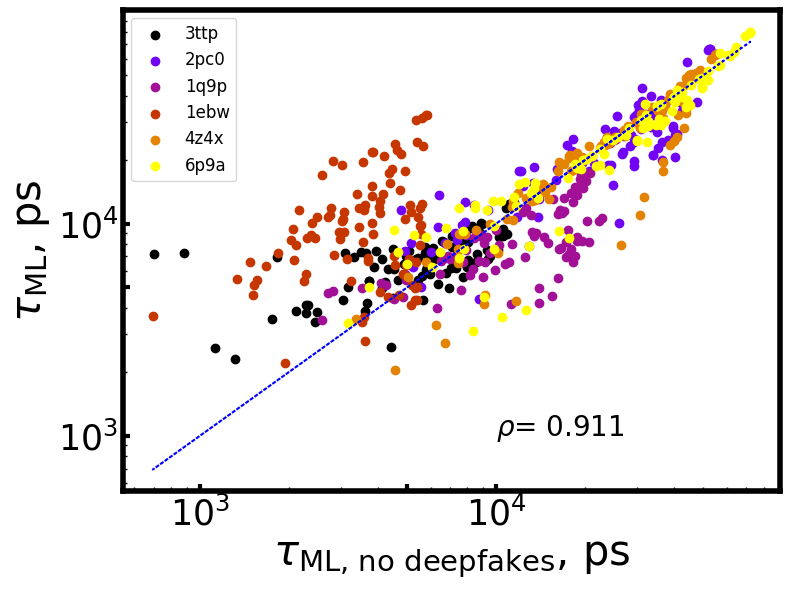

In [354]:
#plt.fill_between(np.sort(mean_taus), np.sort(mean_taus) - std_taus[idx], np.sort(mean_taus) + std_taus[idx], alpha = 0.5, color = 'b')
#plt.plot(mean_taus, mean_taus, c = 'b')
plt.plot(np.concatenate(big_msa8_tau_list), np.concatenate(big_msa8_tau_list), ls = ':', c = 'b')
for k in range(len(big_msa8_tau_list)):
    plt.scatter(big_msa8_tau_list[k], df_big_msa8_tau_list[k], marker = 'o', color = color_list[k], label = seq_list[k])

plt.yscale('log')
plt.xscale('log')
plt.text(1e4, 1e3, 
         r"$\rho$= " + str(np.round(np.corrcoef(np.concatenate(big_msa8_tau_list), np.concatenate(df_big_msa8_tau_list))[0,1], 3)),
        fontsize = 20)
#plt.title(seq)
plt.ylabel(r'$\tau_{\text{ML}}$, ps')
plt.xlabel(r'$\tau_{\text{ML, no deepfakes}}$, ps')
plt.xticks([1e3, 5e3, 1e4])
plt.yticks([1e3, 5e3, 1e4])
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig(f'all_sequences_deepfake_tau_correlation.pdf', dpi = 300)
plt.show()
plt.close()


3ttp


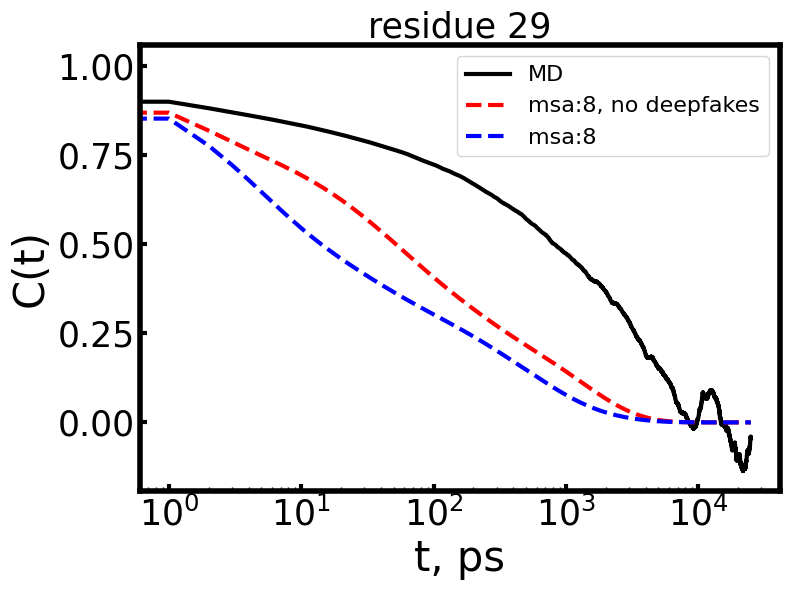

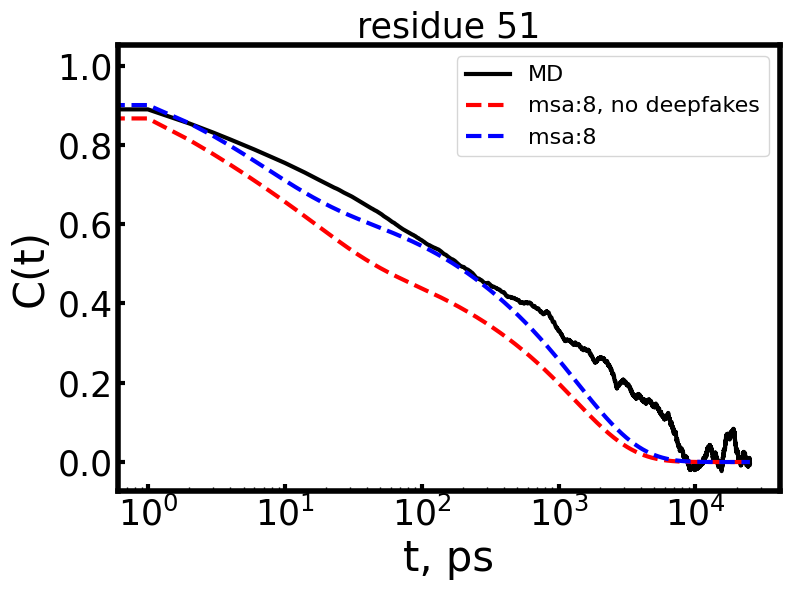

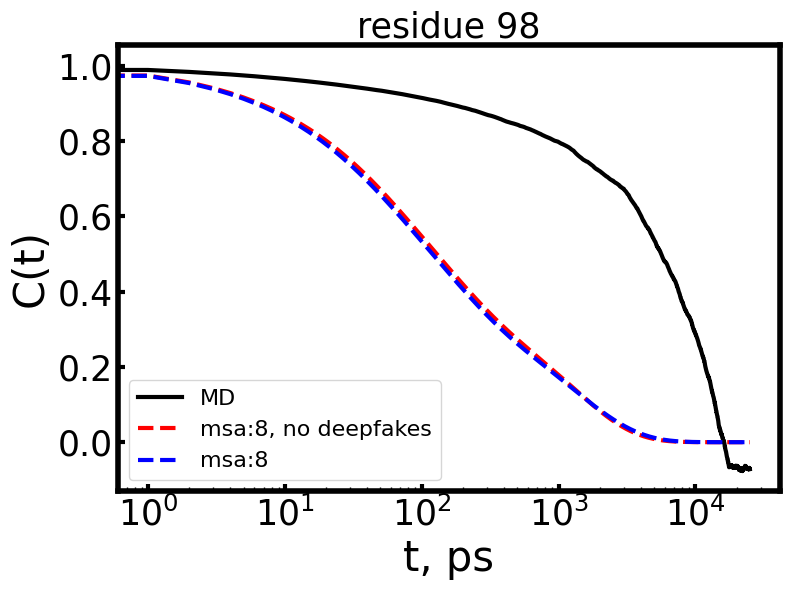

2pc0


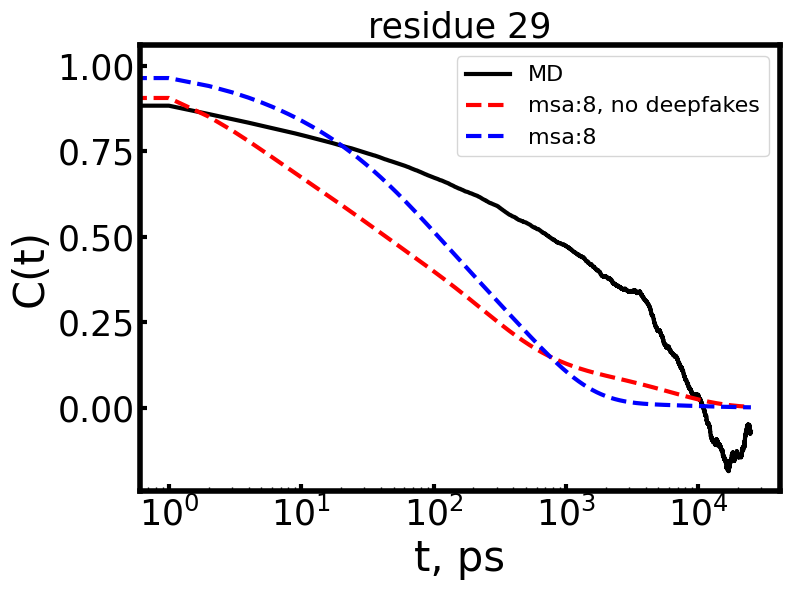

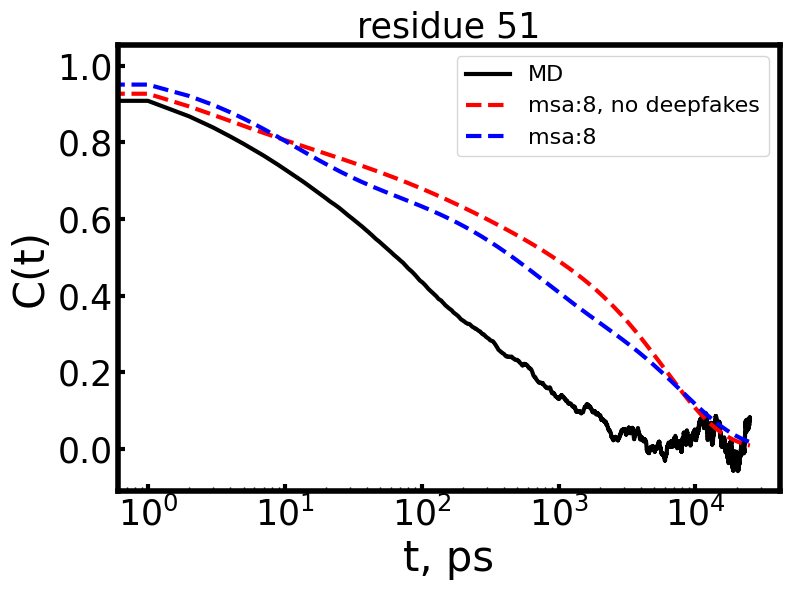

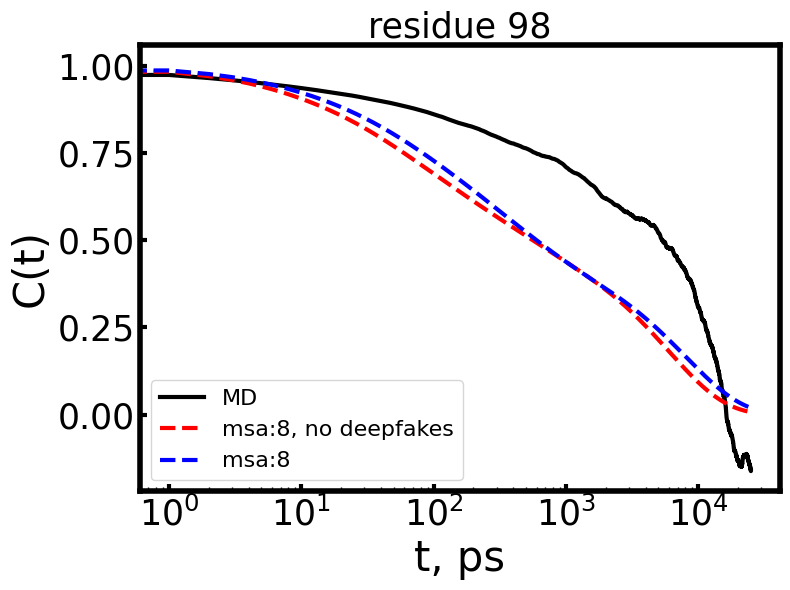

1q9p


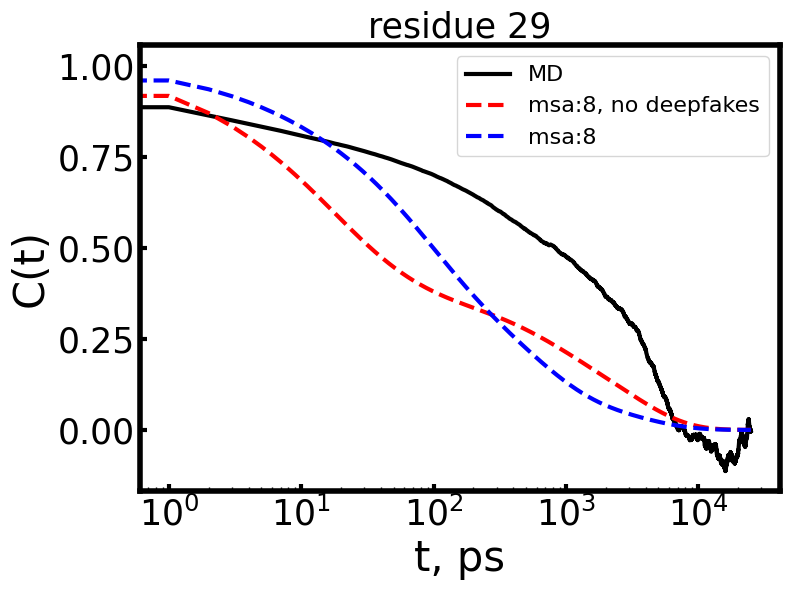

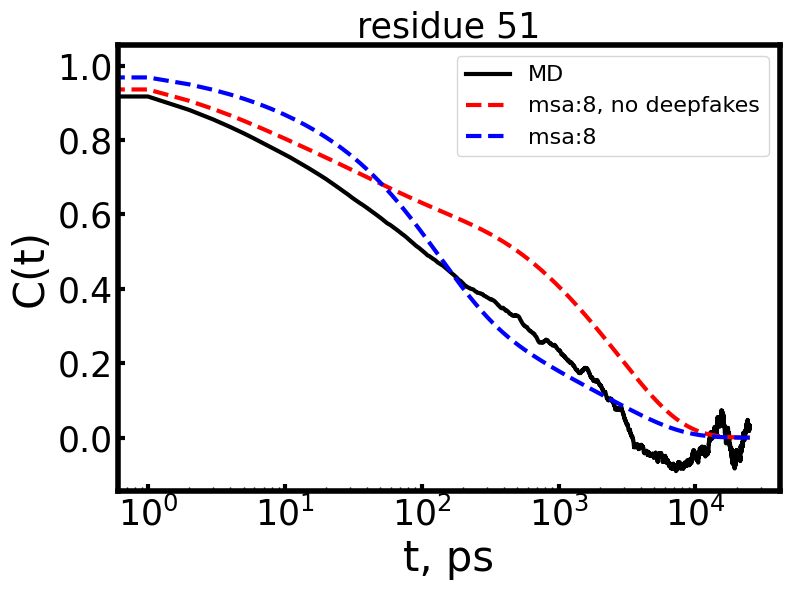

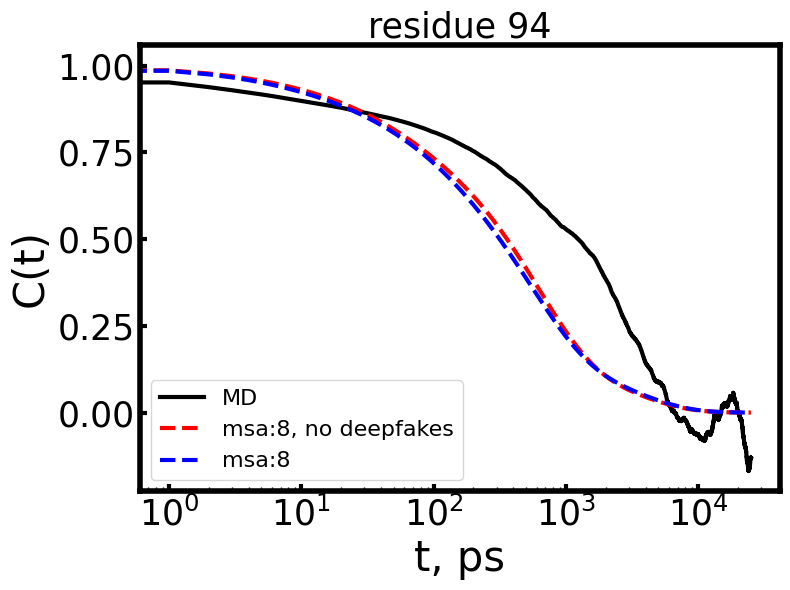

1ebw


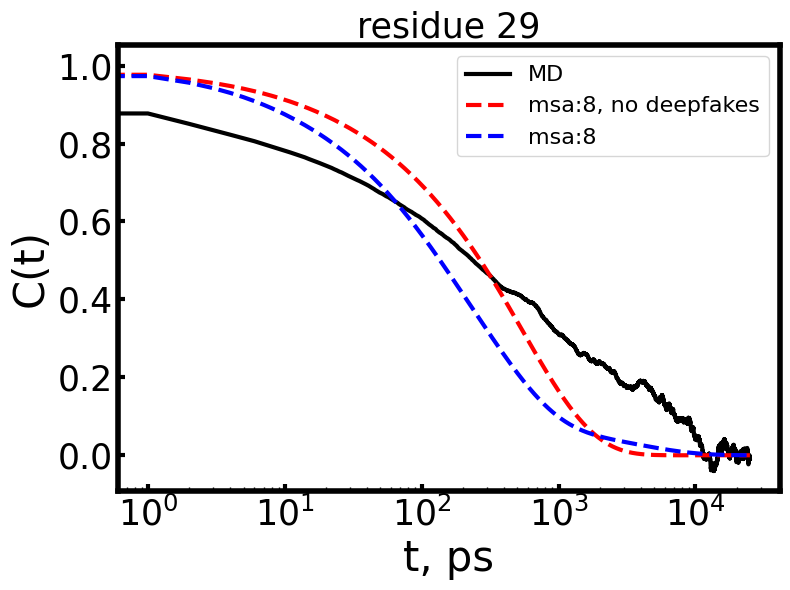

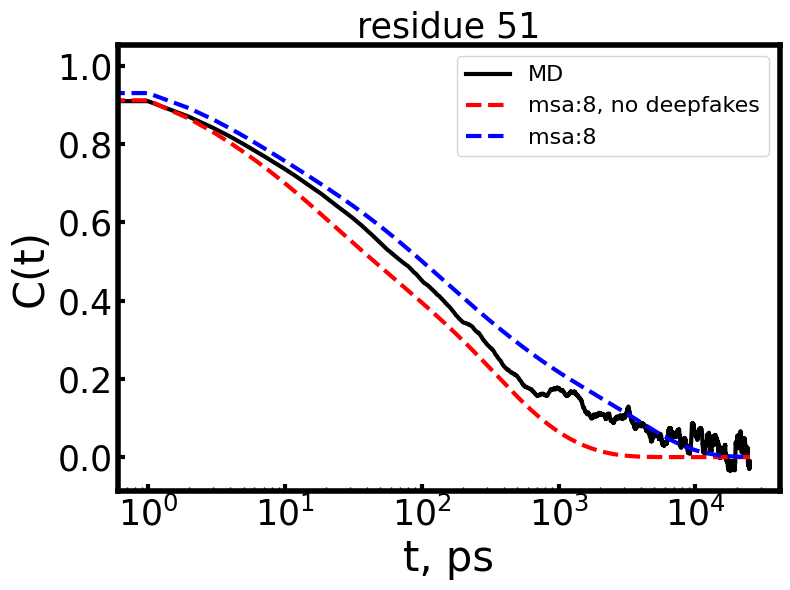

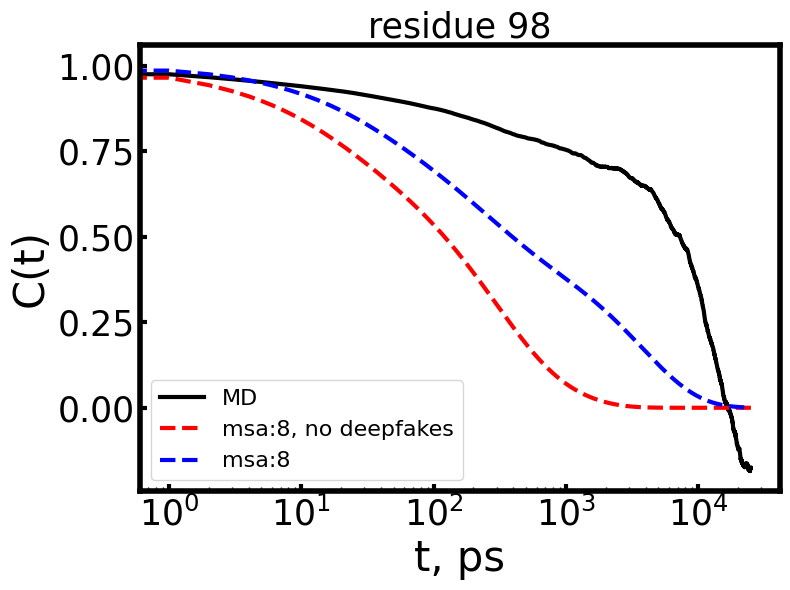

4z4x


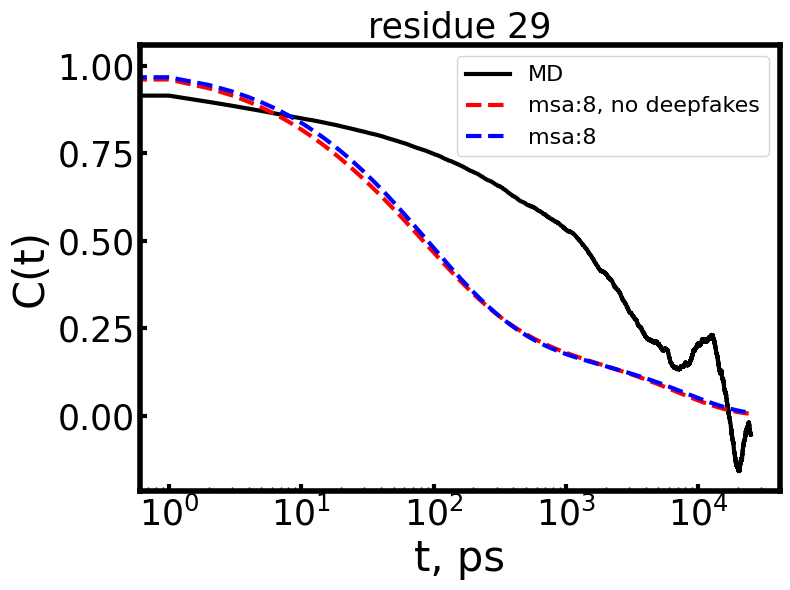

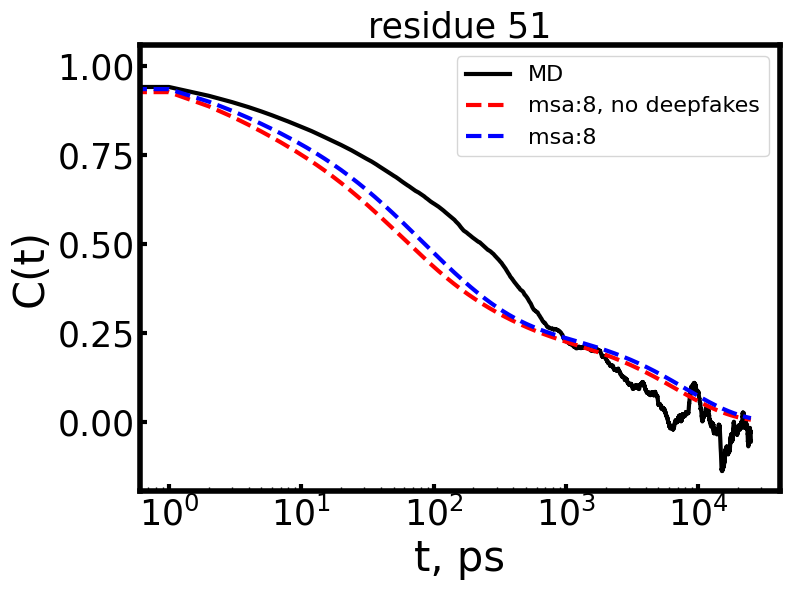

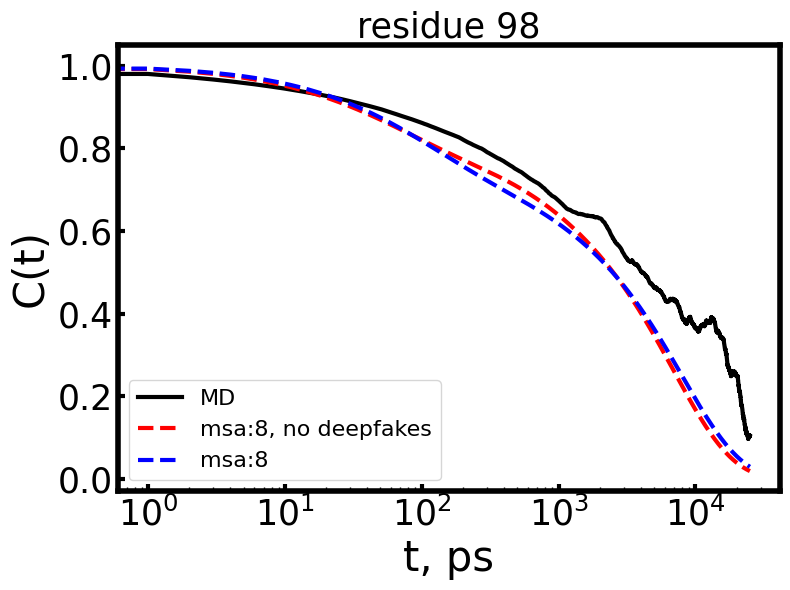

6p9a


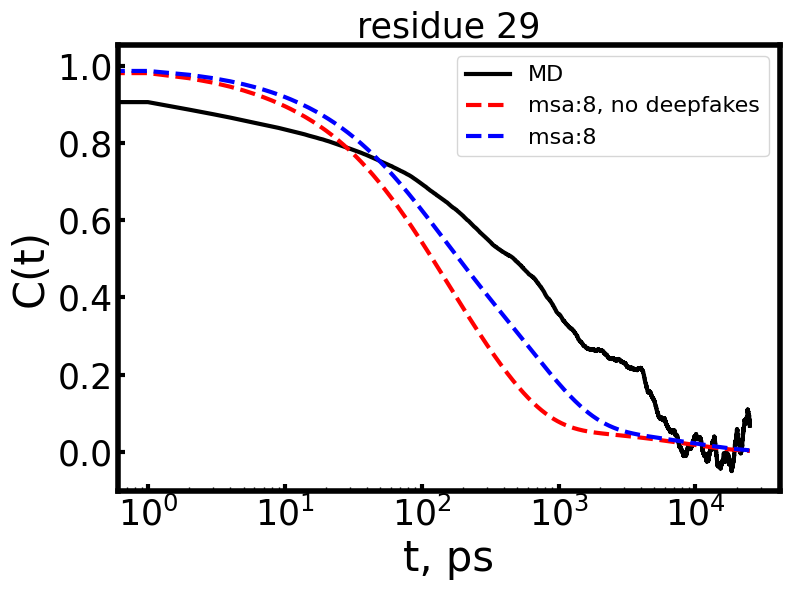

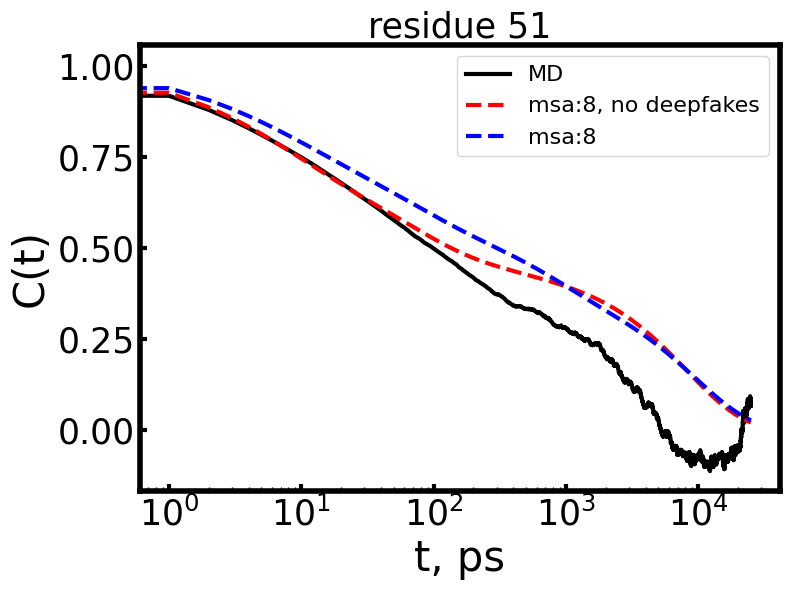

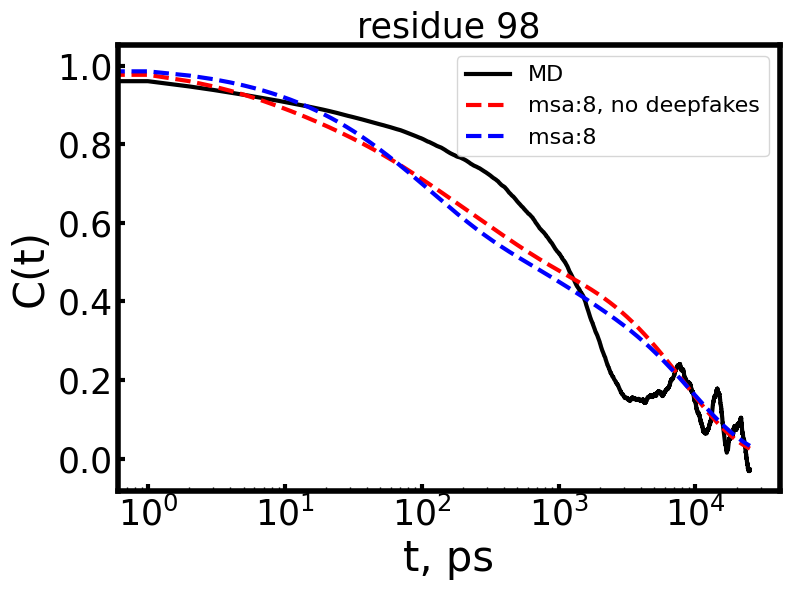

In [359]:
# now look at the autocorrelation functions

import os
os.makedirs('tmp_figures', exist_ok = True)
for k in range(len(big_HA_scaled_corr_list)):
    seq = seq_list[k]
    print(seq)
    for i in [28, 50, -2]:
        plt.plot(big_sims_tcf_list[k][i,:], c = 'k', lw = 3, label = 'MD')
        plt.plot(big_HA_scaled_corr_list[k][0][:,i], c = 'r', ls = '--', lw = 3, label = 'msa:8, no deepfakes')
        plt.plot(df_big_HA_scaled_corr_list[k][0][:,i], c = 'b', ls = '--', lw = 3, label = 'msa:8')
        plt.xscale('log')
        plt.xlabel('t, ps')
        plt.ylabel('C(t)')
        if i == -2:
            plt.title('residue %s' % ((big_HA_scaled_corr_list[k][0]).shape[1] - 1))
        else:
            plt.title('residue %s' % (i + 1))
        plt.legend(fontsize = 16)
        plt.tight_layout()
        plt.savefig(f'tmp_figures/{seq}_tcf%s.pdf' % (i + 1), dpi = 300)
        plt.show()
        plt.close()

3ttp
0 0
2pc0
0 1
1q9p
1 0
1ebw
1 1
4z4x
2 0
6p9a
2 1


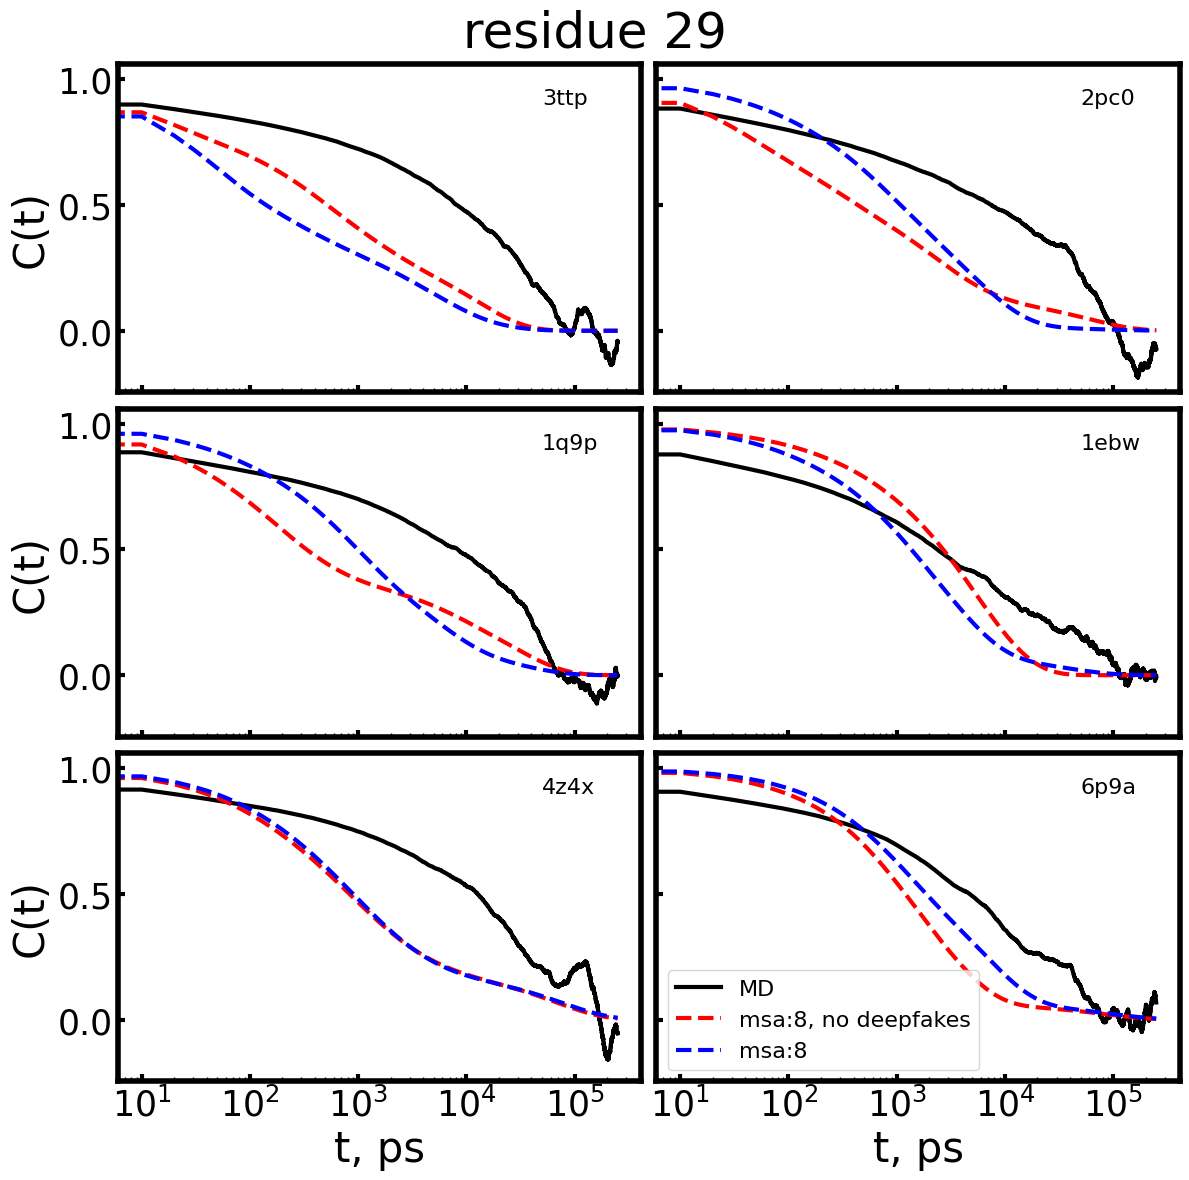

3ttp
0 0
2pc0
0 1
1q9p
1 0
1ebw
1 1
4z4x
2 0
6p9a
2 1


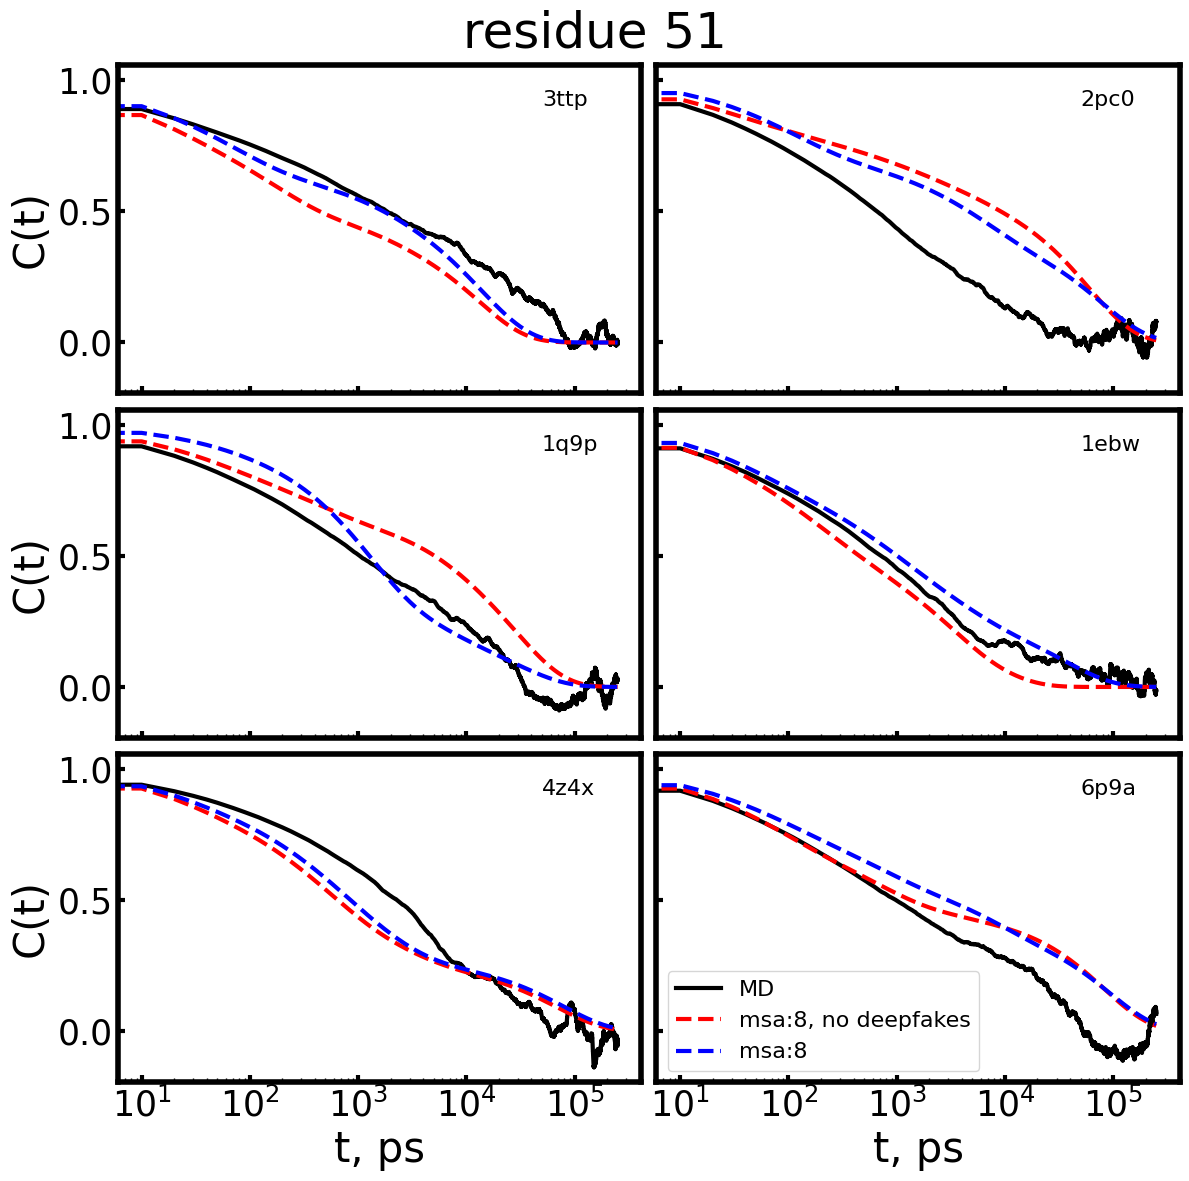

3ttp
0 0
2pc0
0 1
1q9p
1 0
1ebw
1 1
4z4x
2 0
6p9a
2 1


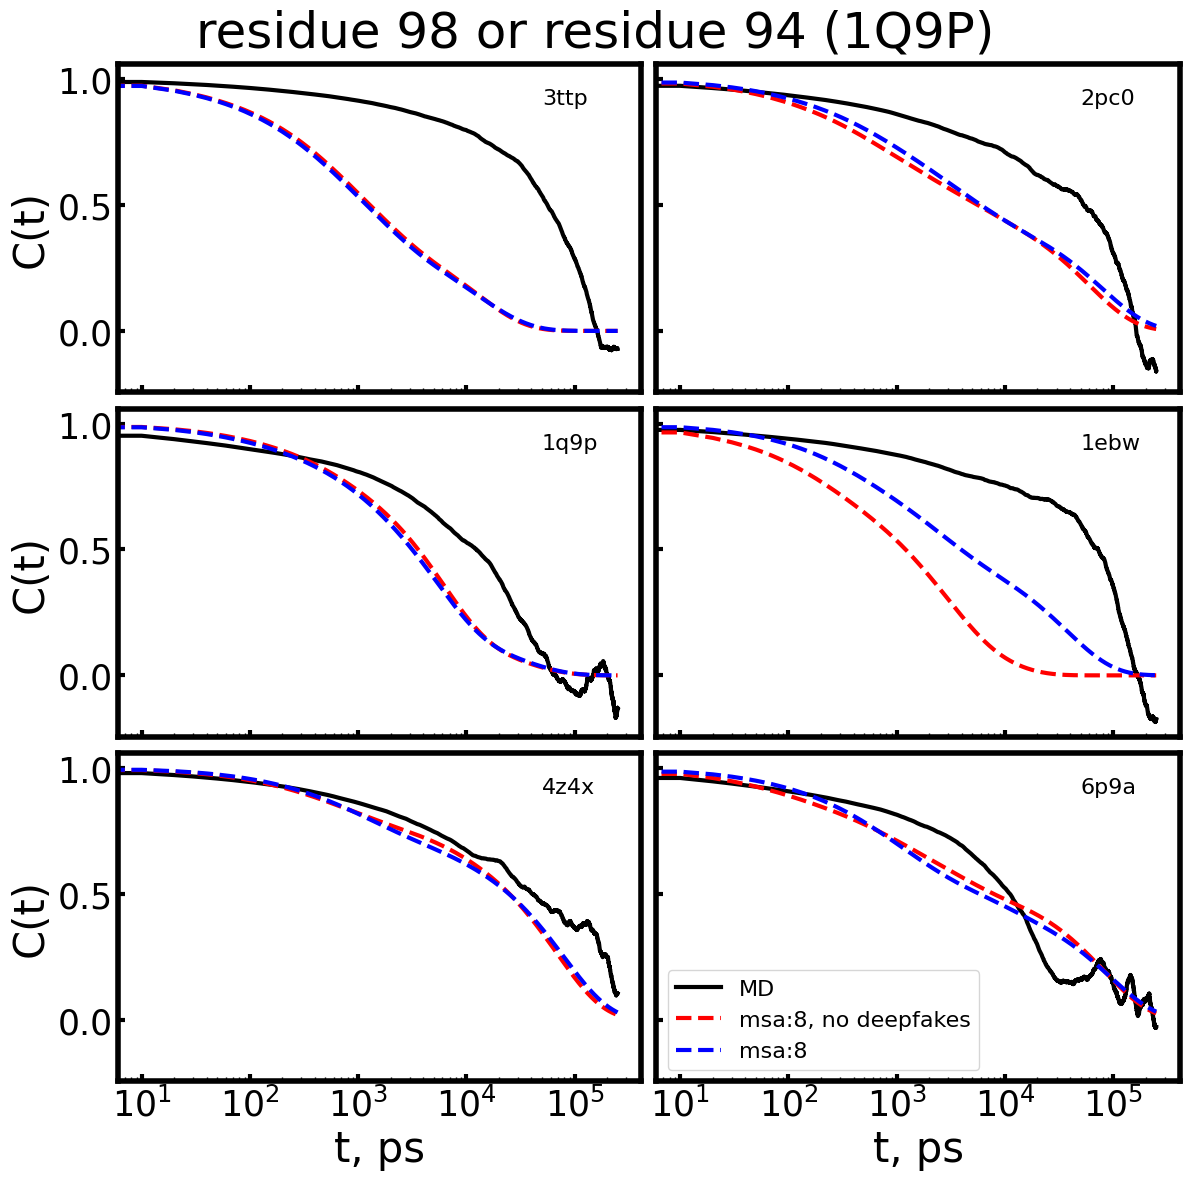

In [355]:
# now look at the autocorrelation functions

import os
os.makedirs('tmp_figures', exist_ok = True)
for n in [28, 50, -2]:
    fig, ax = plt.subplots(3, 2, figsize = (12, 12), sharex = True, sharey = True)
    if n > 0:
        fig.suptitle(f'residue {n + 1}', fontsize = 36)
    else:
        fig.suptitle(f'residue 98 or residue 94 (1Q9P)', fontsize = 36)
    for k in range(len(big_HA_scaled_corr_list)):
        seq = seq_list[k]
        print(seq)
        # row 
        i = k // 2
        # column
        j = k % 2

            
        print(i,j)
        ax[i,j].plot(t[:len(big_sims_tcf_list[k][n,:])], big_sims_tcf_list[k][n,:], c = 'k', lw = 3, label = 'MD')
        ax[i,j].plot(t[:len(big_HA_scaled_corr_list[k][0][:,n])], big_HA_scaled_corr_list[k][0][:,n], c = 'r', ls = '--', lw = 3, label = 'msa:8, no deepfakes')
        ax[i,j].plot(t[:len(df_big_HA_scaled_corr_list[k][0][:,n])], df_big_HA_scaled_corr_list[k][0][:,n], c = 'b', ls = '--', lw = 3, label = 'msa:8')
        ax[i,j].set_xscale('log')
        if i == 2:
            ax[i,j].set_xlabel('t, ps')
        if j == 0:
            ax[i,j].set_ylabel('C(t)')
        ax[i,j].text(5e4, 0.9, seq, fontsize = 16)
        #if i == -2:
        #    plt.title('residue %s' % ((big_HA_scaled_corr_list[k][0]).shape[1] - 1))
        #else:
        #    plt.title('residue %s' % (i + 1))
    ax[i,j].legend(fontsize = 16)
    plt.tight_layout()
    plt.savefig(f'tmp_figures/square_tcf%s.pdf' % (n + 1), dpi = 300)
    plt.show()
    plt.close()

In [356]:
color_list = plt.cm.gnuplot(np.linspace(0,1,len(big_HA_scaled_corr_list)))

3ttp
2pc0
1q9p
1ebw
4z4x
6p9a


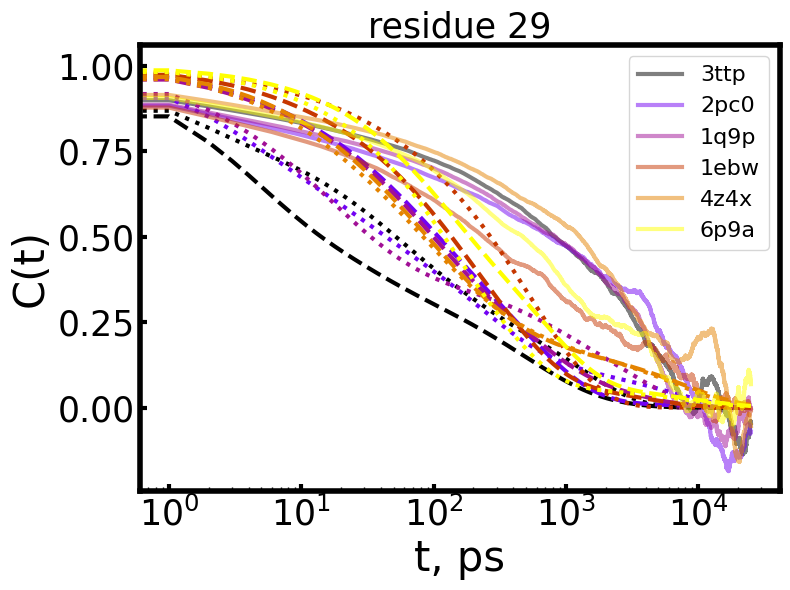

3ttp
2pc0
1q9p
1ebw
4z4x
6p9a


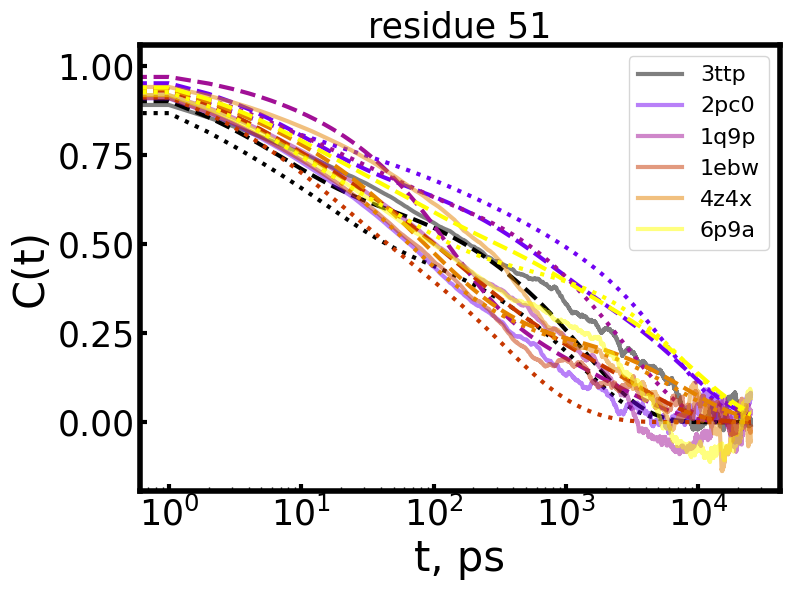

3ttp
2pc0
1q9p
1ebw
4z4x
6p9a


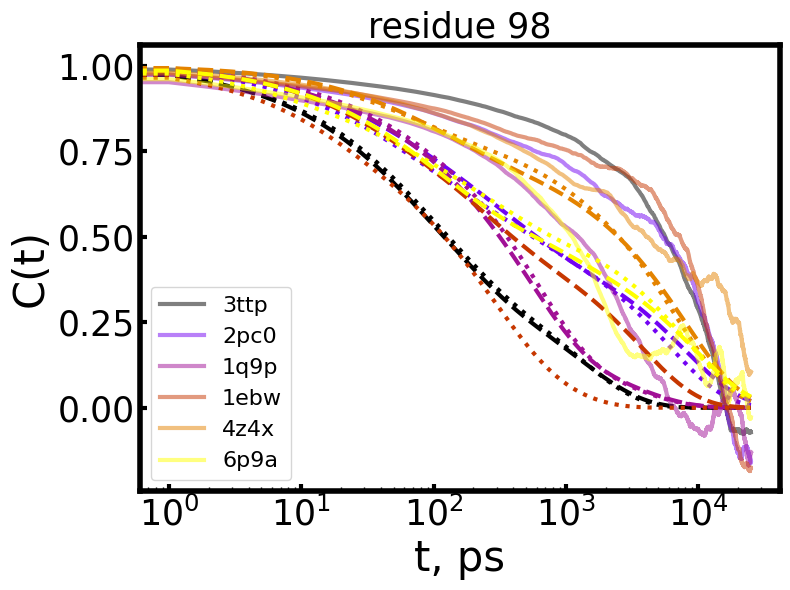

In [357]:
# now look at the autocorrelation functions

import os
os.makedirs('tmp_figures', exist_ok = True)
for i in [28, 50, -2]:
    for k in range(len(big_HA_scaled_corr_list)):
        seq = seq_list[k]
        print(seq)
        plt.plot(big_sims_tcf_list[k][i,:], c = color_list[k], lw = 3, label = seq, alpha = 0.5)
        plt.plot(df_big_HA_scaled_corr_list[k][0][:,i], c = color_list[k], ls = '--', lw = 3)
        plt.plot(big_HA_scaled_corr_list[k][0][:,i], c = color_list[k], ls = ':', lw = 3)
        
    plt.xscale('log')
    plt.xlabel('t, ps')
    plt.ylabel('C(t)')
    if i == -2:
        plt.title('residue %s' % ((big_HA_scaled_corr_list[k][0]).shape[1] - 1))
    else:
        plt.title('residue %s' % (i + 1))
    plt.legend(fontsize = 16)
    plt.tight_layout()
    #plt.savefig(f'tmp_figures/{seq}_tcf%s.pdf' % (i + 1), dpi = 300)
    plt.show()
    plt.close()

In [358]:
# load the RMSF pickle file
import pickle
data_prefix = '../calculated_data/'
with open(f'{data_prefix}RMSF_eric.pkl','rb') as f:
    tmp0=pickle.load(f)

with open(f'{data_prefix}RMSF_mdtraj.pkl','rb') as f:
    tmp1=pickle.load(f)

In [177]:
rmsf_dict = tmp0 | tmp1; print(rmsf_dict.keys())

dict_keys(['3ttp', '2pc0', '1q9p', '1ebw', '4z4x', '6p9a'])


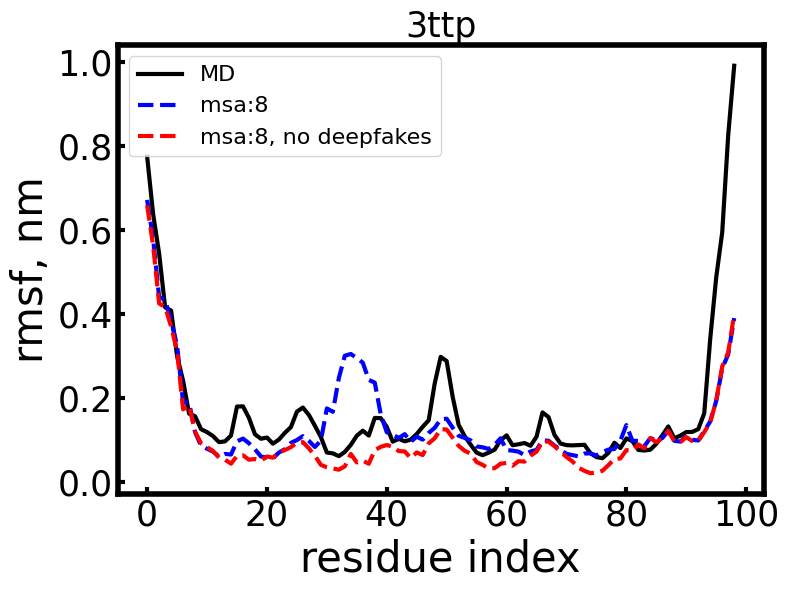

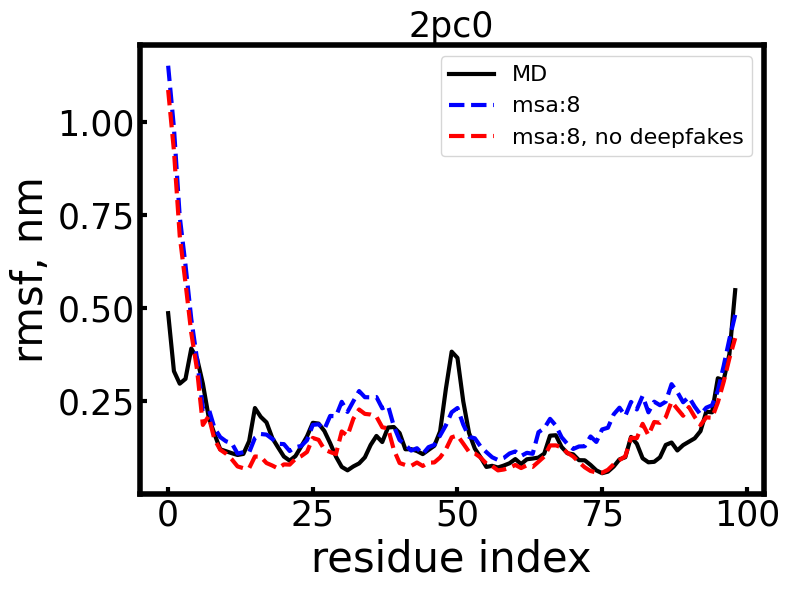

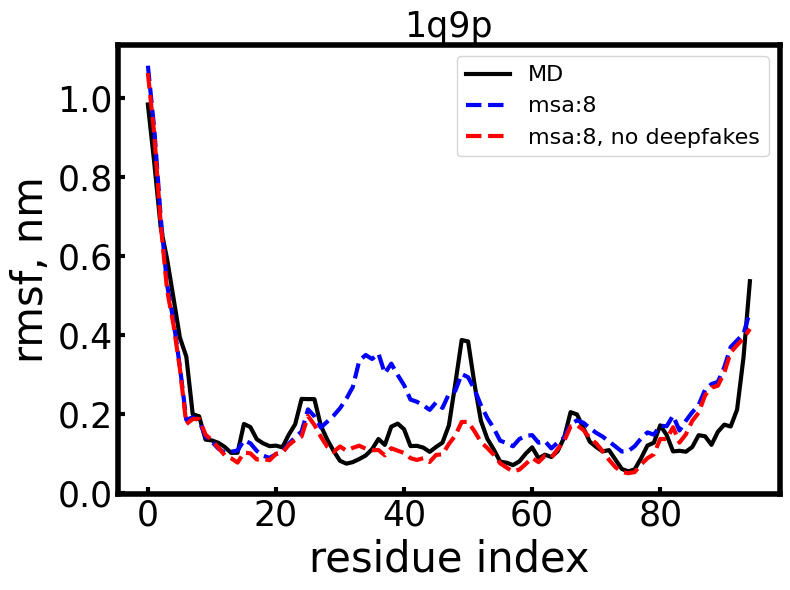

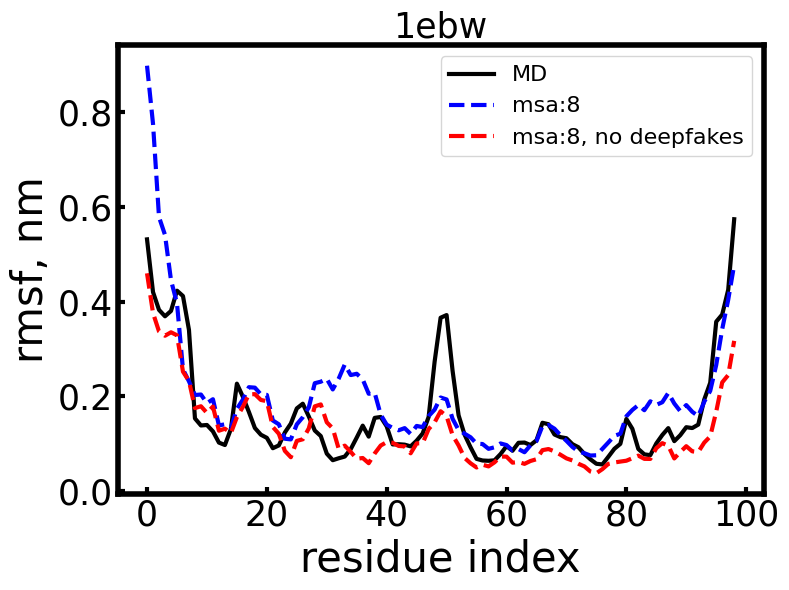

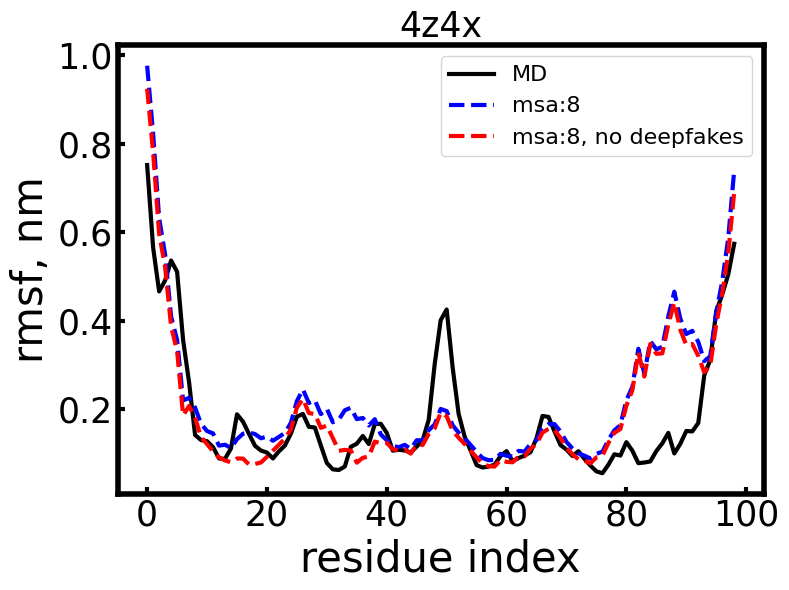

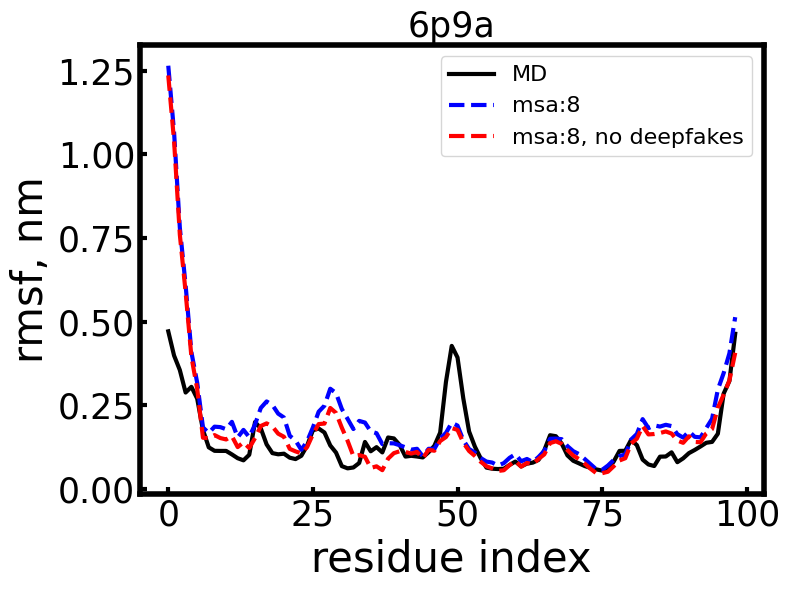

In [181]:
for k, seq in enumerate(seq_list):
    plt.plot(rmsf_dict[seq]['MD']['RMSF'], lw = 3, c = 'k', label = 'MD')
    plt.plot(df_rmsf_list[k], lw = 3, c = 'b', ls = '--', label = 'msa:8')
    plt.plot(rmsf_list[k], lw = 3, c = 'r', ls = '--', label = 'msa:8, no deepfakes')
    plt.legend(fontsize = 16)
    plt.xlabel('residue index')
    plt.ylabel('rmsf, nm')
    plt.title(seq)
    plt.tight_layout()
    plt.savefig(f'rmsf_comp_deepfakes_{seq}.pdf', dpi = 300)
    plt.show()
    plt.close()

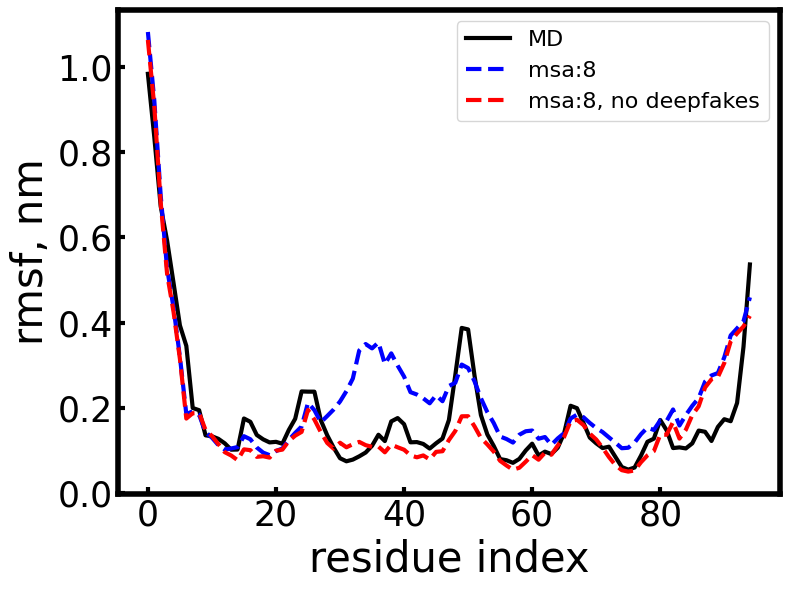

In [242]:
for k, seq in enumerate(seq_list):
    if seq == '1q9p':
        plt.plot(rmsf_dict[seq]['MD']['RMSF'], lw = 3, c = 'k', label = 'MD')
        plt.plot(df_rmsf_list[k], lw = 3, c = 'b', ls = '--', label = 'msa:8')
        plt.plot(rmsf_list[k], lw = 3, c = 'r', ls = '--', label = 'msa:8, no deepfakes')
        plt.legend(fontsize = 16)
        plt.xlabel('residue index')
        plt.ylabel('rmsf, nm')
        #plt.title(seq)
        plt.tight_layout()
        plt.savefig(f'unlabeled_rmsf_comp_deepfakes_{seq}.pdf', dpi = 300)
        plt.show()
        plt.close()

In [64]:
Q = np.load('../sims/openmm/1q9p/Qmatrix.npy')
mu = np.loadtxt('../sims/openmm/1q9p/mu_eig')

In [69]:
weights = ((Q[::3,:-6]**2 + Q[1::3,:-6]**2 + Q[2::3,:-6]**2) * mu[None,:-6]) / mu[:-6].sum()

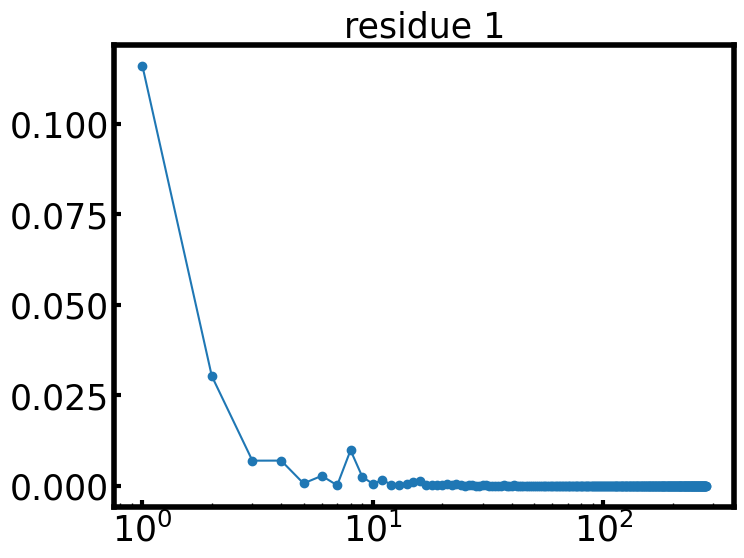

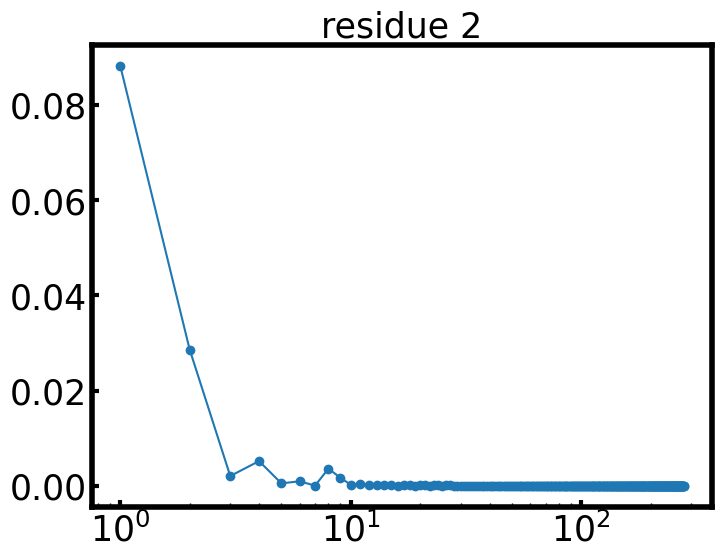

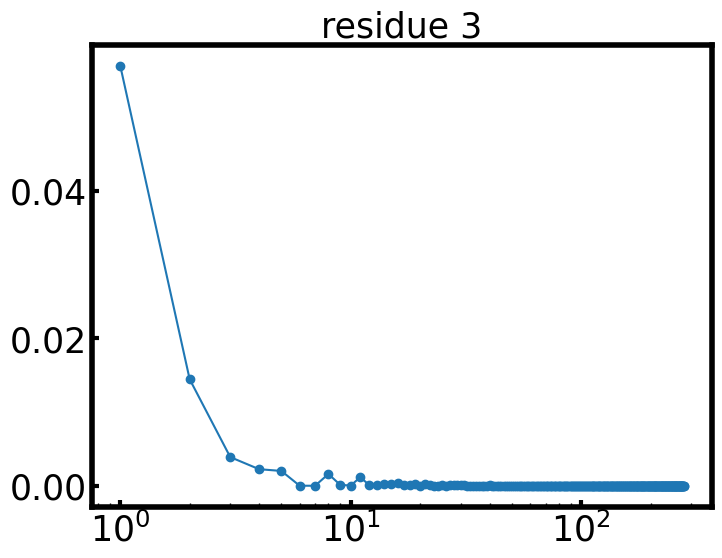

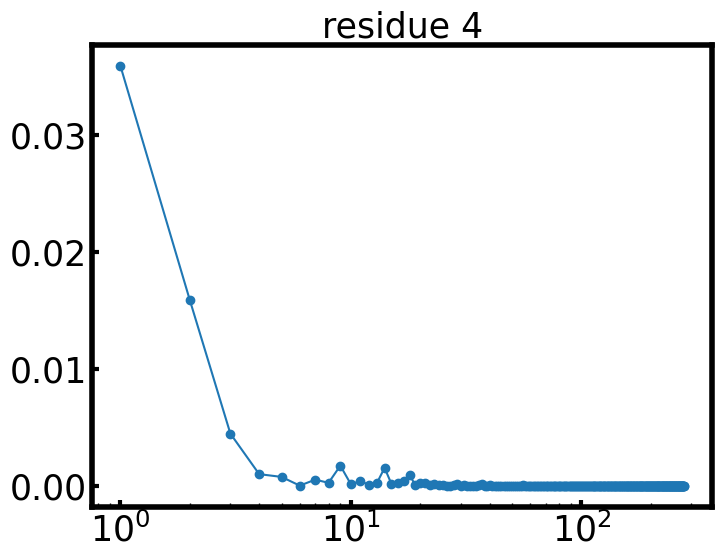

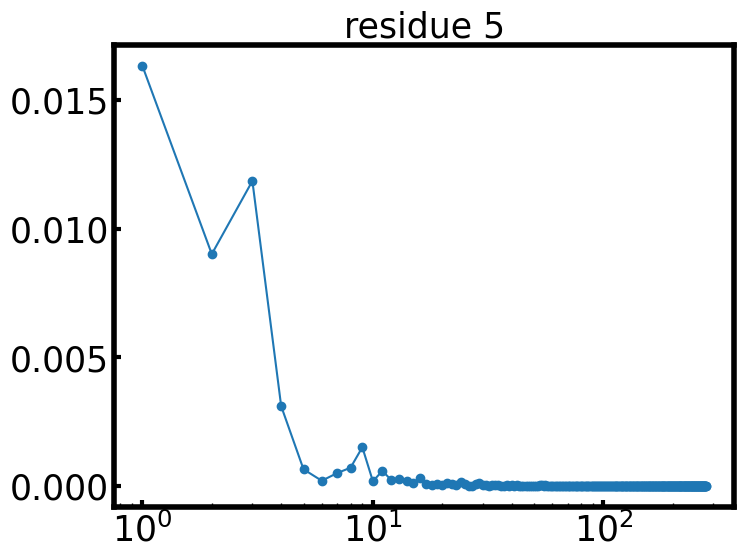

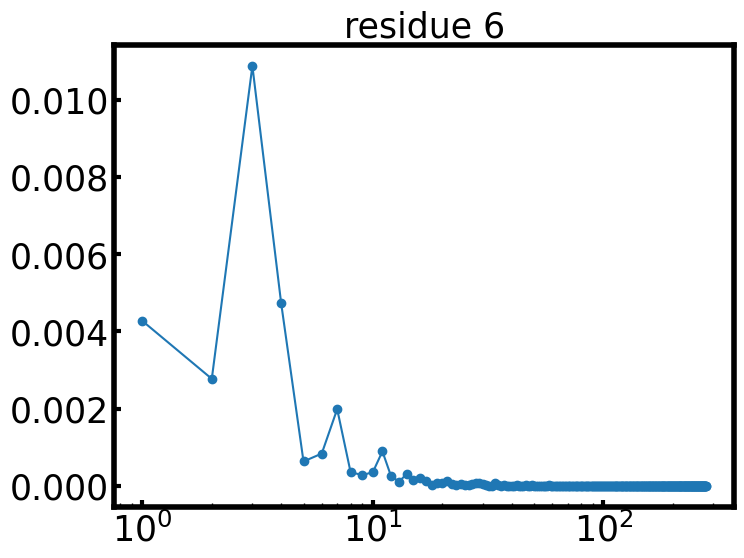

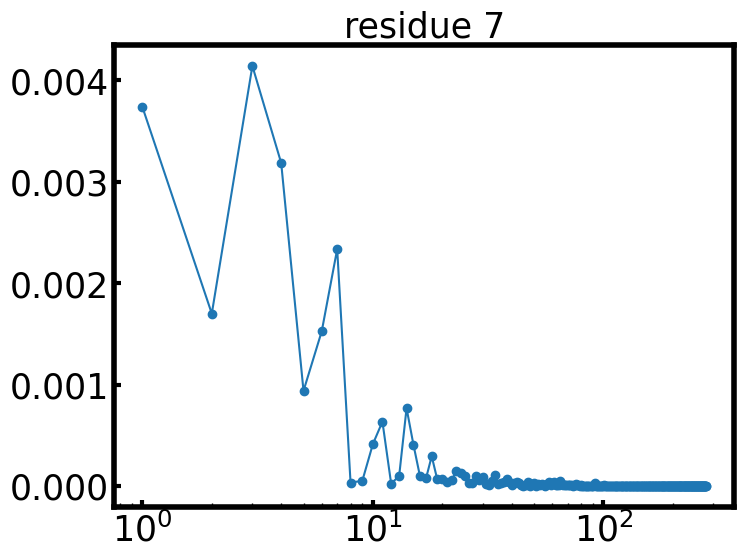

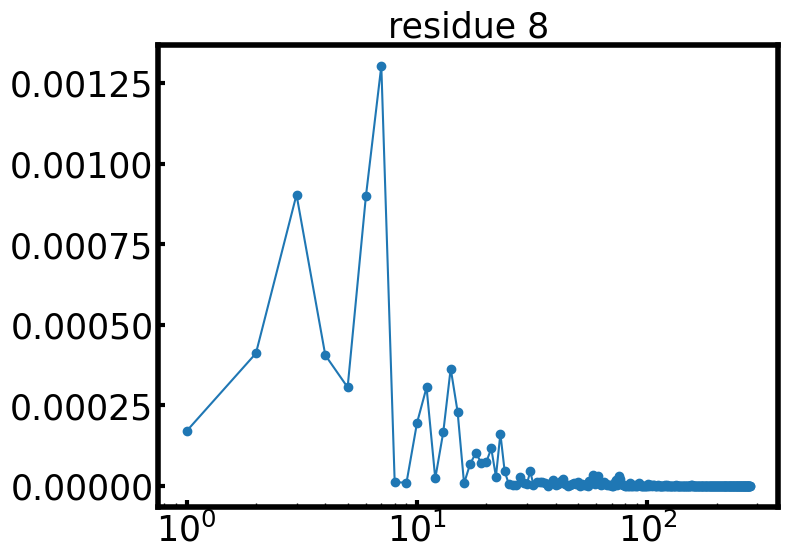

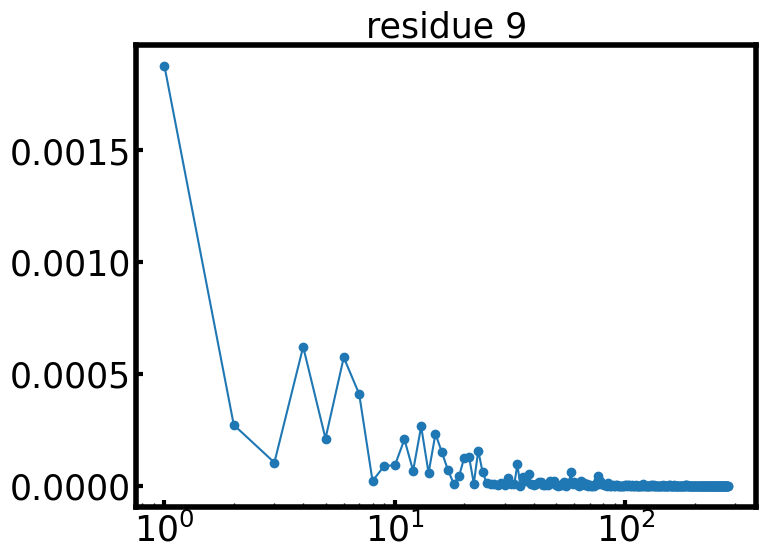

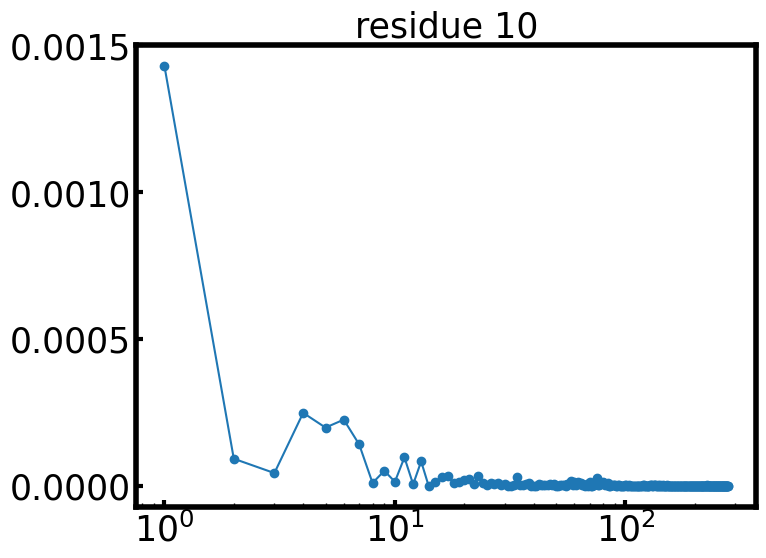

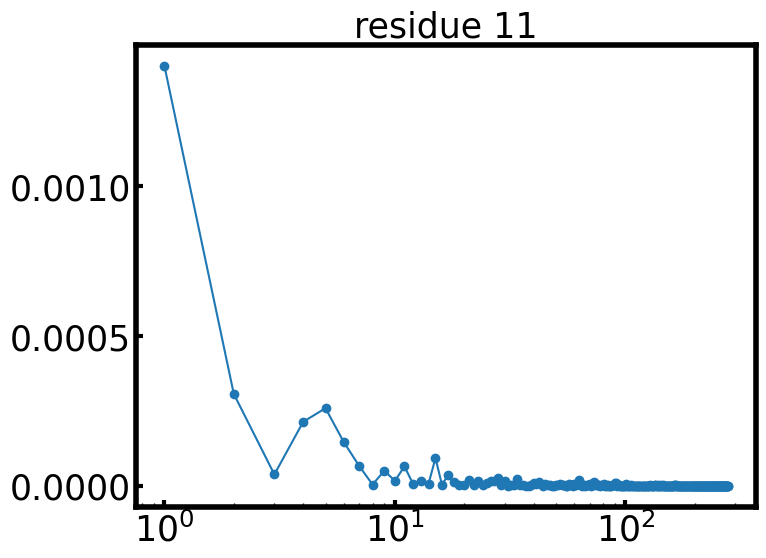

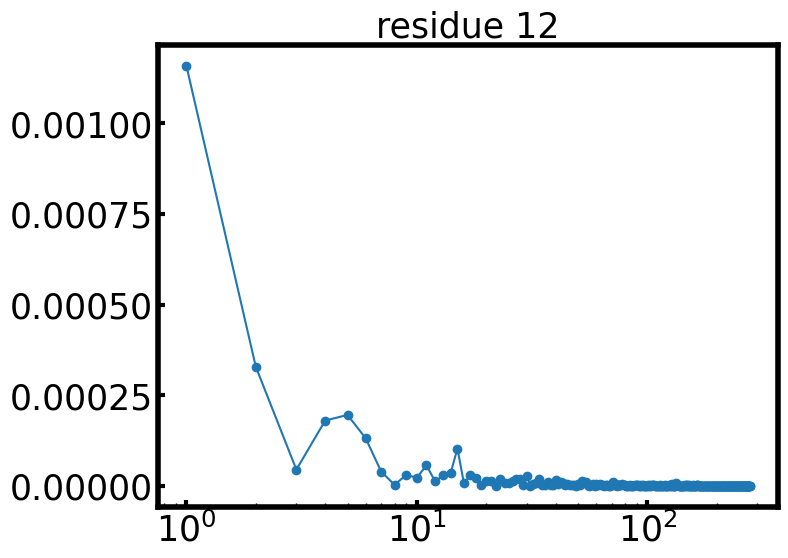

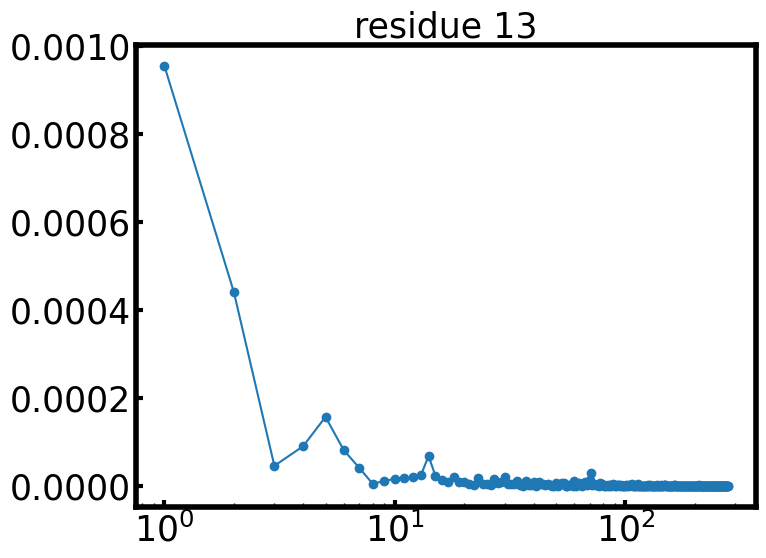

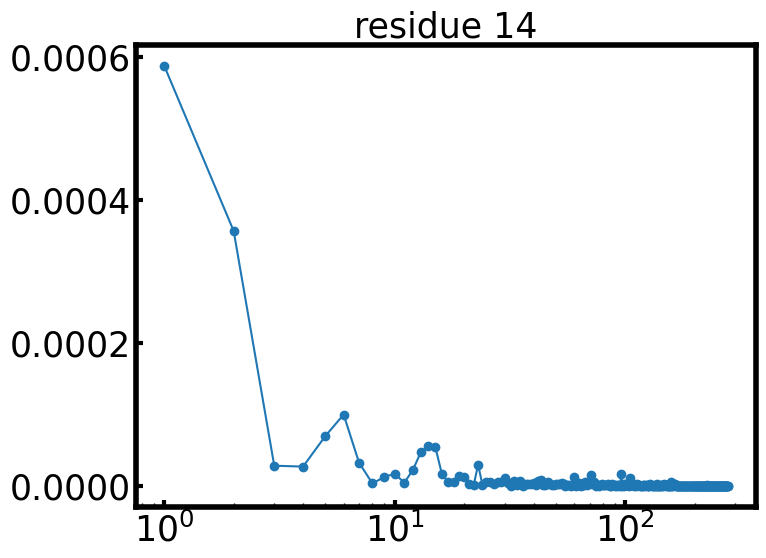

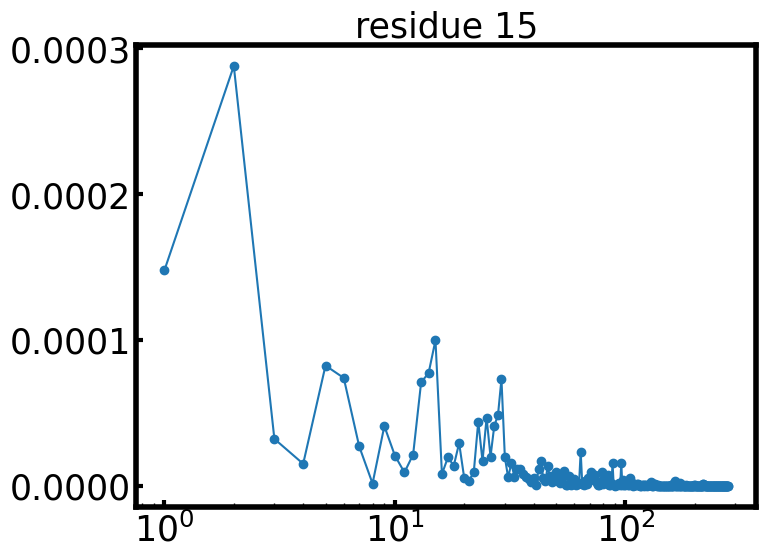

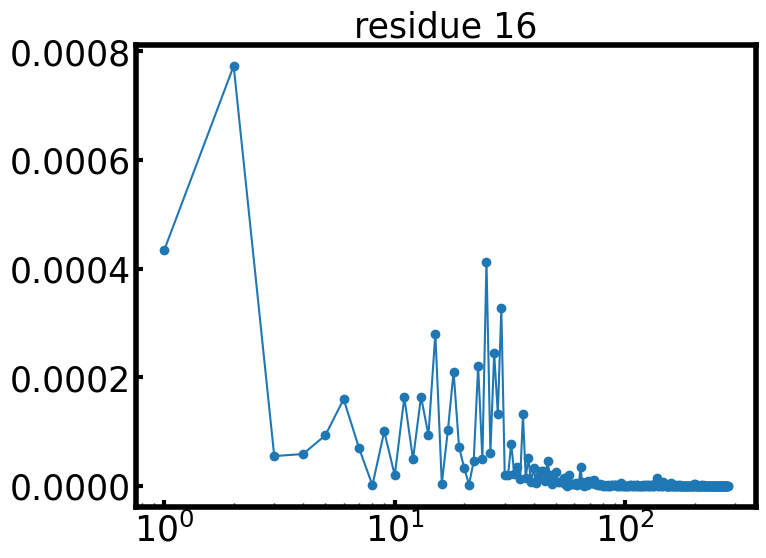

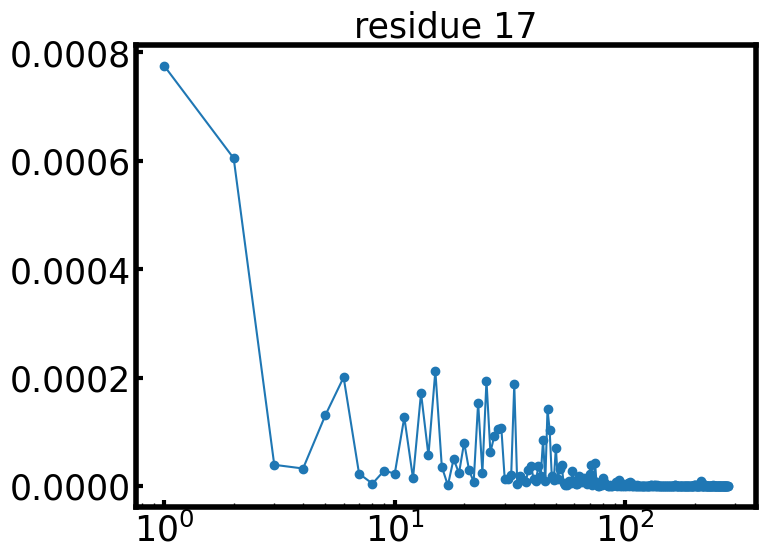

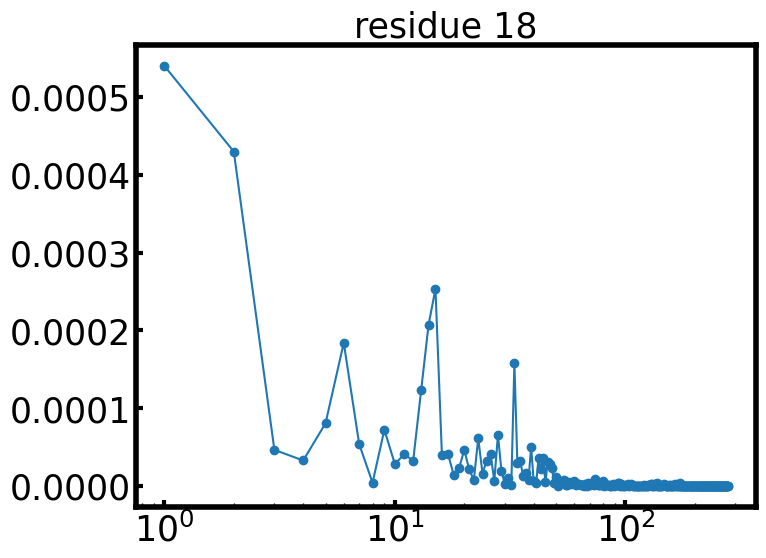

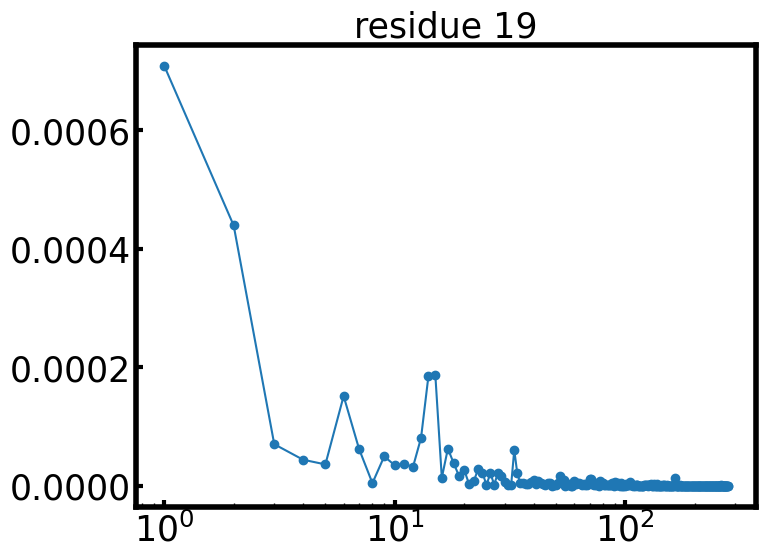

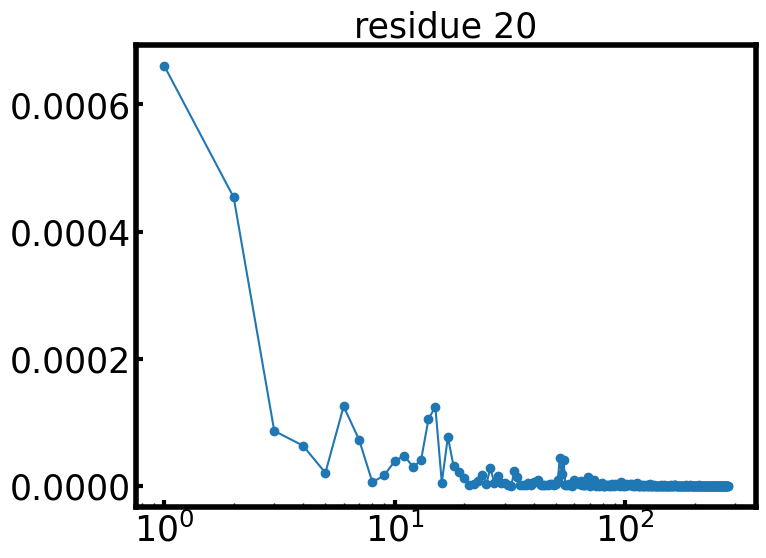

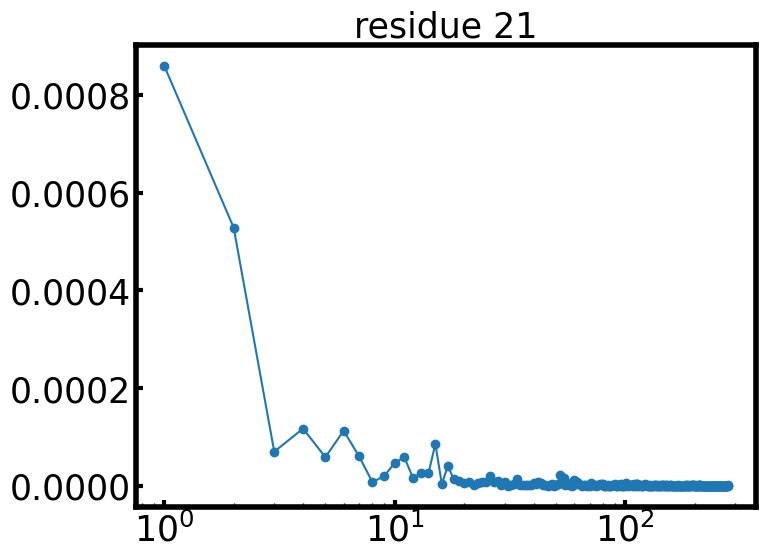

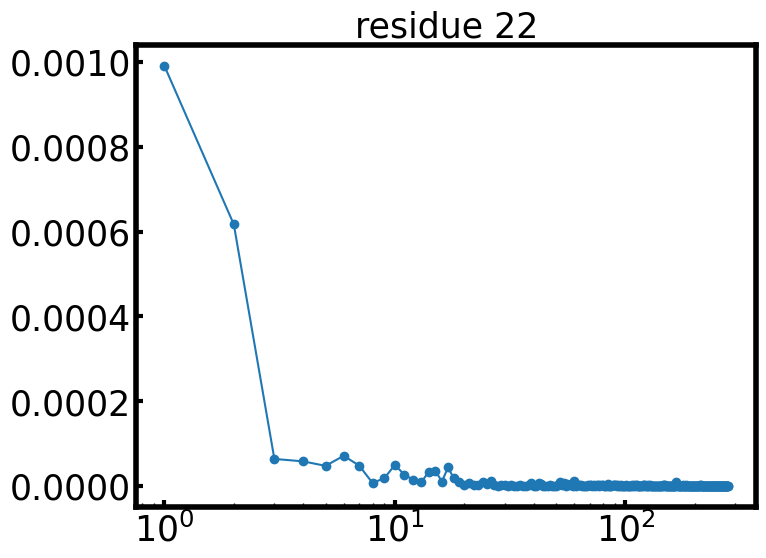

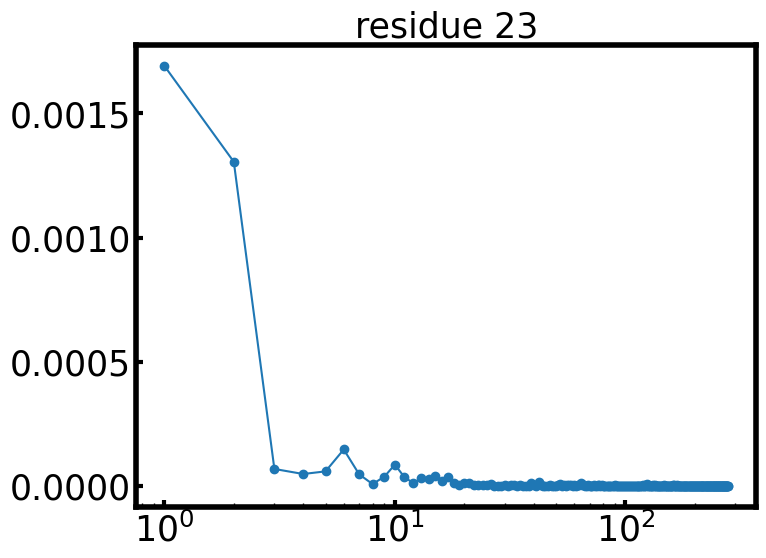

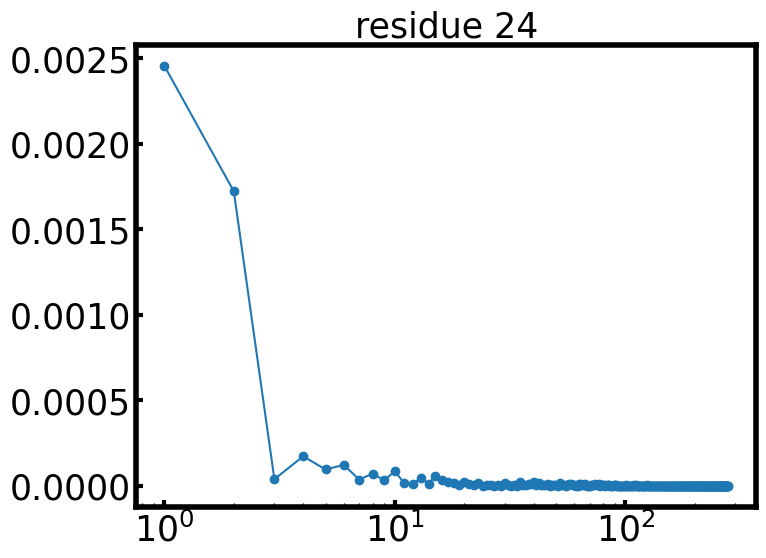

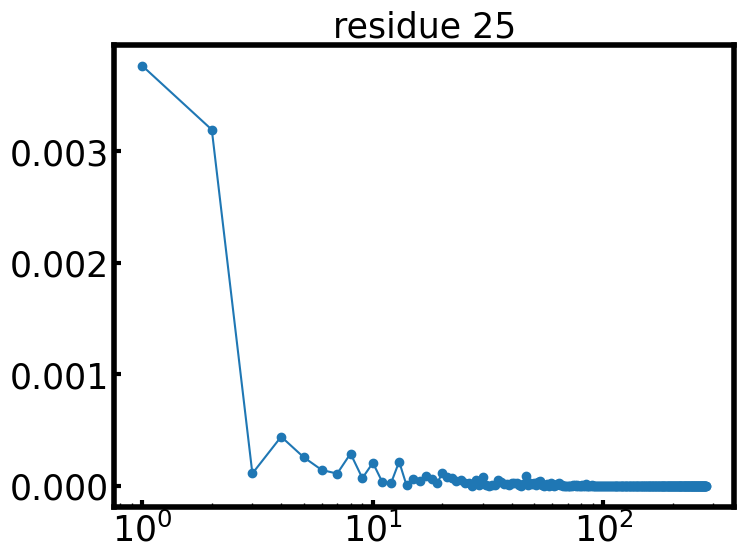

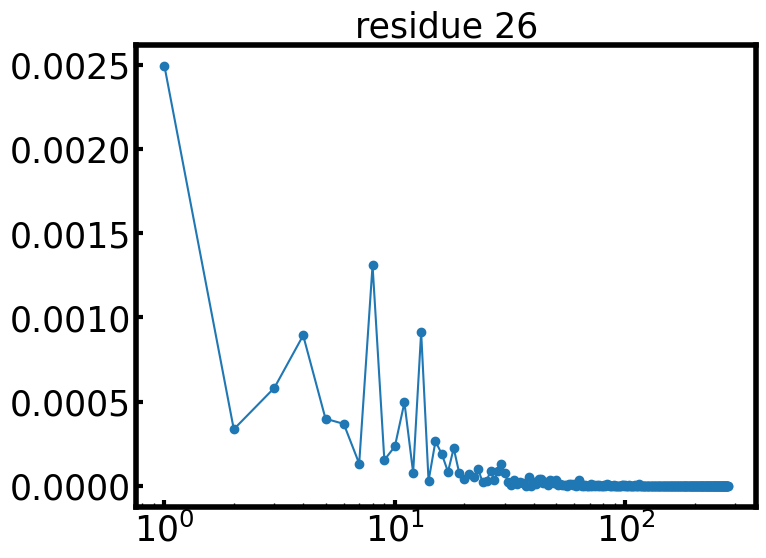

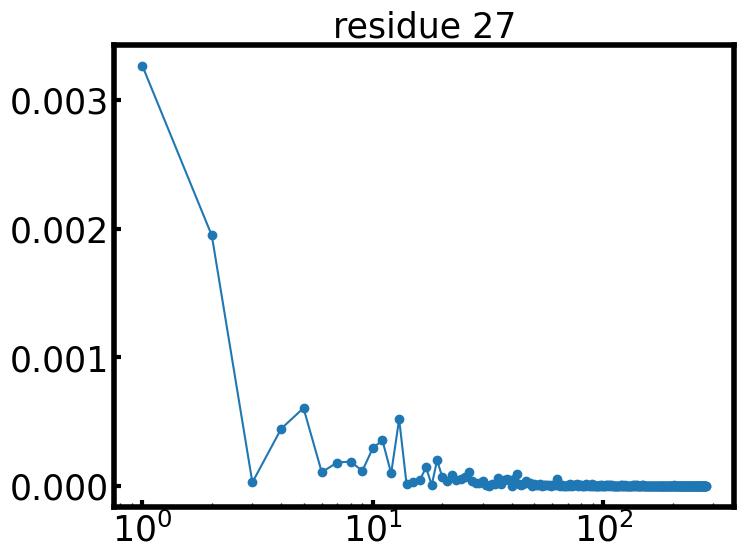

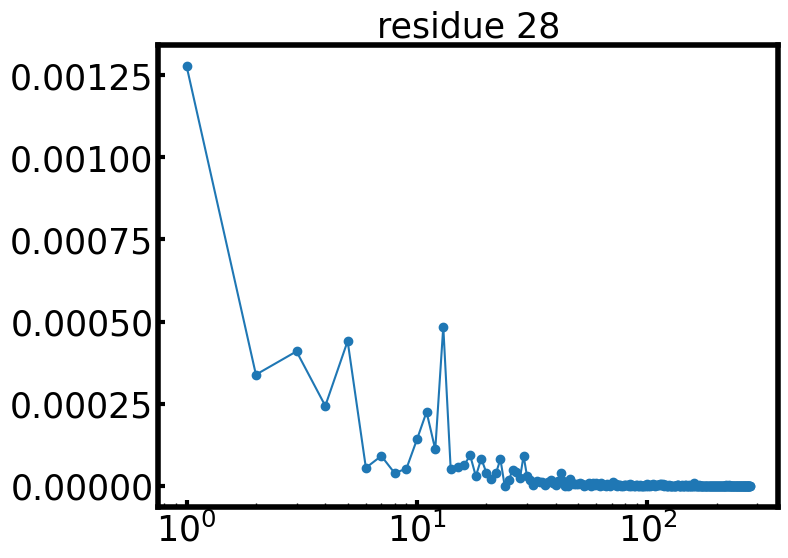

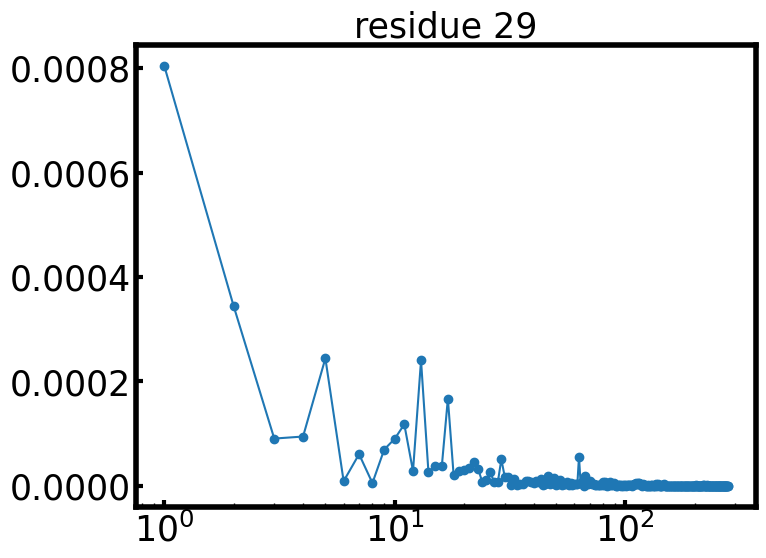

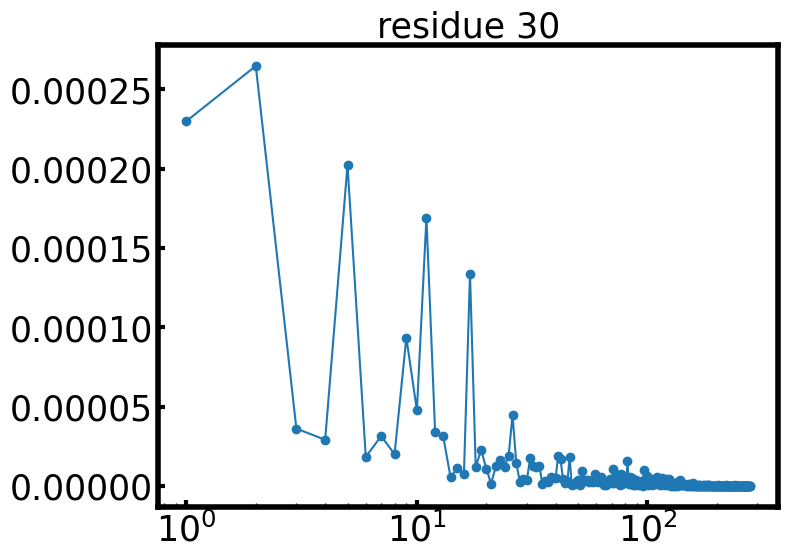

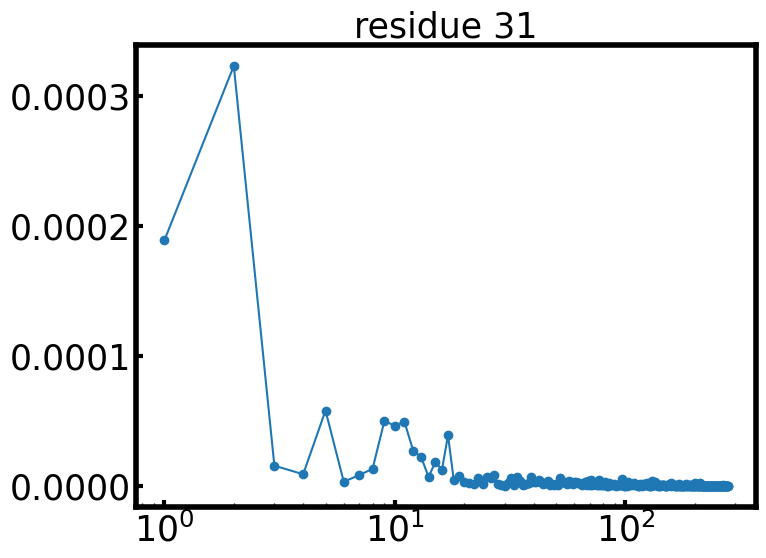

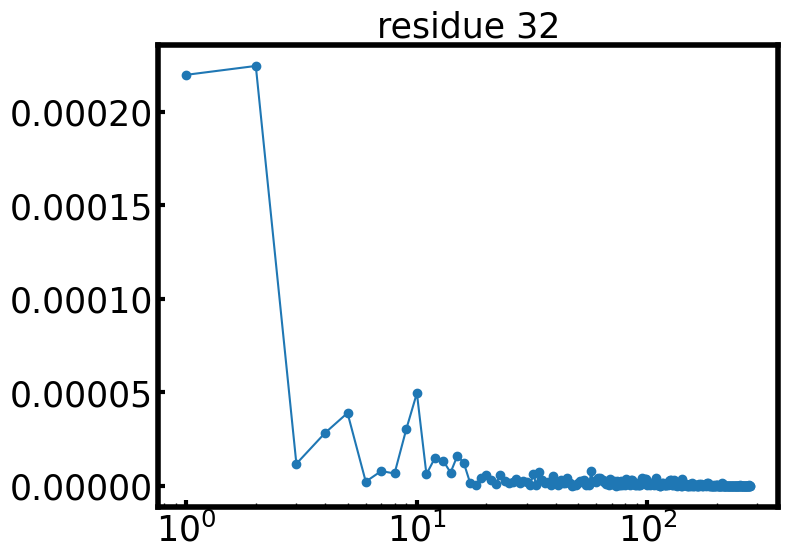

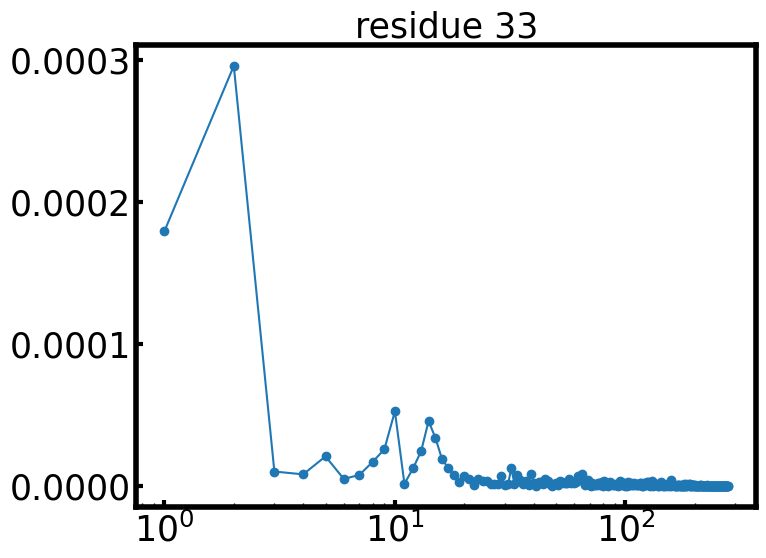

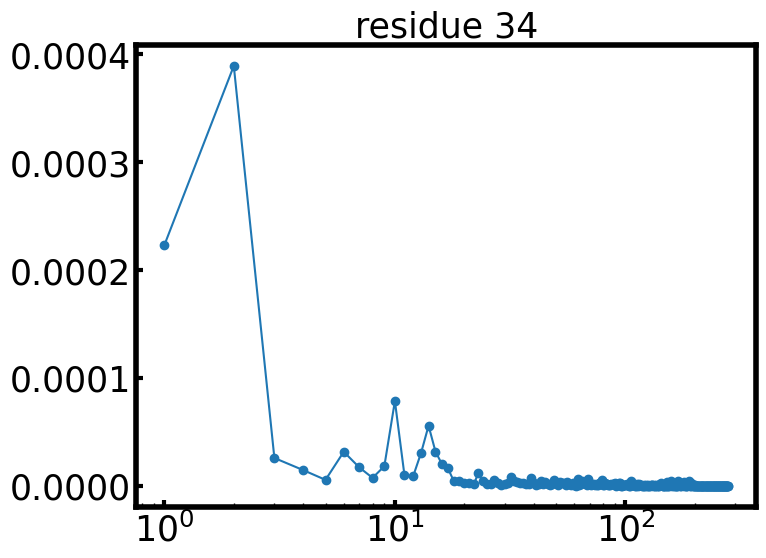

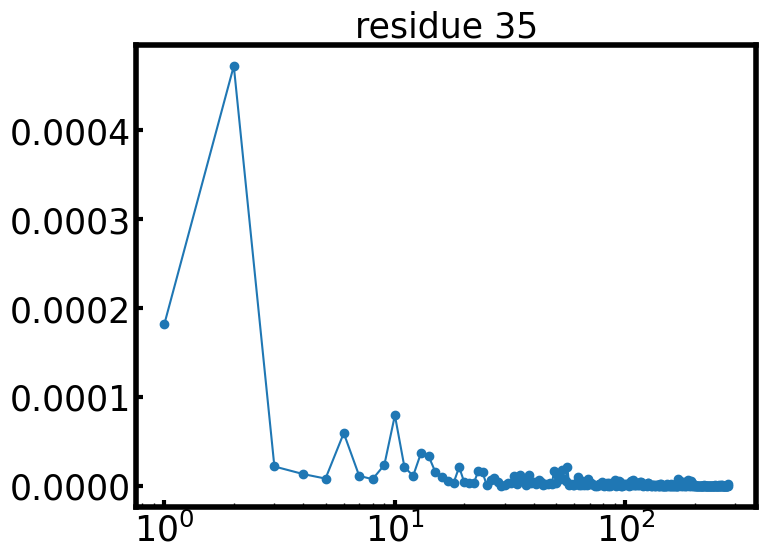

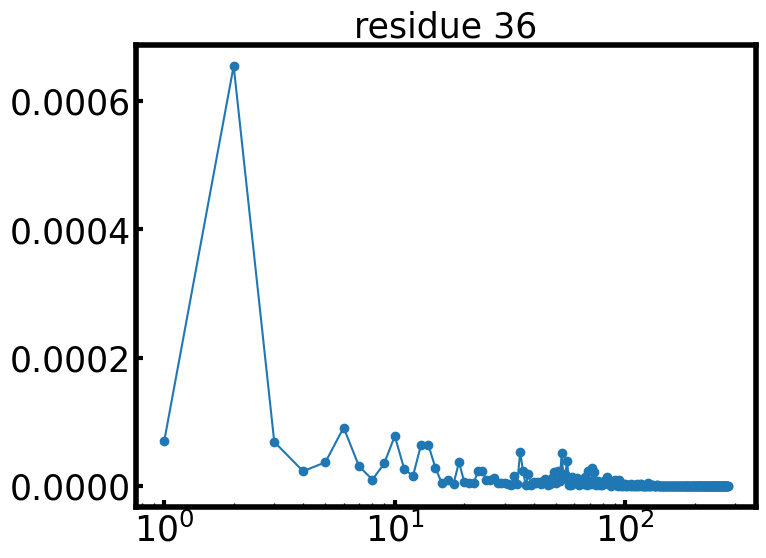

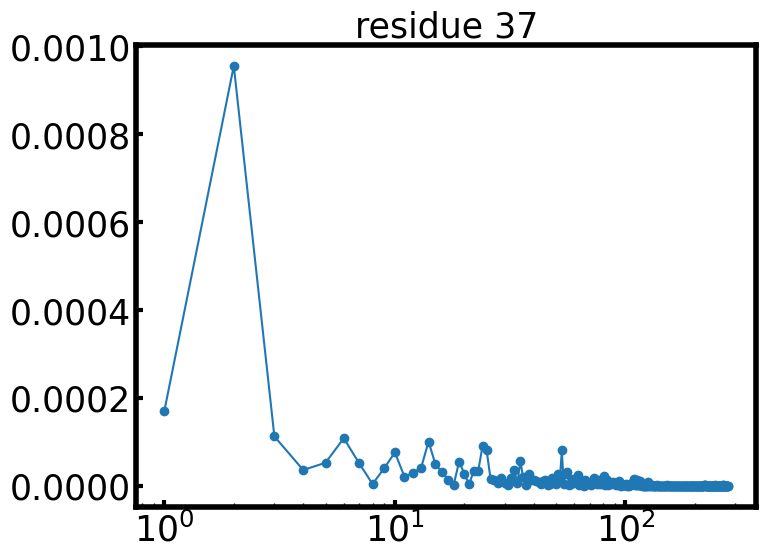

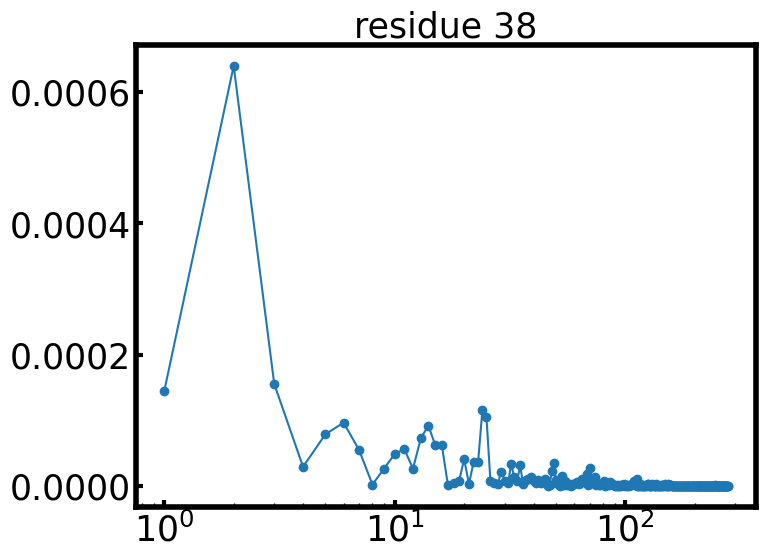

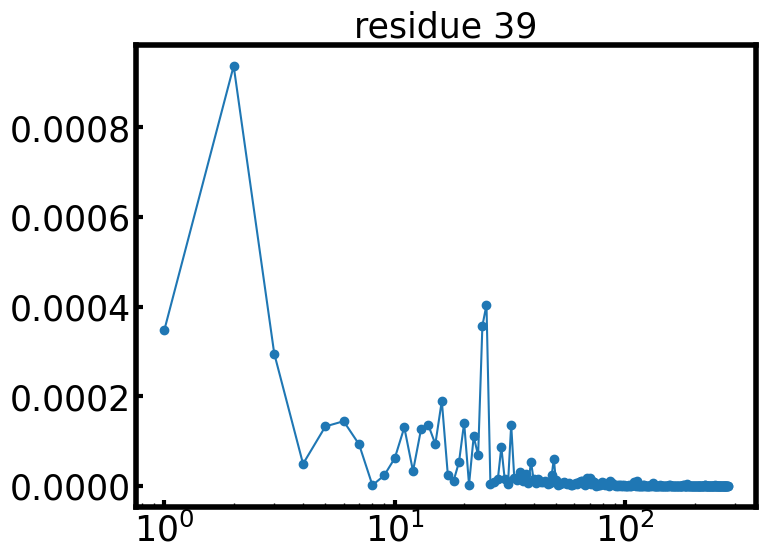

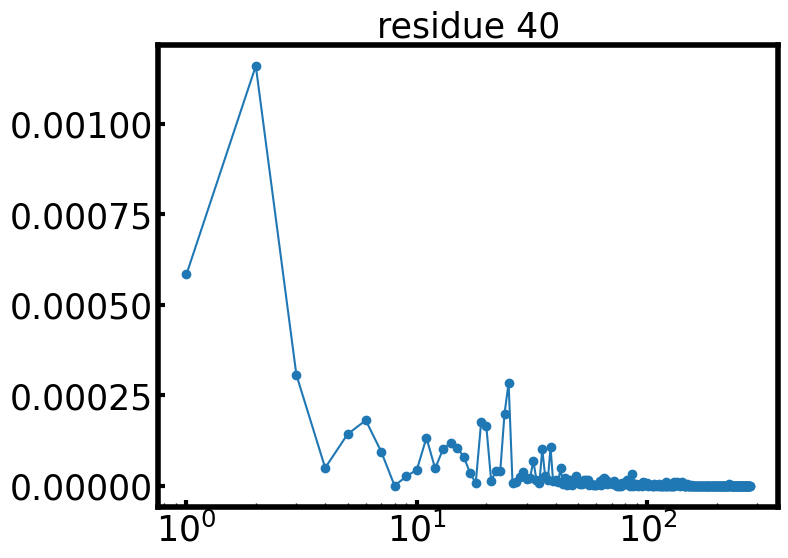

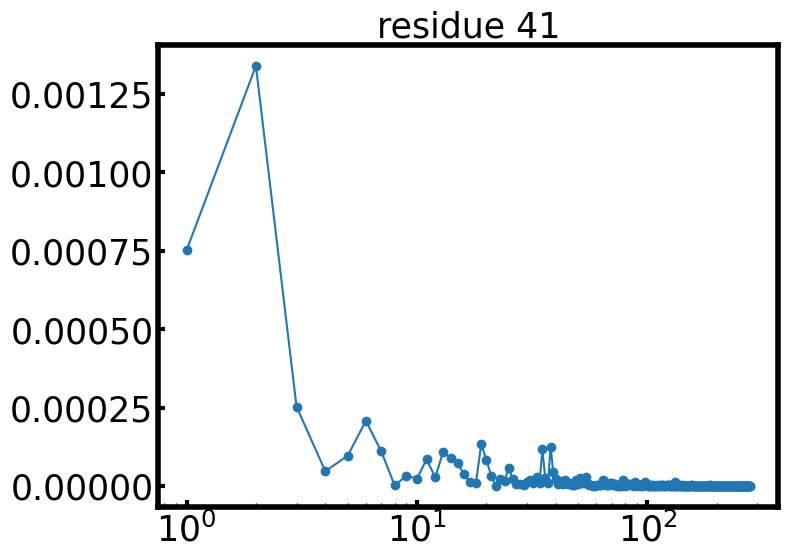

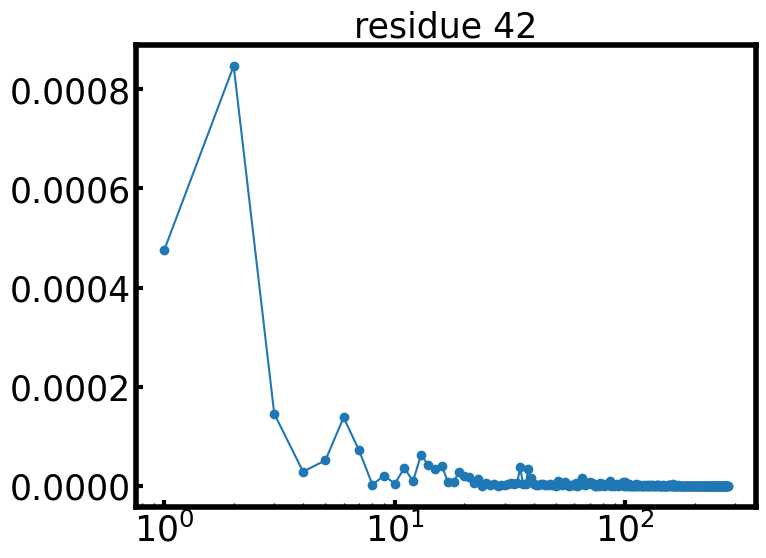

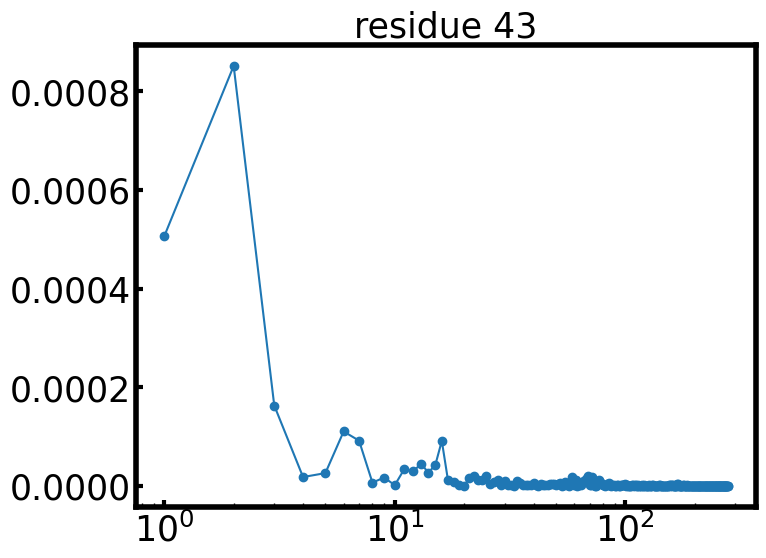

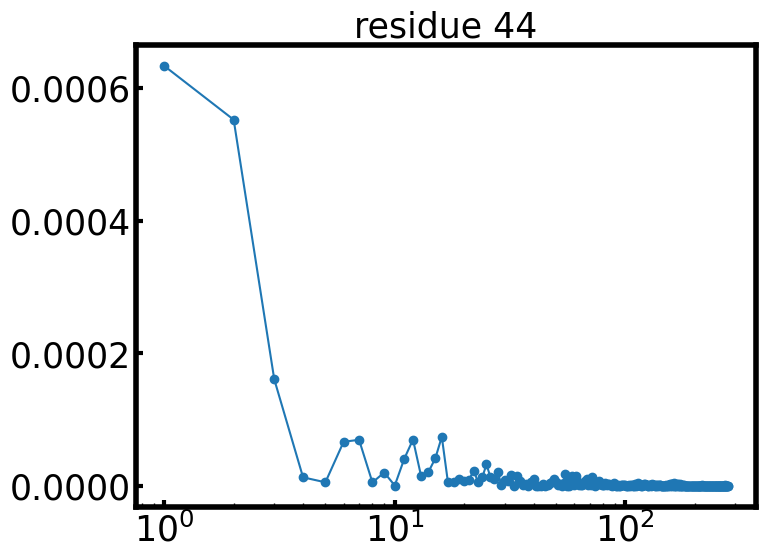

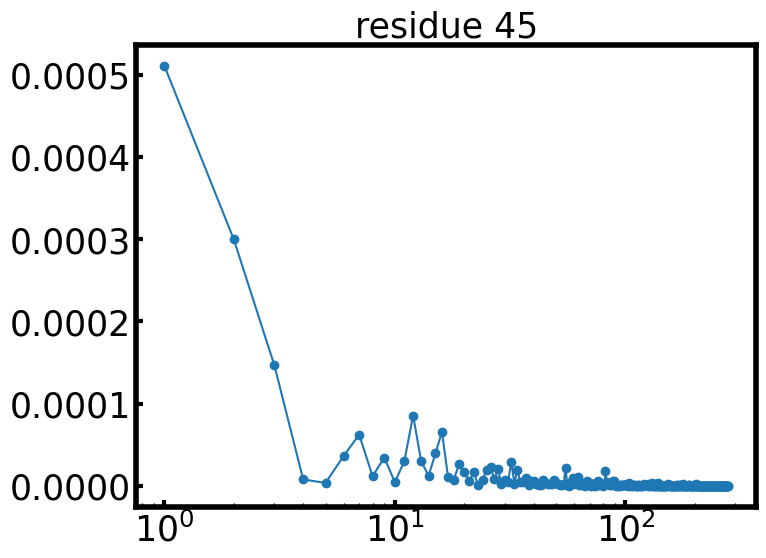

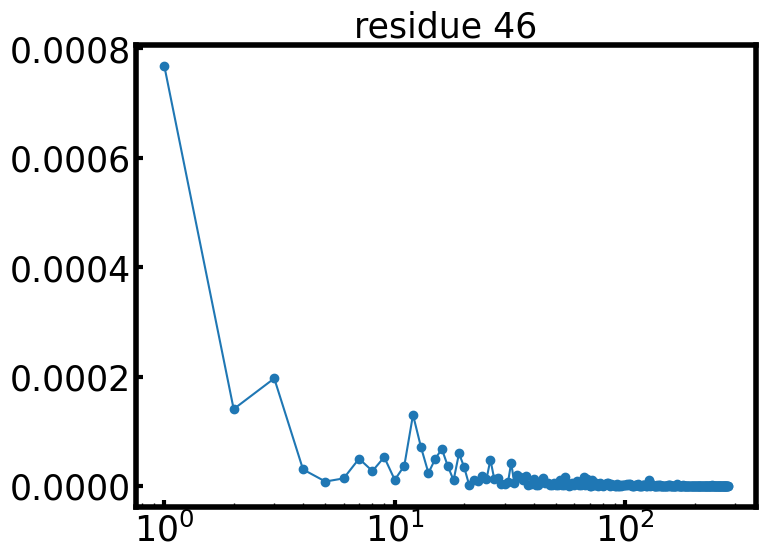

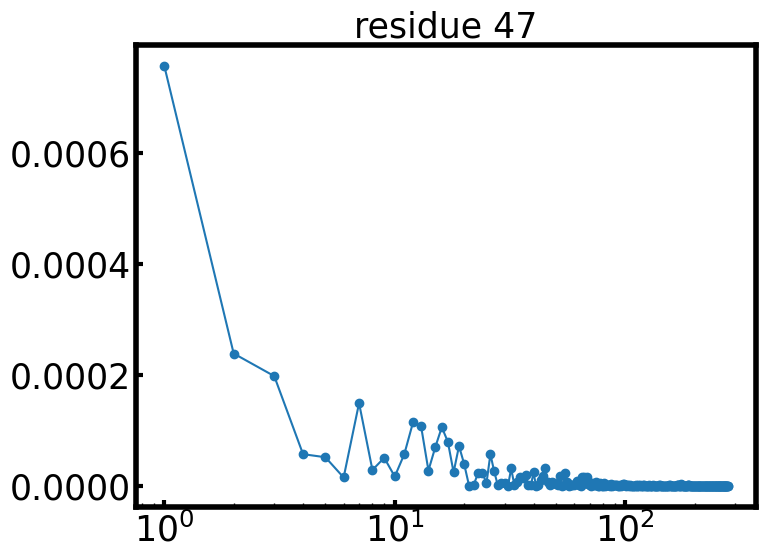

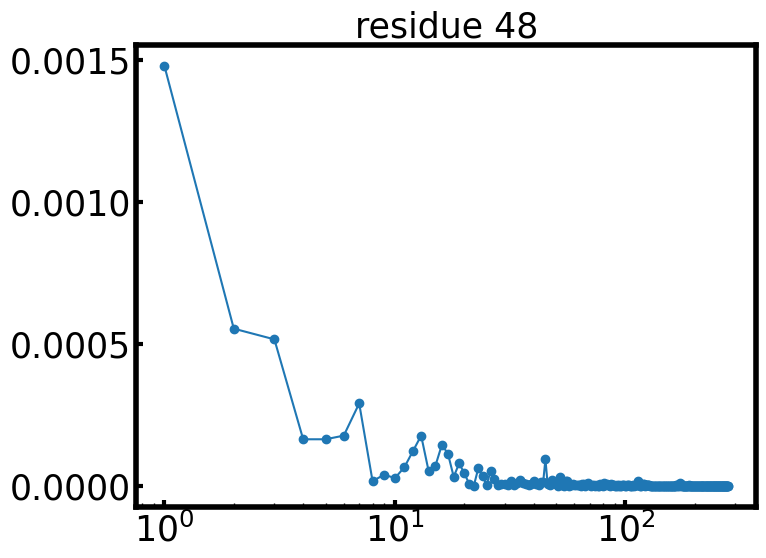

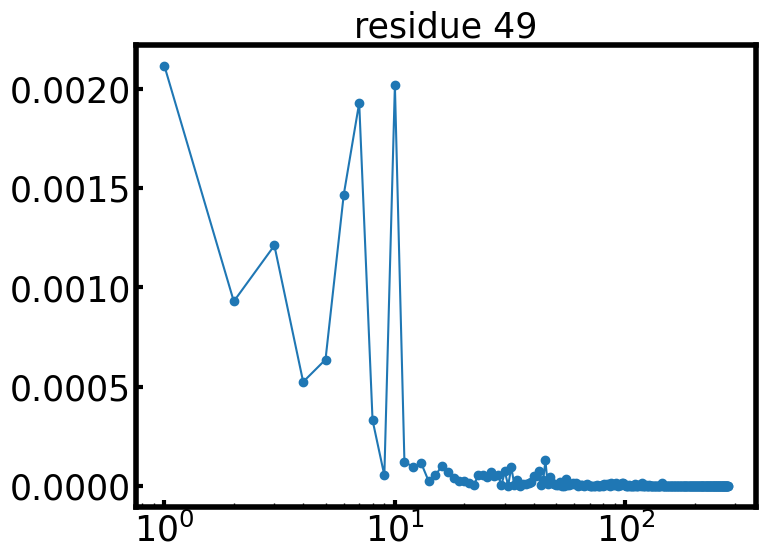

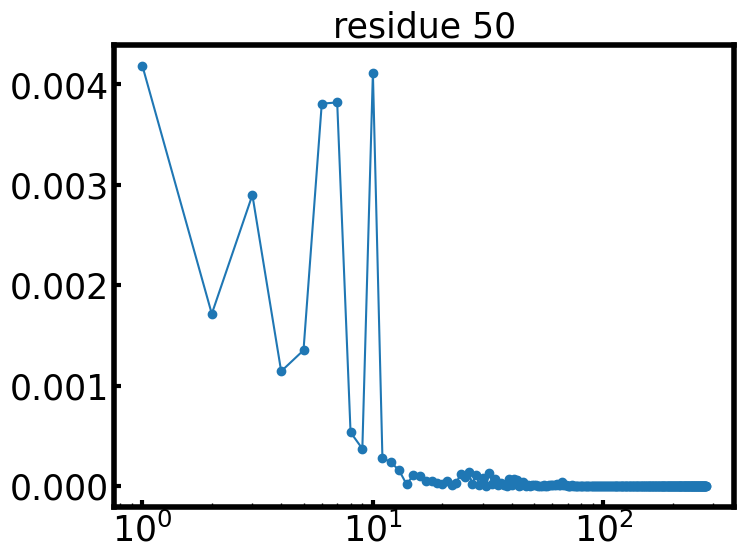

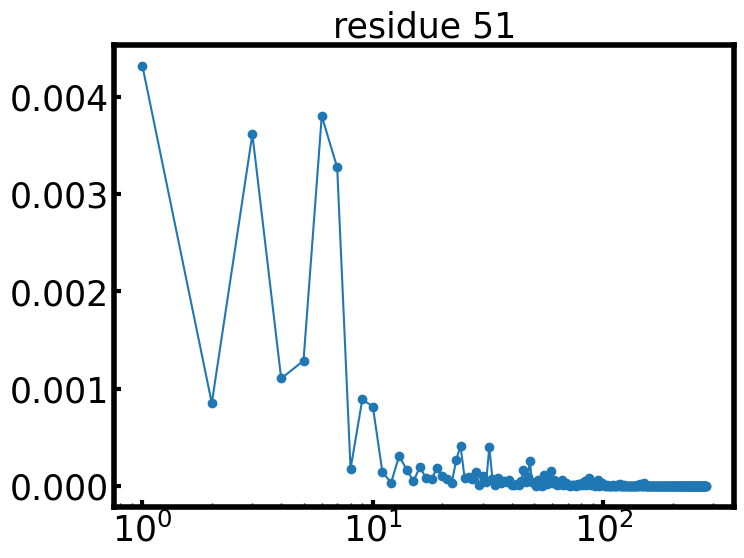

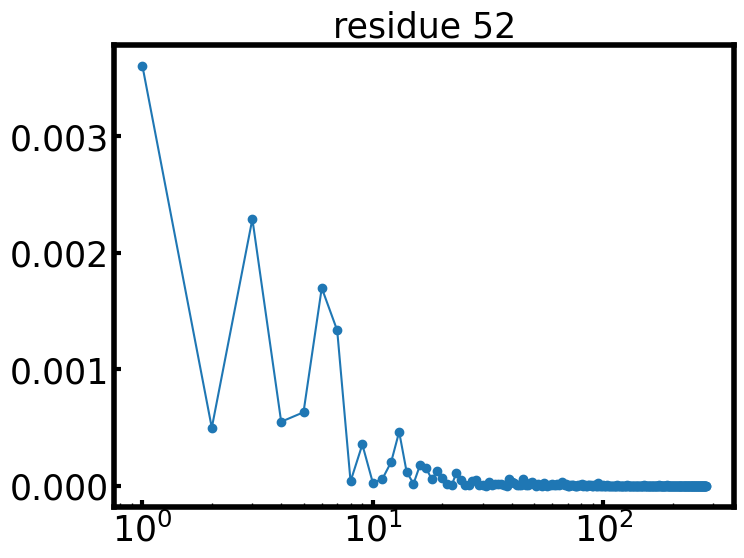

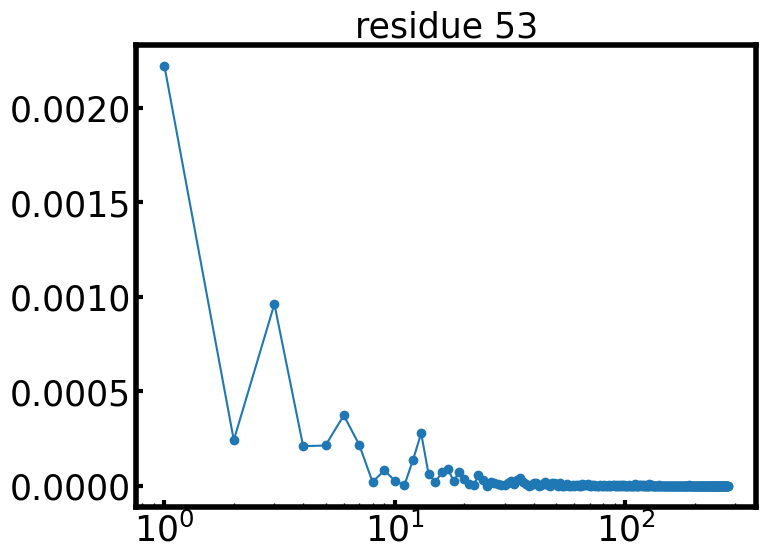

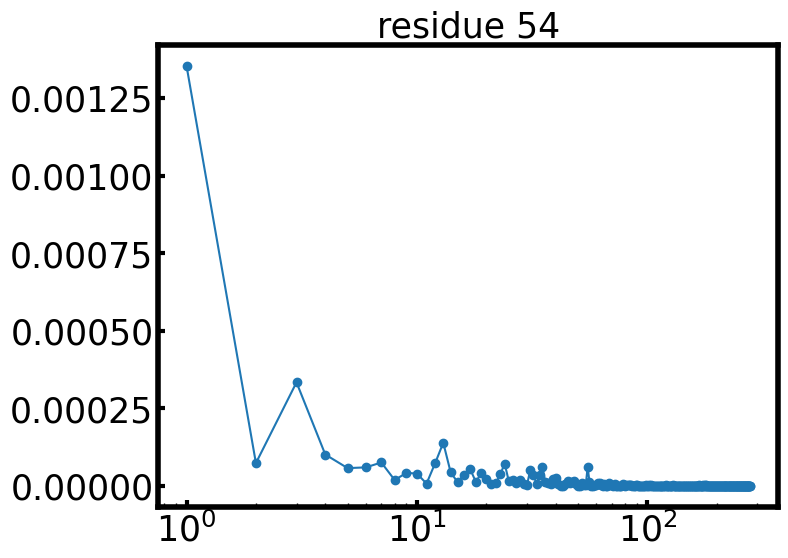

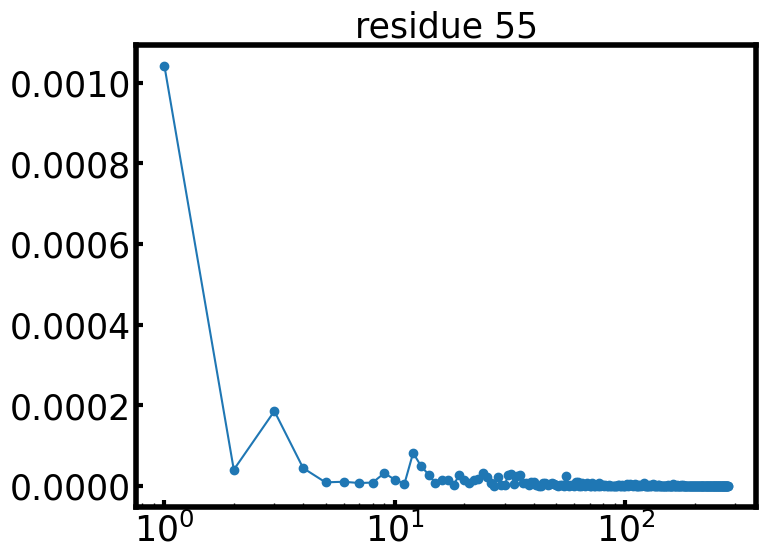

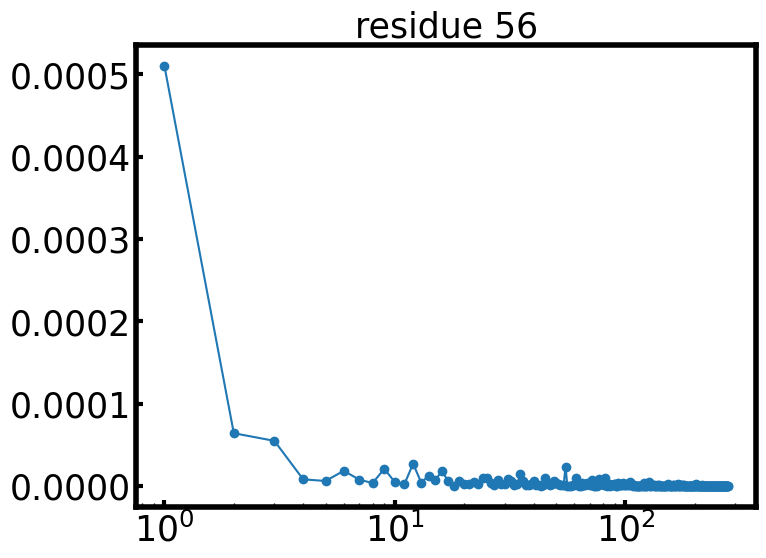

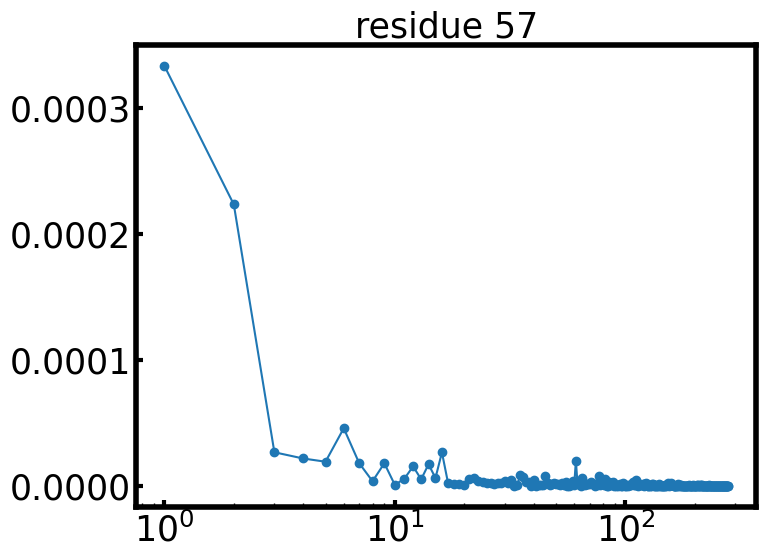

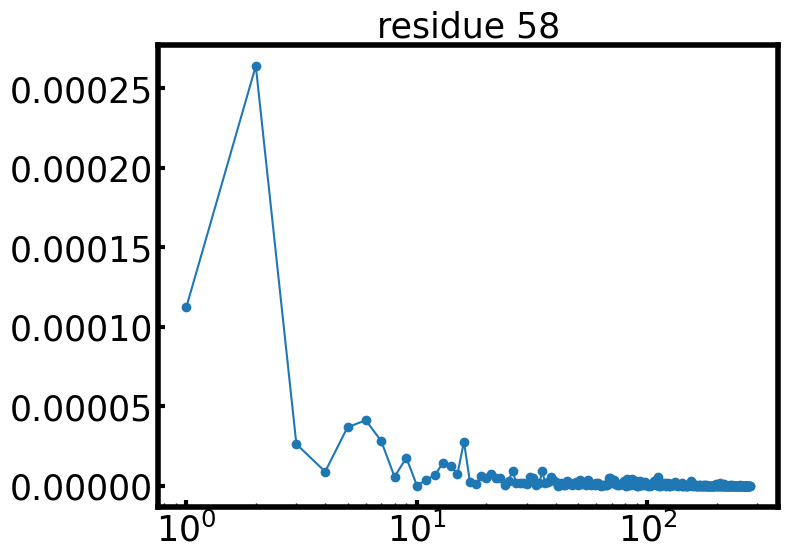

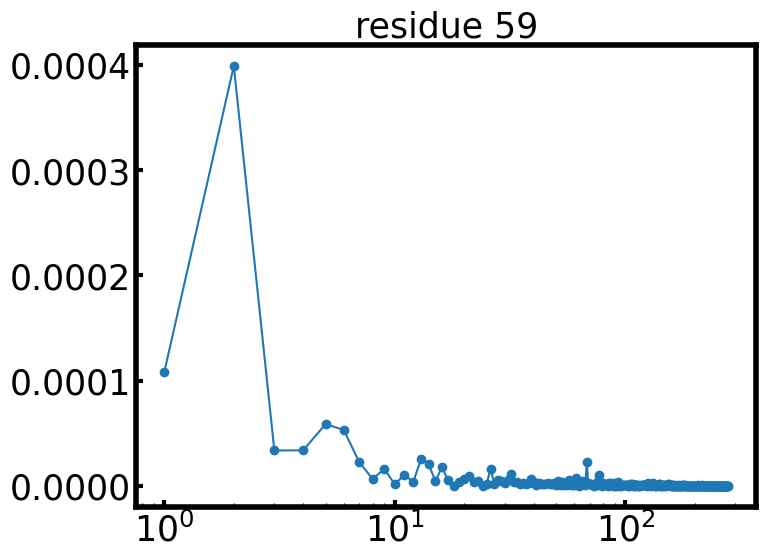

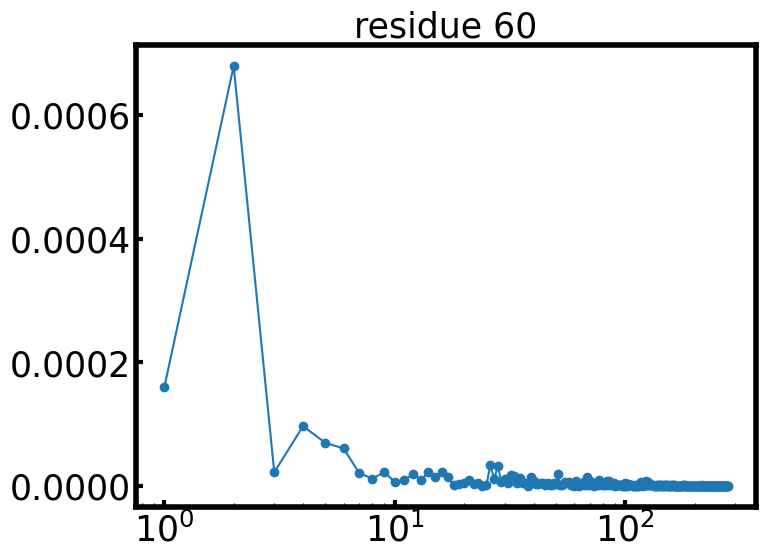

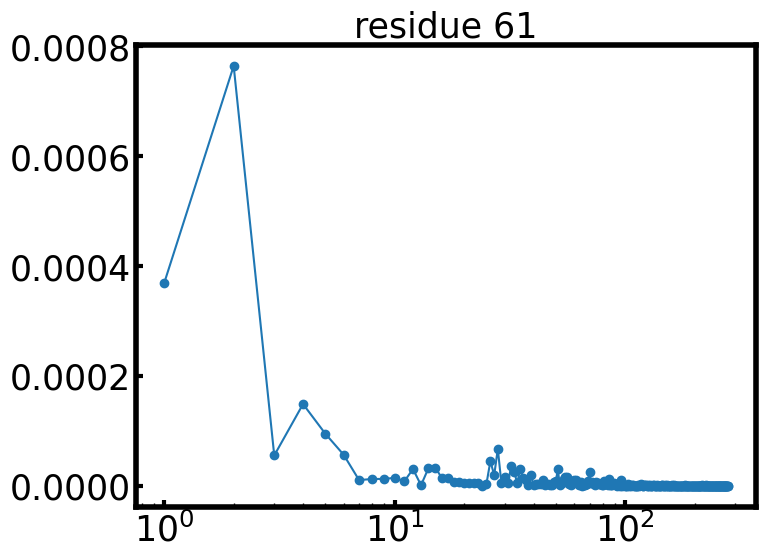

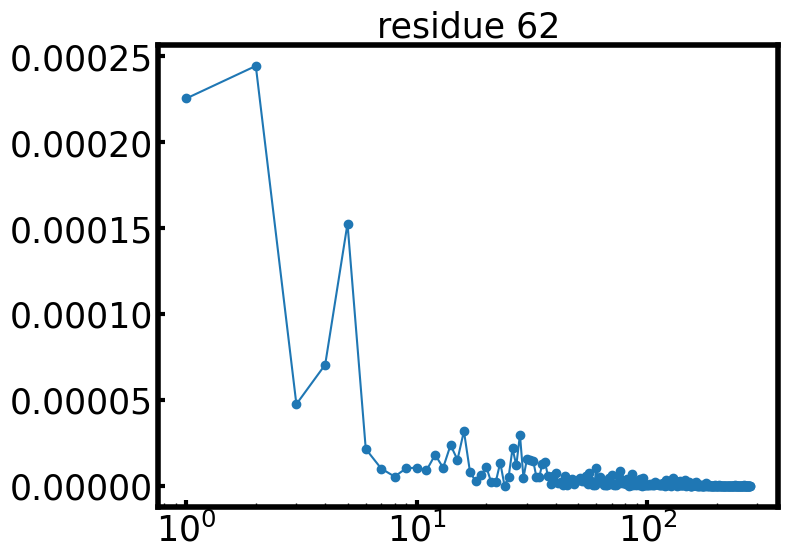

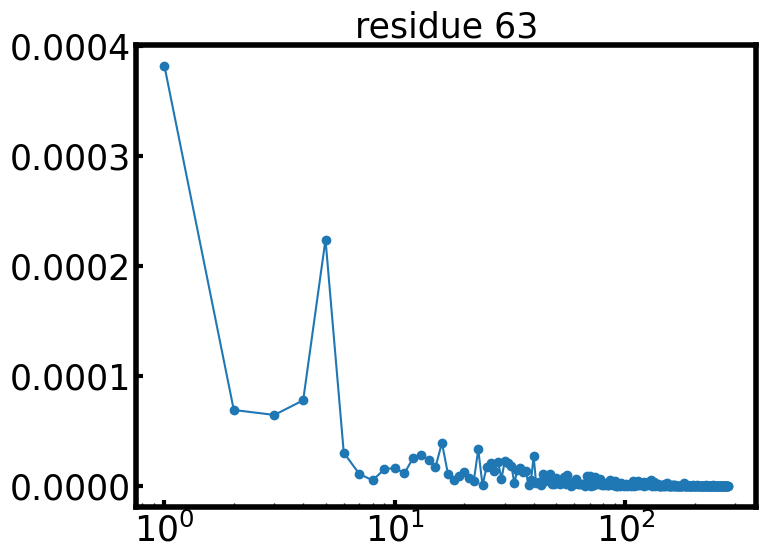

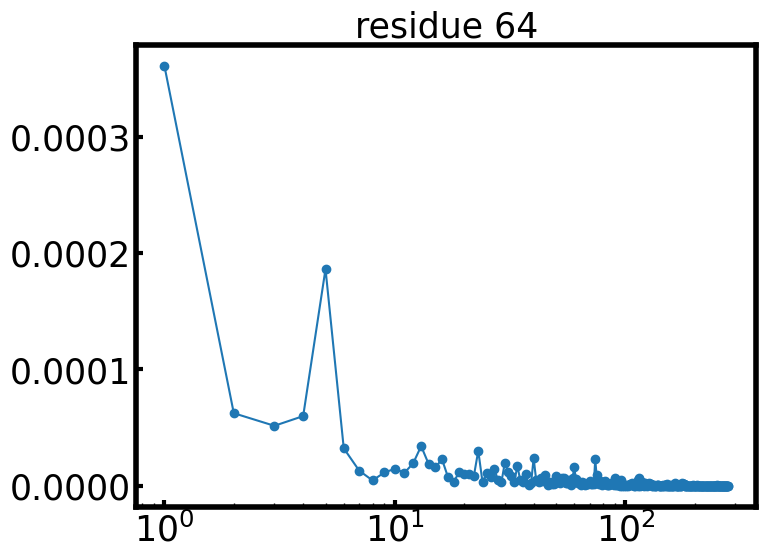

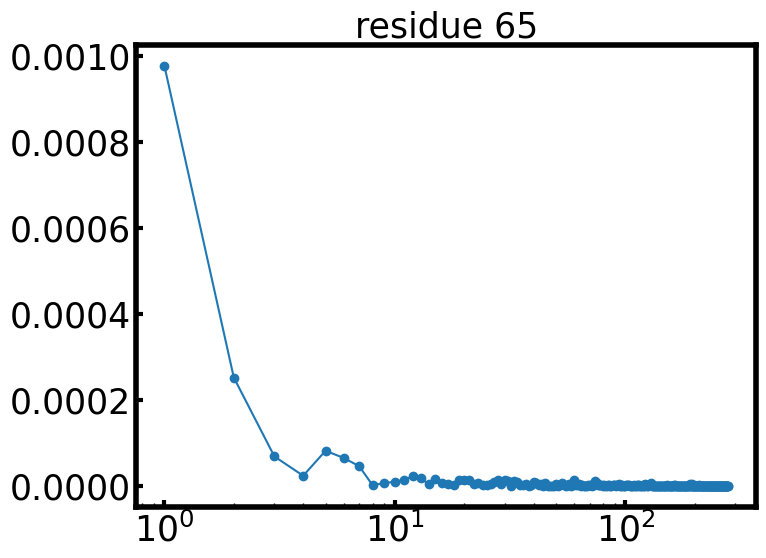

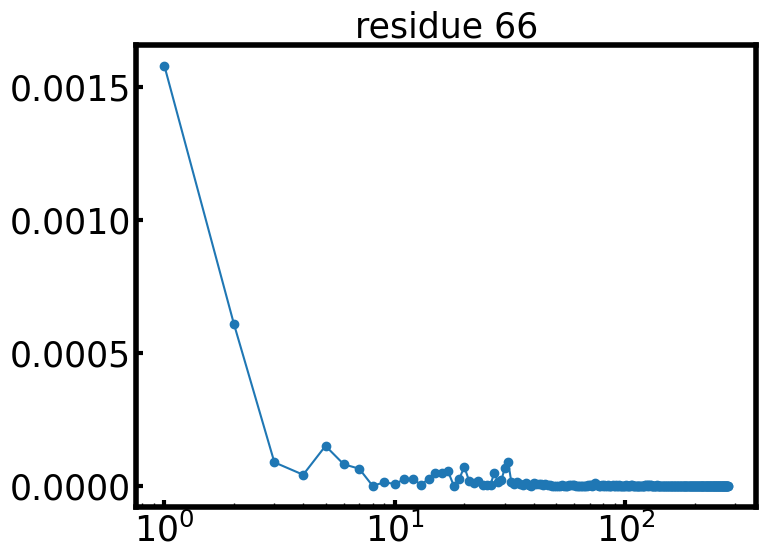

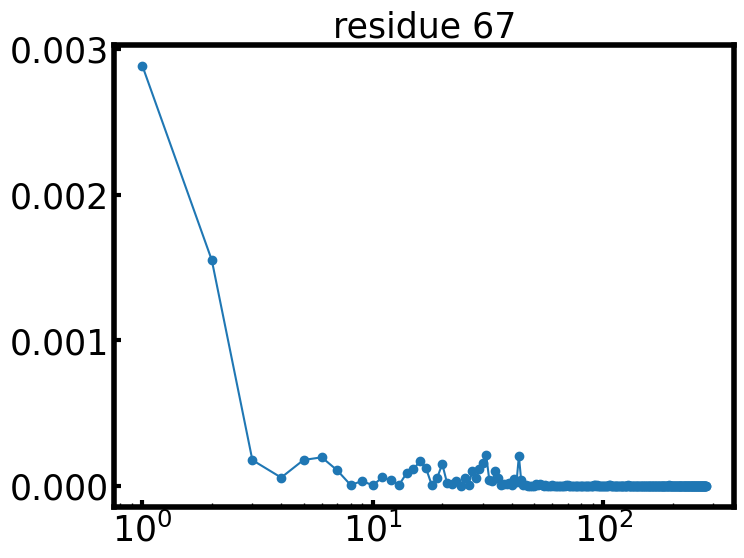

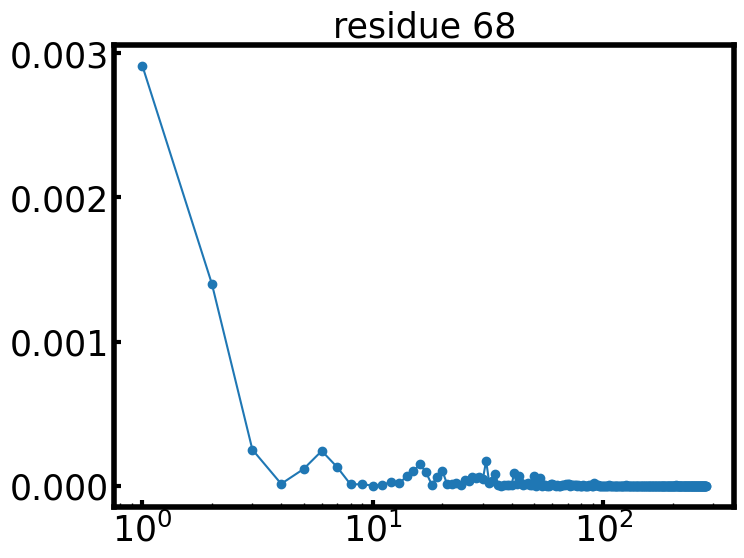

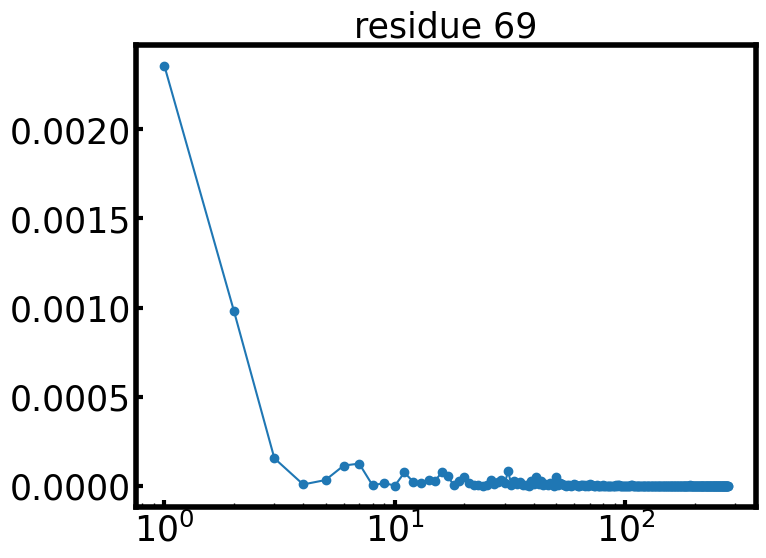

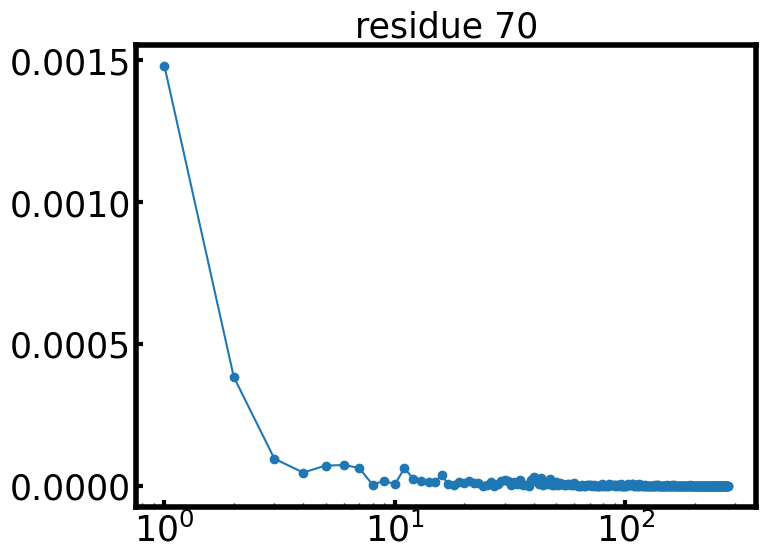

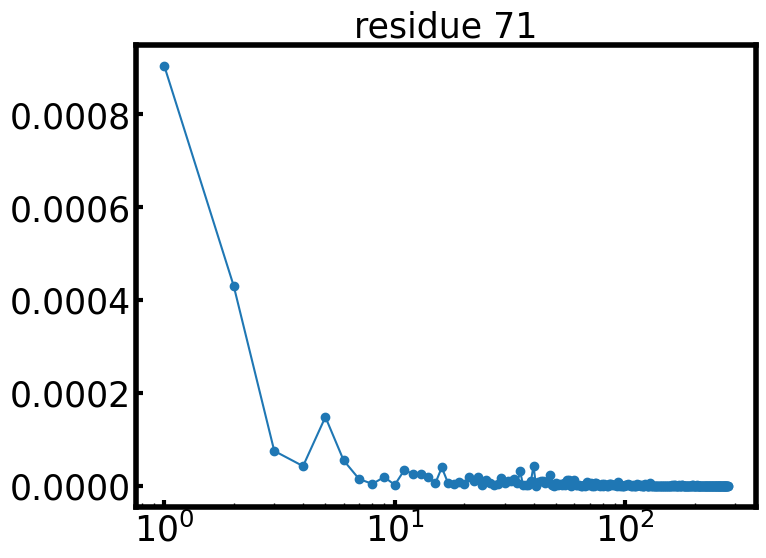

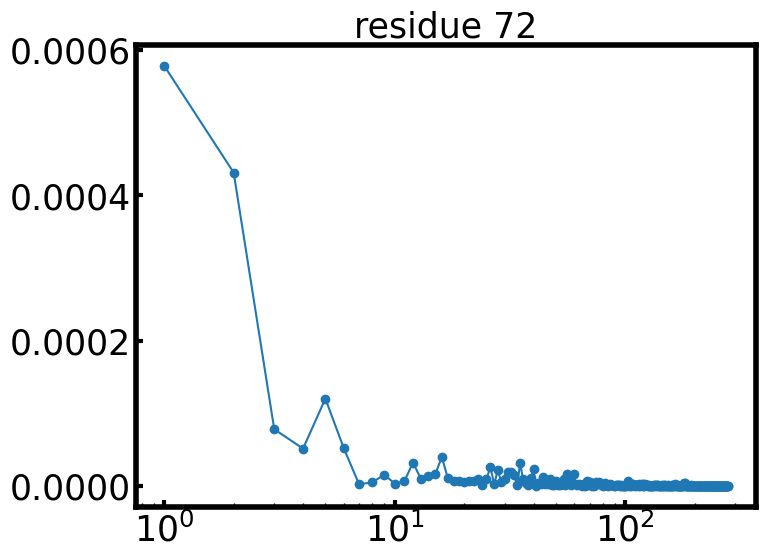

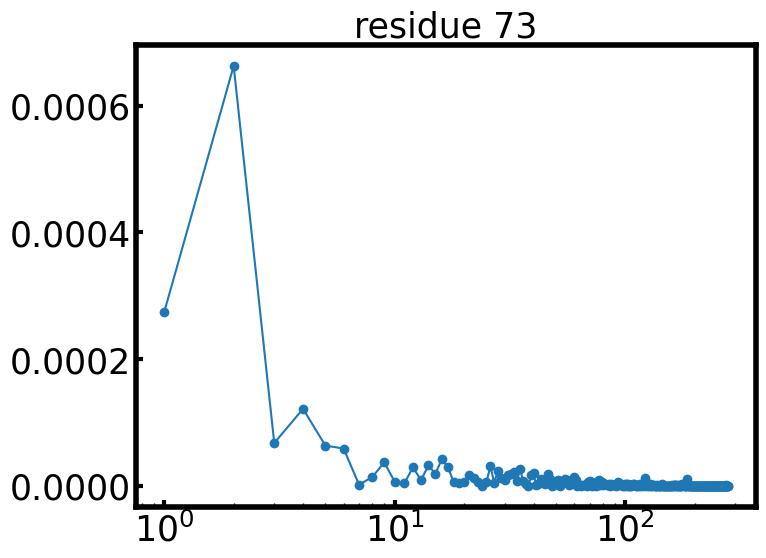

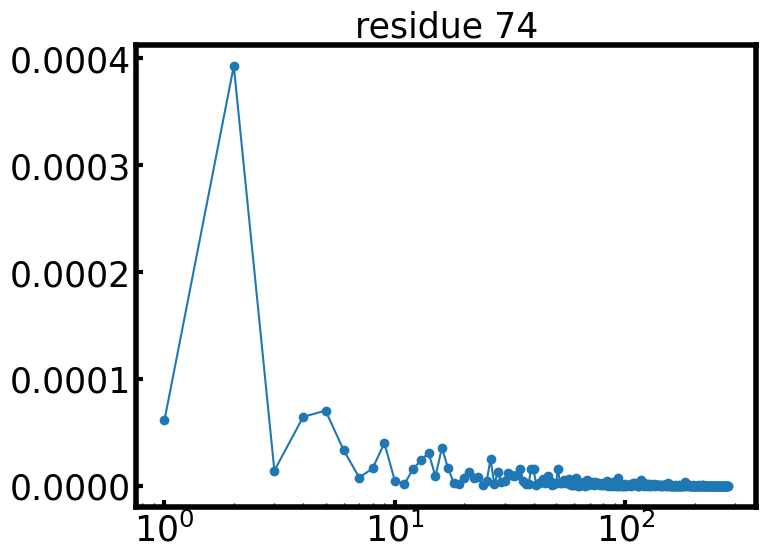

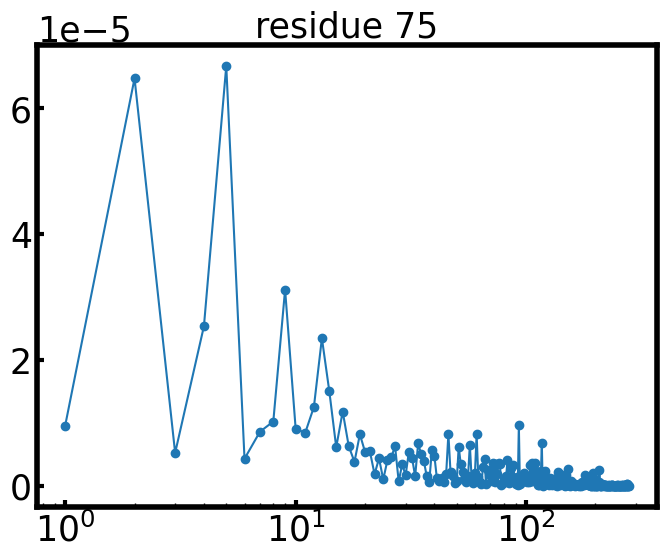

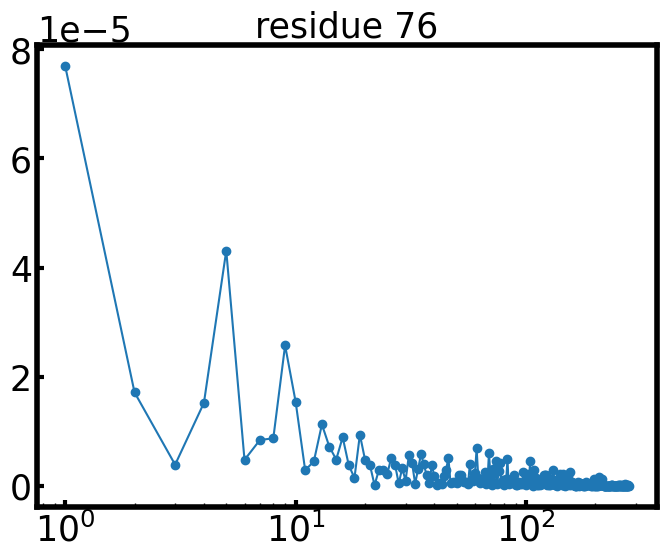

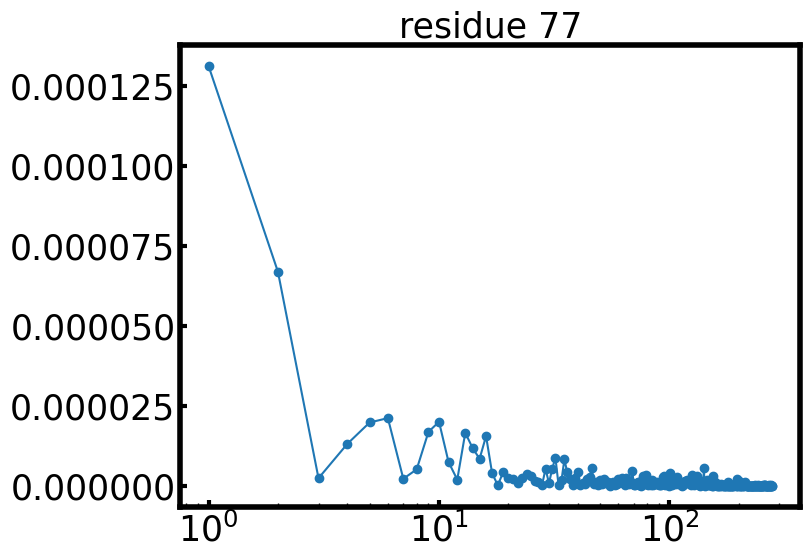

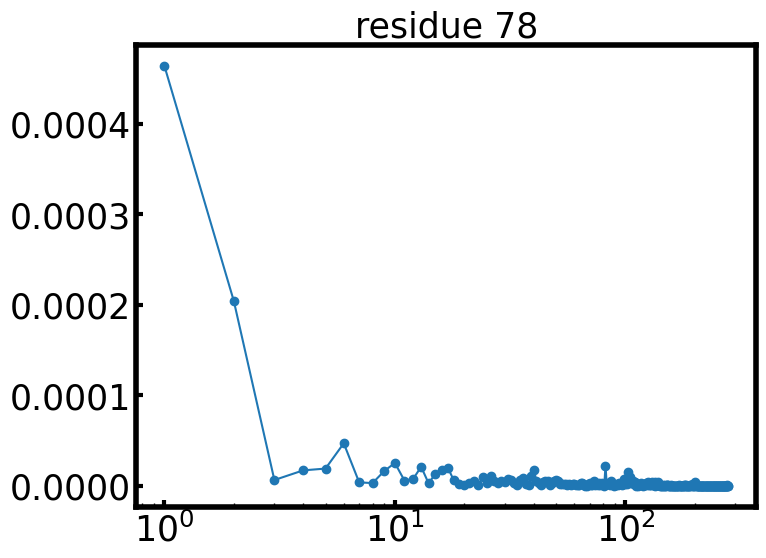

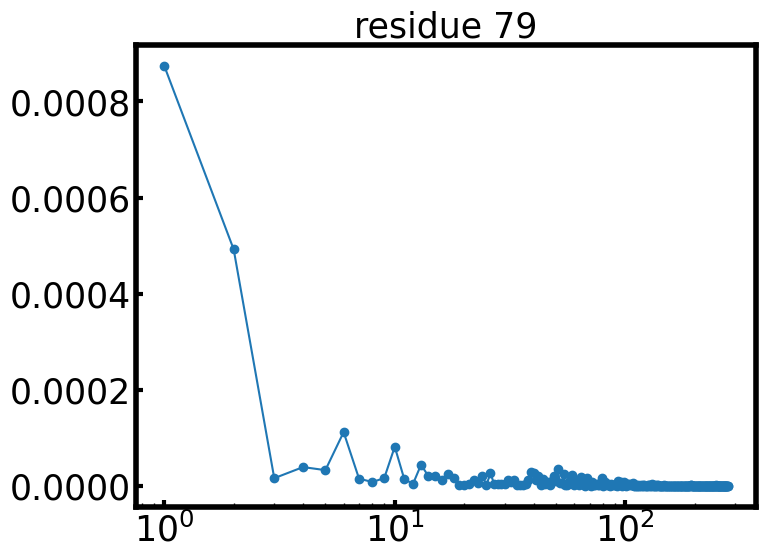

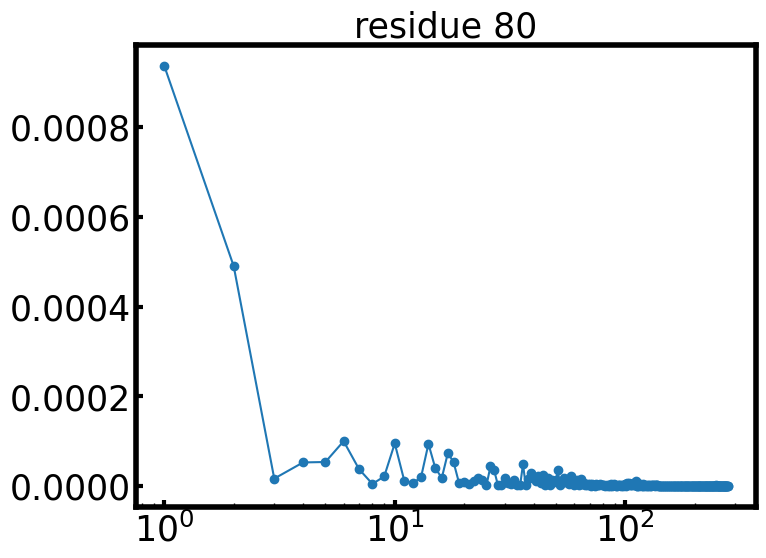

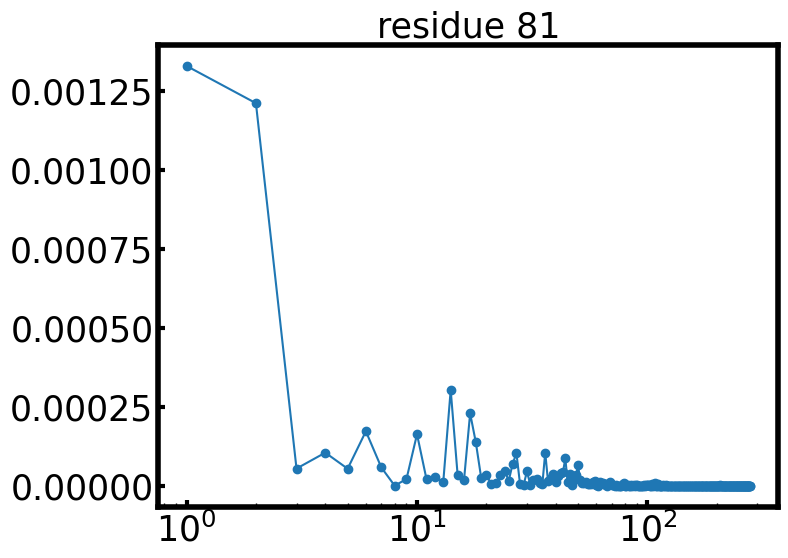

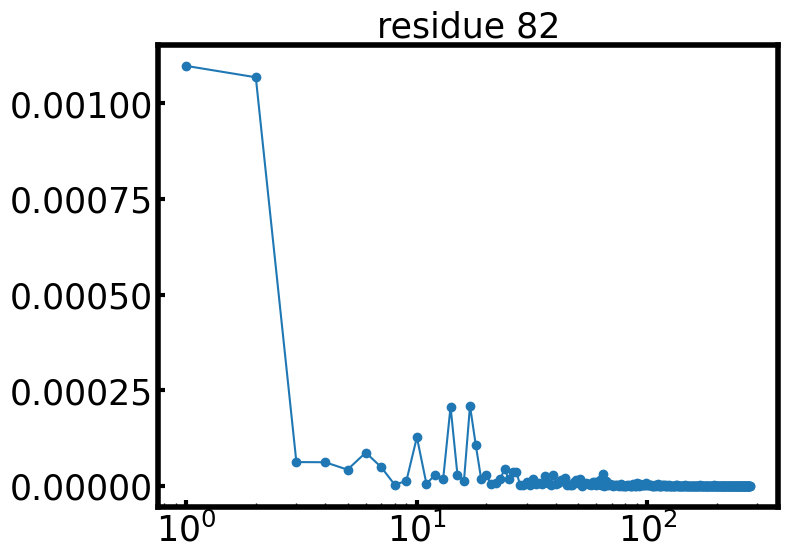

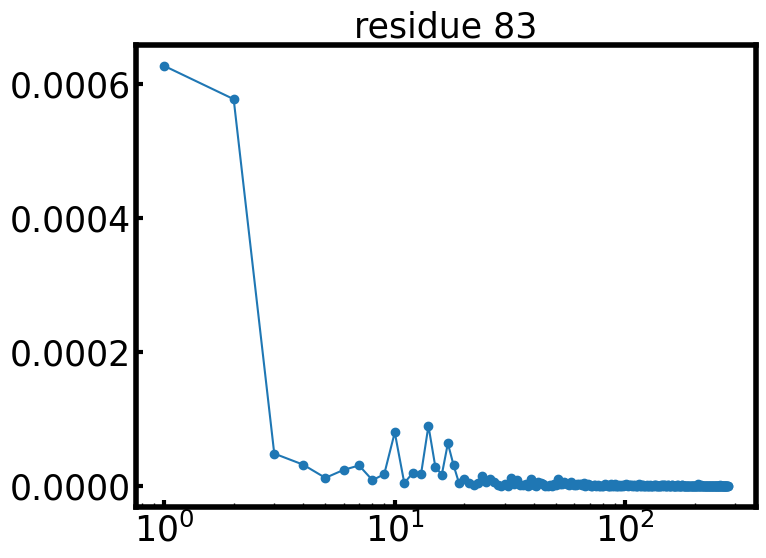

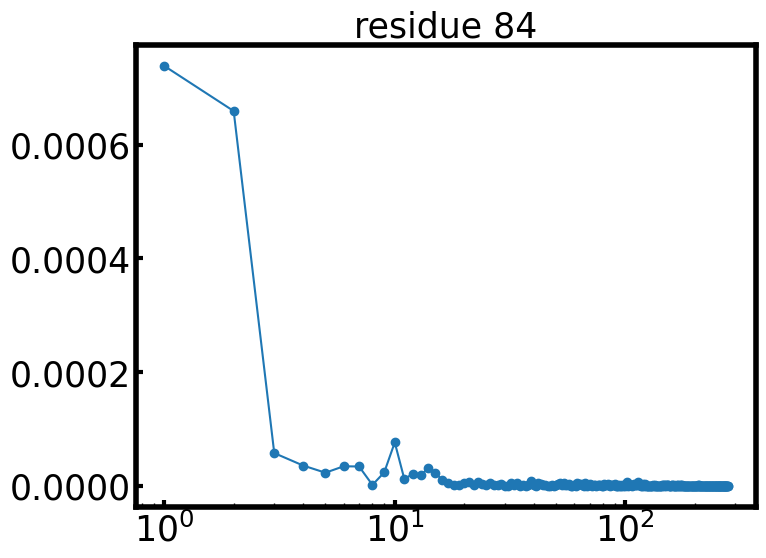

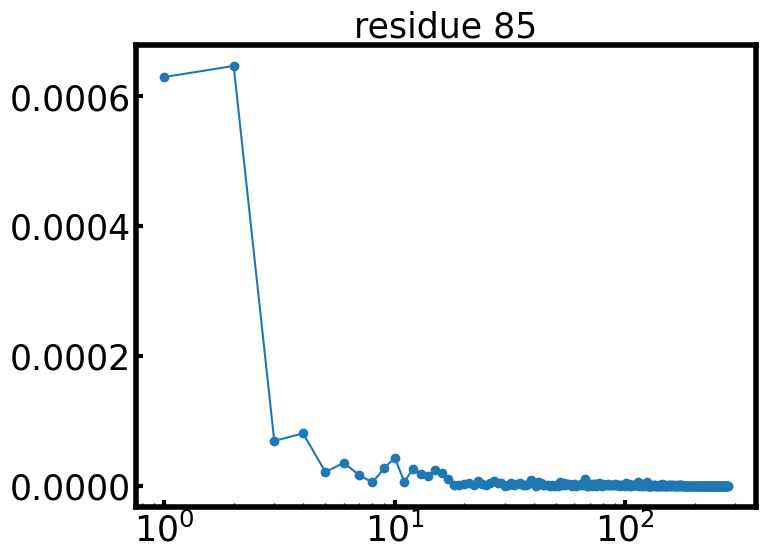

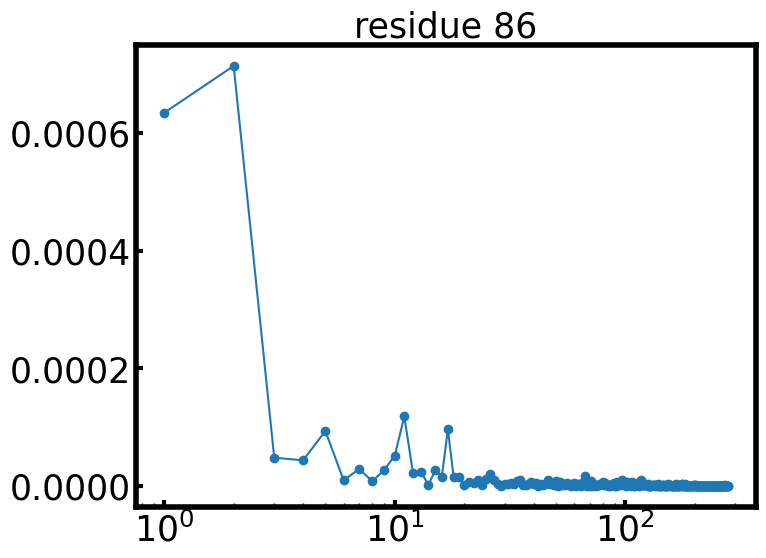

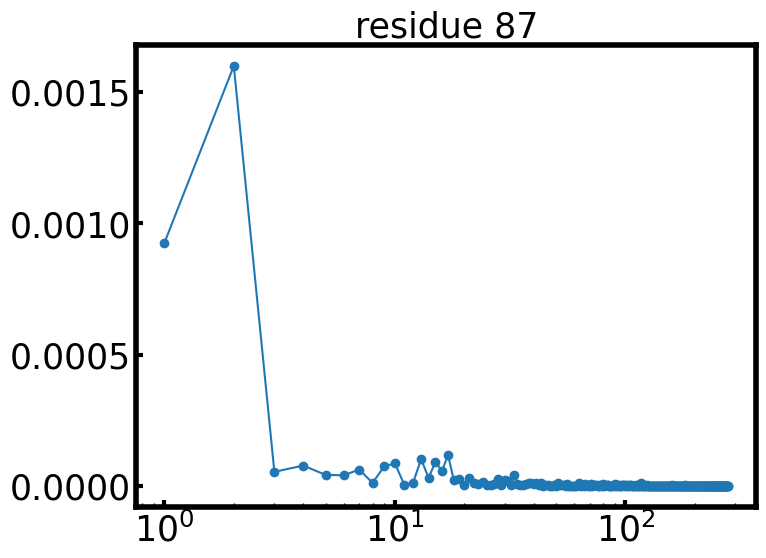

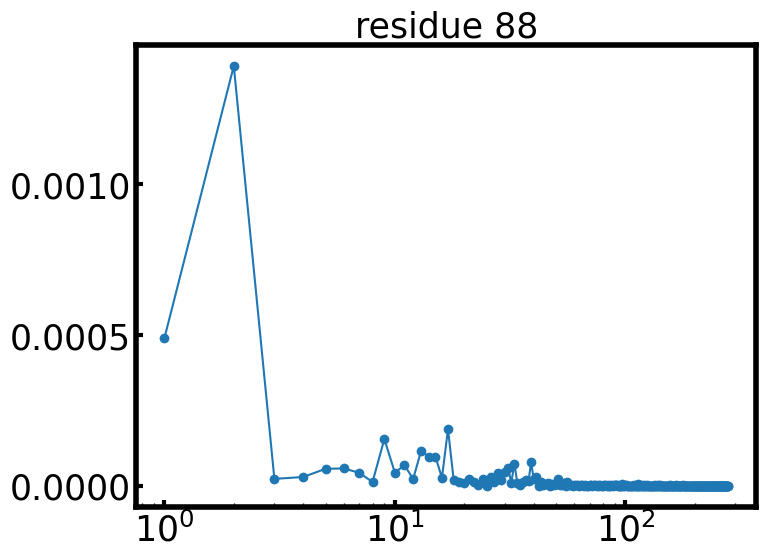

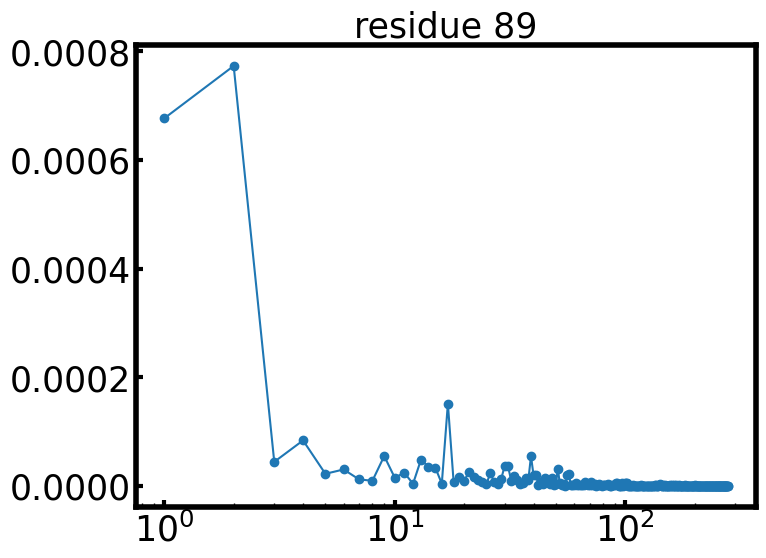

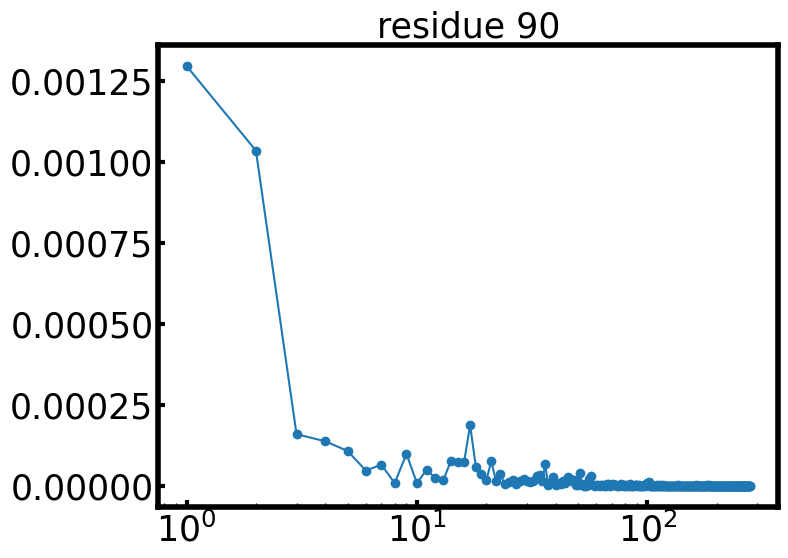

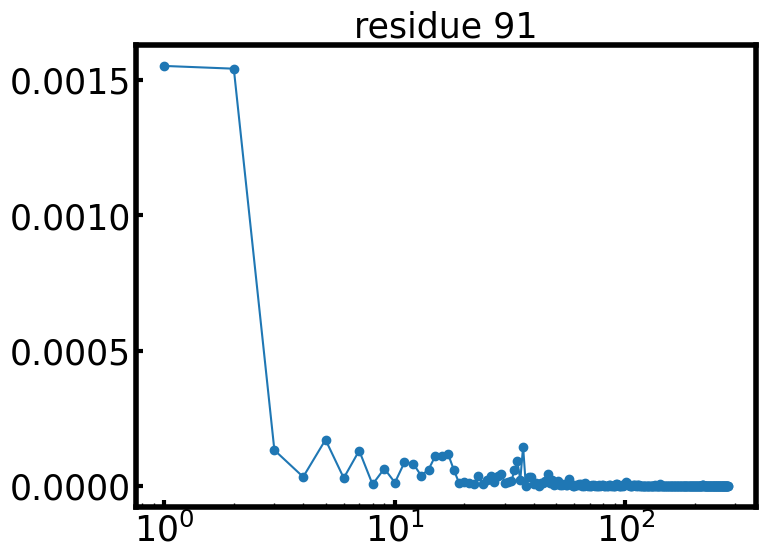

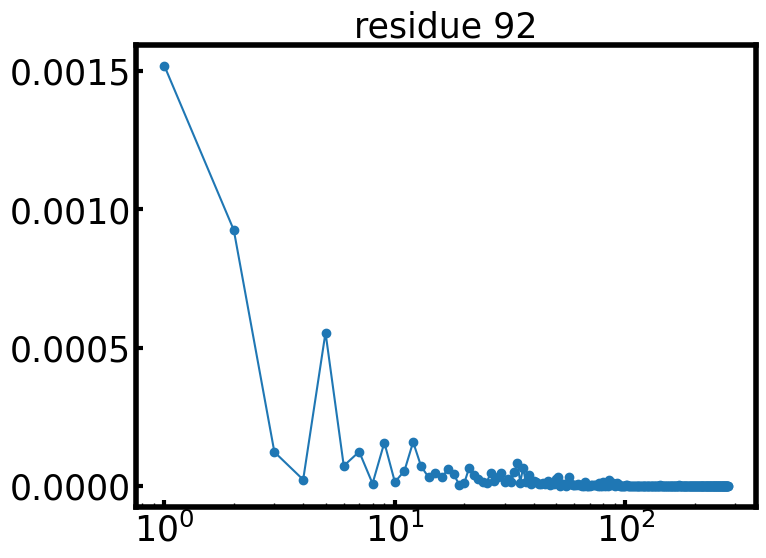

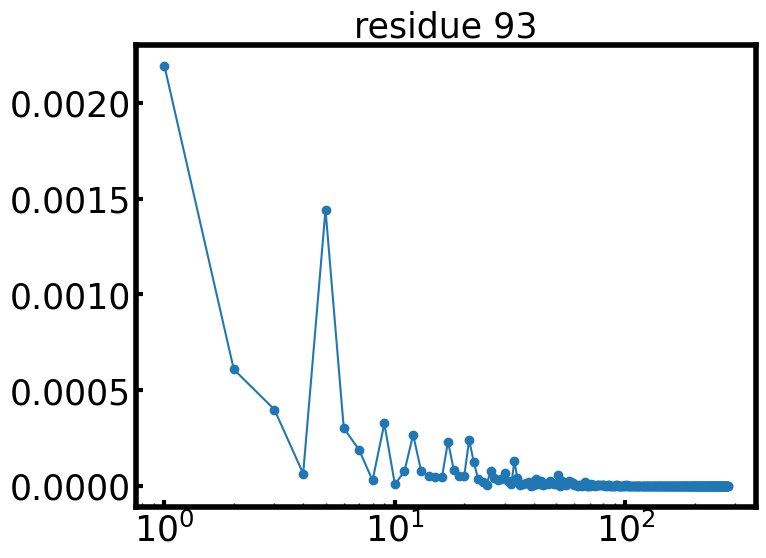

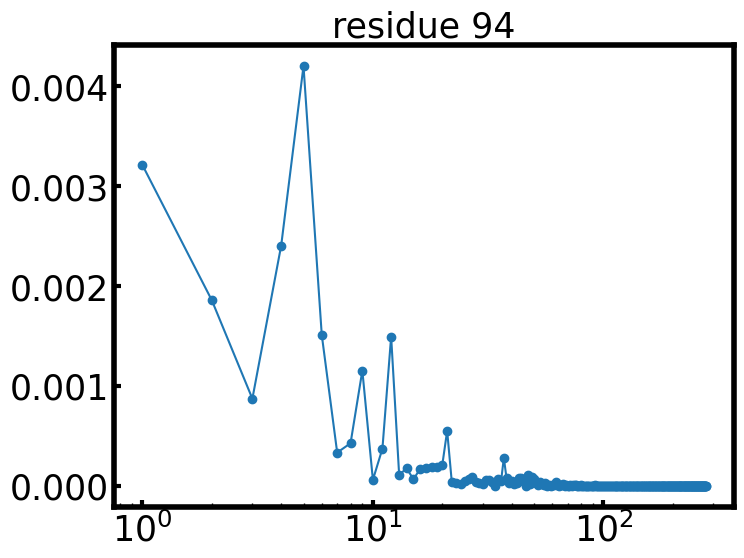

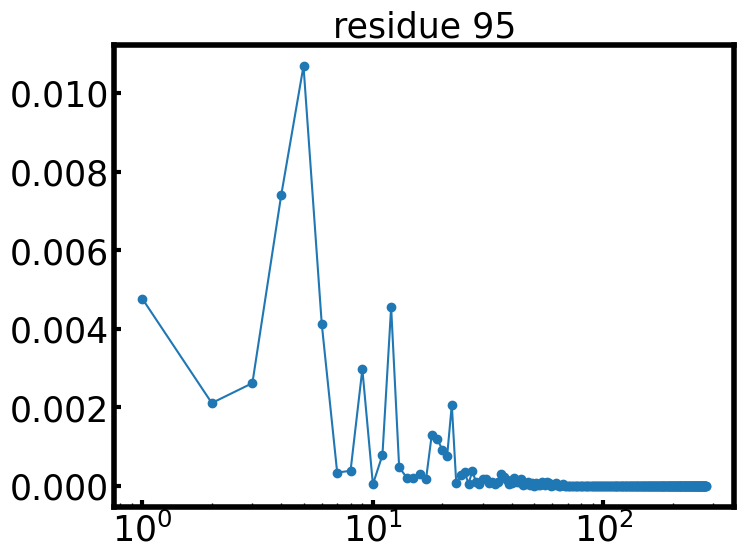

In [78]:
for i in range(weights.shape[0]):
    plt.plot(np.arange(1, 1 + weights.shape[1]), weights[i,:], marker = 'o')
    plt.xscale('log')
    plt.title('residue %s' % (i + 1))
    plt.show()
    plt.close()

In [100]:
import pickle
with open('./HA_tcf_calc_no_deepfakes.pkl','rb') as f:
    ensembles = pickle.load(f)

In [101]:
del ensembles